<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Carrefour/Carrefour_1H_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "CAFREUR"
data_resample = '1H'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 17:28:40,468 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 17:28:40,469 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for CAFREUR
2019-08-27 17:31:53,161 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 17:38:37,801 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 17:42:10,717 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 17:45:34,880 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 17:49:03,674 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 17:52:22,994 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 17:55:50,663 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 17:59:18,028 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.18032  0.18158  0.18027  0.18068  2.017995
2018-01-02 09:00:00  0.18073  0.18078  0.18002  0.18037  2.046268
2018-01-02 10:00:00  0.18042  0.18072  0.17968  0.17968  1.376857
2018-01-02 11:00:00  0.17972  0.18008  0.17942  0.17982  0.888680
2018-01-02 12:00:00  0.17983  0.18033  0.17962  0.18033  1.036006
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.14898  0.14977  0.14837  0.14973  0.492554
2018-12-31 09:00:00  0.14973  0.14983  0.14903  0.14923  0.455768
2018-12-31 10:00:00  0.14928  0.14943  0.14822  0.14862  0.413110
2018-12-31 11:00:00  0.14862  0.14913  0.14837  0.14893  0.431994
2018-12-31 12:00:00  0.14893  0.14907  0.14688  0.14872  0.326100

[2279 rows x 5 columns]

Open         High          Low        Close       Volume
count  2279.000000  2279.000000  2279.000000  2279.000000  2279.000000
mean      0.163480     0.164003     0.162983     0.163486     2.113185
std       0.014464     0.014500     0.014438     0.014467     1.710977
min       0.130630     0.130830     0.129470     0.130620     0.000020
25%       0.153470     0.153930     0.153025     0.153500     1.268008
50%       0.164170     0.164630     0.163770     0.164220     1.776380
75%       0.172225     0.172930     0.171795     0.172180     2.425075
max       0.196620     0.197280     0.196270     0.196630    34.705429

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.17923  0.17978  0.17917  0.17948  1.606659    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.179893  0.180000 -0.180278  0.179285  0.179738  0.179683    0.179870    0.179825  0.181166  0.179612  0.179497  0.179733  0.179635  0.179612  0.179540  0.180857                0.180581                 0.179612                0.178644                0.181065                 0.179612                0.178160                0.181549                 0.179612                0.177676                0.182033                 0.179612                0.177192  0.179738  0.179522  0.180633                0.180706                 0.179738                0.178770                0.181191                 0.179738                0.178286                0.181675                 0.179738                0.177802                0.182159                 0.179738   
2018-01-09 14:00:00  0.17947  0.17958  0.17807  0.17808  4.947267    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.179802  0.179995 -0.180046  0.178730  0.179370  0.179625    0.179375    0.179550  0.180962  0.179488  0.178751  0.179643  0.179294  0.179488  0.178780  0.180669                0.180869                 0.179488                0.178106                0.181559                 0.179488                0.177416                0.182250                 0.179488                0.176725                0.182940                 0.179488                0.176035  0.179370  0.178547  0.180451                0.180751                 0.179370                0.177989                0.181441                 0.179370                0.177298                0.182132                 0.179370                0.176607                0.182822                 0.179370   
2018-01-09 15:00:00  0.17812  0.17843  0.17752  0.17812 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month        hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000    2229.000000  2229.00000   2229.000000     2229.000000     2229.000000       2229.000000  2229.000000  2229.000000  2229.000000  2229.000000   2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000  2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000  2229.000000  2229.000000  2229.000000             2229.000000              2229.000000             2229.000000             2229.000000              2229.000000             2229.000000             2229.000000   
mean      0.163072     0.163595     0.162573     0.163078     2.123110    15.993719     2.018394   185.571108      30.424406    11.37057      0.033647        0.023777        0.002243          0.004038     6.602064     2.535218    26.962315     2.018394      2.005384    26.962315     0.163133     0.163263    -0.006017     0.163077     0.163127     0.163086     0.163110     0.163122     0.163190     0.163126     0.163079     0.163126     0.163110     0.163126     0.163083     0.163229                0.164777                 0.163126                0.161476                0.165602                 0.163126                0.160651                0.166427                 0.163126                0.159826                0.167252                 0.163126                0.159001     0.163127     0.163087     0.163212                0.164777                 0.163127                0.161477                0.165602                 0.163127                0.160651                0.166427   
std       0.014360     0.014398     0.014331     0.014365     1.725332     8.579910     1.412983   101.940922       0.853894     2.62103      0.180360        0.152389        0.047319          0.063429     3.354037     1.103789    14.563931     1.412983      1.404650    14.563931     0.014327     0.014237     0.163603     0.014382     0.014308     0.014334     0.014318     0.014331     0.014376     0.014328     0.014372     0.014337     0.014333     0.014328     0.014357     0.014263                0.014430                 0.014328                0.014363                0.014532                 0.014328                0.014433                0.014667                 0.014328                0.014535                0.014833                 0.014328                0.014671     0.014308     0.014350     0.014273                0.014414                 0.014308                0.014340                0.014518                 0.014308                0.014408                0.014654   
min       0.130630     0.130830     0.129470  

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.736475  0.736644  0.744012  0.740191  0.046294    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.751277  0.762243  0.043366  0.737295  0.747381  0.744442    0.747816    0.749810  0.762368  0.744670  0.741426  0.746779  0.745047  0.744670  0.742397  0.770745                0.710652                 0.744670                0.742370                0.671372                 0.744670                0.753943                0.635290                 0.744670                0.770425                0.602231                 0.744670                0.785255  0.747381  0.742523  0.765838                0.705293                 0.747381                0.746620                0.664186                 0.747381                0.750570                0.627859                 0.747381                0.766359                0.595526                 0.747381   
2018-01-09 14:00:00  0.740112  0.733634  0.727545  0.718982  0.142550    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.749887  0.762165  0.043958  0.728938  0.741722  0.743539    0.740230    0.745621  0.759364  0.742756  0.730081  0.745402  0.739844  0.742756  0.730839  0.767775                0.714828                 0.742756                0.734363                0.678120                 0.742756                0.743551                0.644310                 0.742756                0.758259                0.613259                 0.742756                0.771646  0.741722  0.727694  0.762985                0.705933                 0.741722                0.735031                0.667579                 0.741722                0.736411                0.633685                 0.741722                0.750613                0.603517                 0.741722   
2018-01-09 15:00:00  0.719654  0.716328  

139807

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpruelezur
  JVM stdout: /tmp/tmpruelezur/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpruelezur/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_ol2kum
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.738179  0.690177              0.329156  0.458772  0.210472
1  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.721136  0.660525              0.315581  0.459419  0.211066
2  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.716374  0.952962              0.308396  0.495057  0.245081
3  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.707435  0.638622              0.346658  0.465563  0.216748
4  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.705347  0.758550              0.354177  0.510024  0.260124
5  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.704762  0.652815              0.386884  0.466840  0.217939
6              DeepLearning_1_AutoML_20190827_181932  0.699332  0.640738              0.340602  0.466158  0.217303
7  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.684545  0.645389              0.350585  0.470667  0.221528
8  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.601504  0.708056              0.445405  0.503414  0.253426
9  DeepLearning_grid_1_AutoML_20190827_181932_mod...  0.594319  3.652791              0.416959  0.614206  0.377249

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.005231
1           CDLMORNINGDOJISTAR             0.640398           0.640398    0.003350
2                  CDLLONGLINE             0.622513           0.622513    0.003257
3                          DIV             0.615233           0.615233    0.003219
4           CDLSEPARATINGLINES             0.612863           0.612863    0.003206
...                        ...                  ...                ...         ...
1029  BBANDS_middleband_12_5_4             0.144681           0.144681    0.000757
1030                   MA_24_6             0.144455           0.144455    0.000756
1031                   KAMA_30             0.143193           0.143193    0.000749
1032              LINEARREG_24             0.143032           0.143032    0.000748
1033                    MAX_14             0.140891           0.140891    0.000737

[1034 rows x 4 columns]

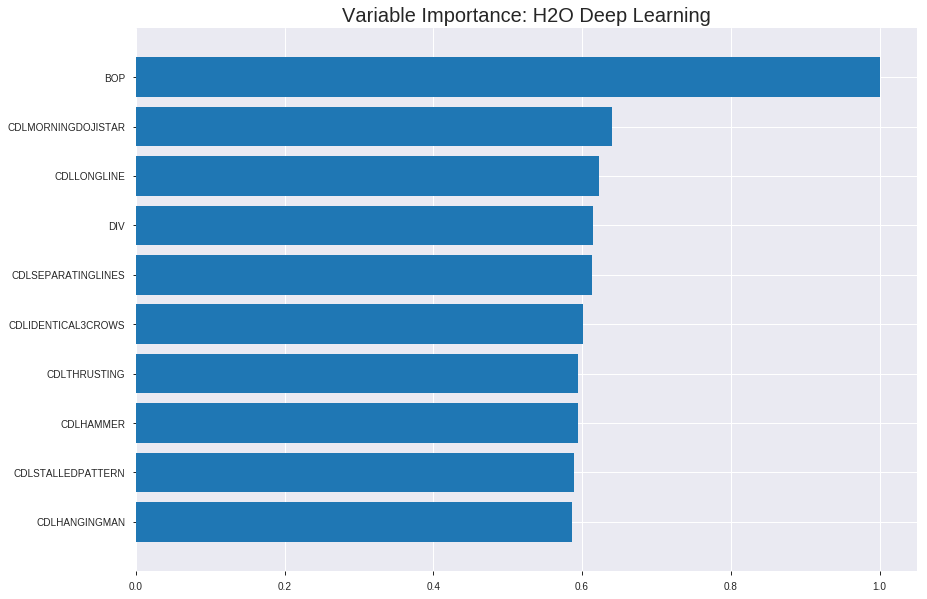

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_181932_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23643633323346197
RMSE: 0.4862471935481602
LogLoss: 0.6949281107535578
Mean Per-Class Error: 0.3475362863605489
AUC: 0.7121771156877098
pr_auc: 0.679097172199857
Gini: 0.4243542313754196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17605695210028782: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      286  526   0.6478   (526.0/812.0)
1      74   673   0.0991   (74.0/747.0)
Total  360  1199  0.3849   (600.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.176057     0.691675  320
max f2                       0.0516662    0.833523  372
max f0point5                 0.54452      0.634518  187
max accuracy                 0.54452      0.649775  187
max precision                0.997336     1         0
max recall                   0.0022083    1         398
max specificity              0.997336     1         0
max absolute_mcc             0.299156     0.322937  275
max min_per_class_accuracy   0.534256     0.646586  192
max mean_per_class_accuracy  0.299156     0.652464  275

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.990094           2.08701   2.08701            1                0.995349   1                           0.995349            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.980236           1.82614   1.95658            0.875            0.985148   0.9375                      0.990248            0.0187416       0.0401606                  82.6138   95.6576
    3        0.0301475                   0.975339           1.94788   1.9538             0.933333         0.977246   0.93617                     0.986099            0.0187416       0.0589023                  94.788    95.3801
    4        0.0404105                   0.968247           1.6957    1.88825            0.8125           0.971896   0.904762                    0.982492            0.0174029       0.0763052                  69.5699   88.8251
    5        0.0500321                   0.951577           1.53048   1.81945            0.733333         0.961386   0.871795                    0.978433            0.0147256       0.0910308                  53.0477   81.9449
    6        0.100064                    0.920571           1.52513   1.67229            0.730769         0.936278   0.801282                    0.957355            0.0763052       0.167336                   52.5126   67.2287
    7        0.150096                    0.873627           1.4181    1.58756            0.679487         0.899323   0.760684                    0.938011            0.0709505       0.238286                   41.81     58.7558
    8        0.200128                    0.838113           1.28432   1.51175            0.615385         0.854776   0.724359                    0.917202            0.064257        0.302544                   28.4317   51.1748
    9        0.300192                    0.753337           1.21743   1.41364            0.583333         0.795687   0.67735                     0.876697            0.121821        0.424364                   21.7425   41.364
    10       0.400257                    0.644566           1.16391   1.35121            0.557692         0.698417   0.647436                    0.832127            0.116466        0.54083                    16.3912   35.1208
    11       0.500321                    0.518983           1.13716   1.3084             0.544872         0.582976   0.626923                    0.782297            0.113788        0.654618                   13.7155   30.8398
    12       0.599743                    0.372982           1.00985   1.25891            0.483871         0.445198   0.603209                    0.726414            0.100402        0.75502                    0.984583  25.8905
    13       0.699808                    0.244997           0.923103  1.21089            0.442308         0.311503   0.580202                    0.667087            0.0923695       0.84739                    -7.68973  21.0889
    14       0.799872                    0.14268            0.749185  1.15313            0.358974         0.193642   0.552526                    0.607859            0.0749665       0.922356                   -25.0815  15.313
    15       0.899936                    0.0564169          0.561889  1.08739            0.269231         0.100562   0.521026                    0.551452            0.0562249       0.978581                   -43.8111  8.73897
    16       1                           5.23244e-06        0.214053  1                  0.102564         0.0229937  0.479153                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19330215513017676
RMSE: 0.4396614096440314
LogLoss: 0.6084141343163271
Mean Per-Class Error: 0.26943089430894307
AUC: 0.7741056910569106
pr_auc: 0.7299248745081194
Gini: 0.5482113821138213
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48461217722607514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      183  63   0.2561   (63.0/246.0)
1      59   141  0.295    (59.0/200.0)
Total  242  204  0.2735   (122.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.484612     0.69802   186
max f2                       0.103461     0.814249  343
max f0point5                 0.636142     0.730874  123
max accuracy                 0.559641     0.73991   159
max precision                0.998821     1         0
max recall                   1.18821e-05  1         399
max specificity              0.998821     1         0
max absolute_mcc             0.559641     0.471166  159
max min_per_class_accuracy   0.459288     0.715     195
max mean_per_class_accuracy  0.559641     0.730569  159

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 44.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.98766            2.23      2.23               1                0.993364   1                           0.993364            0.025           0.025                      123       123
    2        0.0201794                   0.977385           1.6725    1.98222            0.75             0.982882   0.888889                    0.988705            0.015           0.04                       67.25     98.2222
    3        0.0313901                   0.93886            1.784     1.91143            0.8              0.956297   0.857143                    0.977131            0.02            0.06                       78.4      91.1429
    4        0.0403587                   0.908846           2.23      1.98222            1                0.918633   0.888889                    0.964132            0.02            0.08                       123       98.2222
    5        0.0515695                   0.887867           1.338     1.84217            0.6              0.894698   0.826087                    0.949037            0.015           0.095                      33.8      84.2174
    6        0.100897                    0.830104           1.82455   1.83356            0.818182         0.858117   0.822222                    0.904587            0.09            0.185                      82.4545   83.3556
    7        0.150224                    0.771193           1.72318   1.79731            0.772727         0.798859   0.80597                     0.869871            0.085           0.27                       72.3182   79.7313
    8        0.201794                    0.727655           1.93913   1.83356            0.869565         0.747402   0.822222                    0.838573            0.1             0.37                       93.913    83.3556
    9        0.300448                    0.628878           1.6725    1.78067            0.75             0.675351   0.798507                    0.784978            0.165           0.535                      67.25     78.0672
    10       0.401345                    0.538152           1.09022   1.60709            0.488889         0.585061   0.72067                     0.73472             0.11            0.645                      9.02222   60.7095
    11       0.5                         0.427478           0.810909  1.45               0.363636         0.484232   0.650224                    0.685296            0.08            0.725                      -18.9091  45
    12       0.600897                    0.356885           0.693778  1.32302            0.311111         0.393711   0.593284                    0.636336            0.07            0.795                      -30.6222  32.3022
    13       0.699552                    0.261737           0.658864  1.22936            0.295455         0.304955   0.551282                    0.589603            0.065           0.86                       -34.1136  22.9359
    14       0.800448                    0.180357           0.792889  1.17434            0.355556         0.223646   0.526611                    0.543474            0.08            0.94                       -20.7111  17.4342
    15       0.899103                    0.0618643          0.202727  1.06773            0.0909091        0.113679   0.478803                    0.496314            0.02            0.96                       -79.7273  6.77307
    16       1                           1.18821e-05        0.396444  1                  0.177778         0.0306285  0.44843                     0.449328


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:21:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:21:39  2 min  0.928 sec  435 obs/sec       0.355356  1             554        0.585339         3.35076             -0.372874      0.623174        0.512298           1.82614          0.520847                         0.607691           2.17857               -0.493038        0.629309          0.572961             2.23               0.511211
    2019-08-27 18:21:47  2 min  9.423 sec  518 obs/sec       2.97306   8             4635       0.574941         2.04293             -0.32453       0.686652        0.483956           1.95658          0.389352                         0.523838           1.44381               -0.109428        0.721067          0.645049             1.784              0.32287
    2019-08-27 18:21:56  2 min 18.520 sec  536 obs/sec       5.92431   16            9236       0.556751         2.25386             -0.242046      0.68748         0.62787            1.95658          0.403464                         0.497716           1.51261               -0.00153762      0.75374           0.672115             2.23               0.304933
    2019-08-27 18:22:05  2 min 27.457 sec  547 obs/sec       8.89737   24            13871      0.538892         2.15615             -0.163643      0.691619        0.609219           1.82614          0.429763                         0.584315           2.06126               -0.380381        0.682337          0.587441             2.23               0.390135
    2019-08-27 18:22:14  2 min 36.221 sec  554 obs/sec       11.8396   32            18458      0.494686         1.07259             0.0194366      0.75442         0.57492            1.82614          0.322001                         0.501609           1.18478               -0.017267        0.743547          0.671022             2.23               0.316143
    2019-08-27 18:22:23  2 min 45.441 sec  555 obs/sec       14.8531   40            23156      0.493209         0.98931             0.0252868      0.736694        0.607455           1.82614          0.336754                         0.49058            0.943856              0.0269754        0.735264          0.670389             2.23               0.343049
    2019-08-27 18:22:31  2 min 53.578 sec  555 obs/sec       17.4657   47            27229      0.559599         1.43765             -0.254785      0.683418        0.668769           2.08701          0.429763                         0.495736           1.05724               0.00641243       0.74436           0.69382              2.23               0.309417
    2019-08-27 18:22:41  3 min  2.943 sec  555 obs/sec       20.44     55            31866      0.451026         0.646968            0.184885       0.775458        0.716001           1.82614          0.297627                         0.459906           0.713196              0.144849         0.751372          0.654667             2.23               0.304933
    2019-08-27 18:22:52 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.005231406554346477
CDLMORNINGDOJISTAR        0.6403980255126953     0.6403980255126953   0.0033501824280576563
CDLLONGLINE               0.622512936592102      0.622512936592102    0.0032566182566533953
DIV                       0.6152330636978149     0.6152330636978149   0.0032185342818794125
CDLSEPARATINGLINES        0.6128633618354797     0.6128633618354797   0.003206137408024945
---                       ---                    ---                  ---
BBANDS_middleband_12_5_4  0.1446807086467743     0.1446807086467743   0.000756883607502228
MA_24_6                   0.14445456862449646    0.14445456862449646  0.0007557005771074836
KAMA_30                   0.14319275319576263    0.14319275319576263  0.00074909950760323
LINEARREG_24              0.14303240180015564    0.14303240180015564  0.000748260644261253
MAX_14                    0.14089073240756989    0.14089073240756989  0.0007370567009636367


See the whole table with table.as_data_frame()


('accuracy', 0.7219730941704036)

('F1', 0.6422018348623854)

('auc', 0.7381787802840435)

('logloss', 0.6901771823332367)

('mean_per_class_error', 0.3049289891395155)

('rmse', 0.4587718777022236)

('mse', 0.210471635770424)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.210471635770424
RMSE: 0.4587718777022236
LogLoss: 0.6901771823332367
Mean Per-Class Error: 0.3049289891395155
AUC: 0.7381787802840435
pr_auc: 0.6493308804571032
Gini: 0.476357560568087
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19489620660285004: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   58   0.4361   (58.0/133.0)
1      20   70   0.2222   (20.0/90.0)
Total  95   128  0.3498   (78.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.194896     0.642202  127
max f2                       0.048068     0.782689  182
max f0point5                 0.483584     0.663842  65
max accuracy                 0.483584     0.721973  65
max precision                0.998322     1         0
max recall                   7.14116e-06  1         222
max specificity              0.998322     1         0
max absolute_mcc             0.458785     0.409369  71
max min_per_class_accuracy   0.282798     0.676692  103
max mean_per_class_accuracy  0.458785     0.695071  71

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 33.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.961024           1.65185   1.65185            0.666667         0.984234    0.666667                    0.984234            0.0222222       0.0222222                  65.1852   65.1852
    2        0.0224215                   0.956574           2.47778   1.98222            1                0.959032    0.8                         0.974153            0.0222222       0.0444444                  147.778   98.2222
    3        0.0313901                   0.938118           1.23889   1.76984            0.5              0.95248     0.714286                    0.967961            0.0111111       0.0555556                  23.8889   76.9841
    4        0.0403587                   0.899445           2.47778   1.92716            1                0.919627    0.777778                    0.95722             0.0222222       0.0777778                  147.778   92.716
    5        0.0538117                   0.877163           2.47778   2.06481            1                0.885626    0.833333                    0.939322            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.768142           2.02727   2.04686            0.818182         0.816836    0.826087                    0.880741            0.1             0.211111                   102.727   104.686
    7        0.152466                    0.70746            1.35152   1.8219             0.545455         0.730934    0.735294                    0.832274            0.0666667       0.277778                   35.1515   82.1895
    8        0.201794                    0.610877           1.80202   1.81704            0.727273         0.649299    0.733333                    0.787547            0.0888889       0.366667                   80.202    81.7037
    9        0.300448                    0.48239            1.57677   1.73814            0.636364         0.540325    0.701493                    0.70637             0.155556        0.522222                   57.6768   73.8143
    10       0.399103                    0.377164           0.90101   1.53121            0.363636         0.429405    0.617978                    0.637907            0.0888889       0.611111                   -9.89899  53.1211
    11       0.502242                    0.268074           0.969565  1.41587            0.391304         0.308787    0.571429                    0.57032             0.1             0.711111                   -3.04348  41.5873
    12       0.600897                    0.184547           0.788384  1.31285            0.318182         0.221026    0.529851                    0.512973            0.0777778       0.788889                   -21.1616  31.2852
    13       0.699552                    0.132297           0.563131  1.20712            0.227273         0.157917    0.487179                    0.462901            0.0555556       0.844444                   -43.6869  20.7123
    14       0.798206                    0.0599378          0.788384  1.15537            0.318182         0.0869592   0.466292                    0.416436            0.0777778       0.922222                   -21.1616  15.5368
    15       0.896861                    0.0169256          0.450505  1.07783            0.181818         0.036472    0.435                       0.37464             0.0444444       0.966667                   -54.9495  7.78333
    16       1                           7.14116e-06        0.323188  1                  0.130435         0.00714313  0.403587  

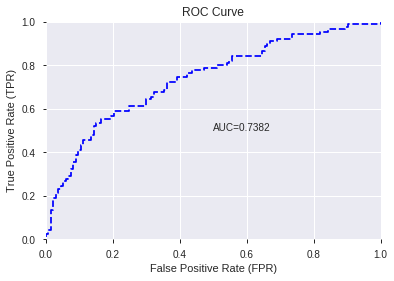

This function is available for GLM models only


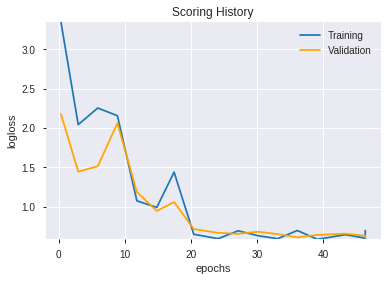

--2019-08-27 18:45:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  14.3MB/s    in 25s     

2019-08-27 18:46:02 (14.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_181932_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_181932_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_184616_model_8  0.735338  0.631305              0.345990  0.459031  0.210709
1  DeepLearning_grid_1_AutoML_20190827_184616_model_6  0.731495  0.622660              0.337176  0.457139  0.208976
2  DeepLearning_grid_1_AutoML_20190827_184616_model_5  0.728655  0.607968              0.360067  0.455462  0.207446
3  DeepLearning_grid_1_AutoML_20190827_184616_model_9  0.723392  0.605904              0.336174  0.455460  0.207443
4  DeepLearning_grid_1_AutoML_20190827_184616_model_7  0.720718  0.769562              0.319173  0.508422  0.258493
5  DeepLearning_grid_1_AutoML_20190827_184616_model_4  0.716792  0.833611              0.359398  0.498934  0.248935
6  DeepLearning_grid_1_AutoML_20190827_184616_model_3  0.712448  0.787153              0.380827  0.482230  0.232546
7               DeepLearning_1_AutoML_20190827_184616  0.694403  0.644731              0.346825  0.472867  0.223603
8  DeepLearning_grid_1_AutoML_20190827_184616_model_2  0.683292  0.788623              0.424645  0.506962  0.257011
9  DeepLearning_grid_1_AutoML_20190827_184616_model_1  0.662991  0.952025              0.386550  0.510811  0.260928

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.031373
1    CDLCLOSINGMARUBOZU             0.847368           0.847368    0.026585
2                  hour             0.828865           0.828865    0.026004
3                TRANGE             0.816465           0.816465    0.025615
4                   SUB             0.766284           0.766284    0.024041
5                   DIV             0.762350           0.762350    0.023918
6          HT_TRENDMODE             0.743676           0.743676    0.023332
7           CDLLONGLINE             0.732498           0.732498    0.022981
8             CDLHAMMER             0.724230           0.724230    0.022722
9                SAREXT             0.704626           0.704626    0.022107
10         STOCHF_fastk             0.687058           0.687058    0.021555
11        days_in_month             0.676090           0.676090    0.021211
12                  day             0.675801           0.675801    0.021202
13             CORREL_8             0.659121           0.659121    0.020679
14       is_month_start             0.630458           0.630458    0.019780
15       STOCHRSI_fastk             0.628456           0.628456    0.019717
16       CDLRICKSHAWMAN             0.627050           0.627050    0.019673
17              CDLDOJI             0.623992           0.623992    0.019577
18              WILLR_8             0.623261           0.623261    0.019554
19               Volume             0.622955           0.622955    0.019544
20    CDLLONGLEGGEDDOJI             0.622869           0.622869    0.019542
21    CDLDARKCLOUDCOVER             0.622379           0.622379    0.019526
22                VAR_8             0.620512           0.620512    0.019468
23            CDLTAKURI             0.620449           0.620449    0.019466
24          CDLPIERCING             0.619684           0.619684    0.019442
25   CDLSEPARATINGLINES             0.613983           0.613983    0.019263
26      CDLLADDERBOTTOM             0.607721           0.607721    0.019066
27     CDLDRAGONFLYDOJI             0.604827           0.604827    0.018976
28   CDLIDENTICAL3CROWS             0.601852           0.601852    0.018882
29      CDLSHOOTINGSTAR             0.600841           0.600841    0.018850
30         is_month_end             0.599011           0.599011    0.018793
31         CDLTASUKIGAP             0.591742           0.591742    0.018565
32            CORREL_14             0.591452           0.591452    0.018556
33    CDLINVERTEDHAMMER             0.585842           0.585842    0.018380
34            CORREL_12             0.579701           0.579701    0.018187
35        CDLHIKKAKEMOD             0.579250           0.579250    0.018173
36           CDL3INSIDE             0.575536           0.575536    0.018057
37         CDLTHRUSTING             0.574497           0.574497    0.018024
38  CDLGAPSIDESIDEWHITE             0.564135           0.564135    0.017699
39       CDLEVENINGSTAR             0.563833           0.563833    0.017689
40   CDLEVENINGDOJISTAR             0.563532           0.563532    0.017680
41      CDLADVANCEBLOCK             0.560901           0.560901    0.017597
42       CDL3BLACKCROWS             0.560592           0.560592    0.017588
43        CDLHANGINGMAN             0.560176           0.560176    0.017575
44    CDLSTALLEDPATTERN             0.559555           0.559555    0.017555
45       CDL3LINESTRIKE             0.557247           0.557247    0.017483
46    CDLGRAVESTONEDOJI             0.557125           0.557125    0.017479
47   CDLMORNINGDOJISTAR             0.547053           0.547053    0.017163
48       CDLMORNINGSTAR             0.545157           0.545157    0.017103
49       CDLMATCHINGLOW             0.542009           0.542009    0.017005

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_184616_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20006917514226608
RMSE: 0.44729092897382355
LogLoss: 0.5863766267323749
Mean Per-Class Error: 0.29511807492696573
AUC: 0.7724757816157899
pr_auc: 0.7499028045503922
Gini: 0.5449515632315798
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39895711446633725: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      446  366  0.4507   (366.0/812.0)
1      130  617  0.174    (130.0/747.0)
Total  576  983  0.3182   (496.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.398957     0.713295  218
max f2                       0.20788      0.836859  303
max f0point5                 0.512419     0.696059  150
max accuracy                 0.512419     0.704939  150
max precision                0.809318     1         0
max recall                   0.0134311    1         392
max specificity              0.809318     1         0
max absolute_mcc             0.463132     0.410487  182
max min_per_class_accuracy   0.491431     0.694779  165
max mean_per_class_accuracy  0.463132     0.704882  182

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 42.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.772784           2.08701   2.08701            1                0.780798  1                           0.780798            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.753261           1.95658   2.0218             0.9375           0.76153   0.96875                     0.771164            0.0200803       0.0414993                  95.6576   102.18
    3        0.0301475                   0.743598           1.66961   1.9094             0.8              0.749049  0.914894                    0.764106            0.0160643       0.0575636                  66.9612   90.9396
    4        0.0404105                   0.724411           1.82614   1.88825            0.875            0.734664  0.904762                    0.756629            0.0187416       0.0763052                  82.6138   88.8251
    5        0.0500321                   0.709475           1.94788   1.89972            0.933333         0.716921  0.910256                    0.748992            0.0187416       0.0950469                  94.788    89.9719
    6        0.100064                    0.647462           1.65891   1.77931            0.794872         0.673449  0.852564                    0.711221            0.0829987       0.178046                   65.8909   77.9314
    7        0.150096                    0.613745           1.79269   1.78377            0.858974         0.628102  0.854701                    0.683514            0.0896921       0.267738                   79.2692   78.3773
    8        0.200128                    0.593466           1.36459   1.67898            0.653846         0.603133  0.804487                    0.663419            0.0682731       0.336011                   36.4587   67.8977
    9        0.300192                    0.553872           1.43148   1.59648            0.685897         0.571757  0.764957                    0.632865            0.14324         0.47925                    43.1478   59.6477
    10       0.400257                    0.523687           1.19067   1.49502            0.570513         0.537796  0.716346                    0.609098            0.119143        0.598394                   19.0669   49.5025
    11       0.500321                    0.483787           1.05689   1.4074             0.50641          0.508014  0.674359                    0.588881            0.105756        0.70415                    5.68857   40.7397
    12       0.599743                    0.423188           0.915594  1.32587            0.43871          0.453333  0.635294                    0.56641             0.0910308       0.795181                   -8.44064  32.5868
    13       0.699808                    0.336456           0.749185  1.24341            0.358974         0.381319  0.595784                    0.539945            0.0749665       0.870147                   -25.0815  24.3409
    14       0.799872                    0.222785           0.775941  1.18493            0.371795         0.278802  0.567763                    0.507276            0.0776439       0.947791                   -22.4059  18.4929
    15       0.899936                    0.0862353          0.347836  1.09185            0.166667         0.149359  0.523165                    0.467479            0.0348059       0.982597                   -65.2164  9.18523
    16       1                           0.000410376        0.173918  1                  0.0833333        0.044419  0.479153                    0.425146          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19519027256106
RMSE: 0.44180343203857075
LogLoss: 0.58273682161414
Mean Per-Class Error: 0.2828861788617886
AUC: 0.781310975609756
pr_auc: 0.7275197756625119
Gini: 0.5626219512195121
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3740510390570824: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      135  111  0.4512   (111.0/246.0)
1      29   171  0.145    (29.0/200.0)
Total  164  282  0.3139   (140.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.374051     0.709544  246
max f2                       0.159191     0.816062  318
max f0point5                 0.547211     0.705645  122
max accuracy                 0.511978     0.721973  166
max precision                0.795138     1         0
max recall                   0.0123779    1         396
max specificity              0.795138     1         0
max absolute_mcc             0.511978     0.436147  166
max min_per_class_accuracy   0.488145     0.711382  186
max mean_per_class_accuracy  0.511978     0.717114  166

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 41.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.774483           2.23      2.23               1                0.78365    1                           0.78365             0.025           0.025                      123       123
    2        0.0201794                   0.758556           1.6725    1.98222            0.75             0.765562   0.888889                    0.775611            0.015           0.04                       67.25     98.2222
    3        0.0313901                   0.74885            1.338     1.75214            0.6              0.752956   0.785714                    0.767519            0.015           0.055                      33.8      75.2143
    4        0.0403587                   0.739914           1.6725    1.73444            0.75             0.743276   0.777778                    0.762132            0.015           0.07                       67.25     73.4444
    5        0.0515695                   0.721135           2.23      1.84217            1                0.728793   0.826087                    0.754884            0.025           0.095                      123       84.2174
    6        0.100897                    0.658429           1.82455   1.83356            0.818182         0.691441   0.822222                    0.723867            0.09            0.185                      82.4545   83.3556
    7        0.150224                    0.61084            1.82455   1.8306             0.818182         0.63408    0.820896                    0.694385            0.09            0.275                      82.4545   83.0597
    8        0.201794                    0.581594           1.74522   1.80878            0.782609         0.593996   0.811111                    0.66873             0.09            0.365                      74.5217   80.8778
    9        0.300448                    0.548501           1.52045   1.7141             0.681818         0.564918   0.768657                    0.634643            0.15            0.515                      52.0455   71.4104
    10       0.401345                    0.518614           1.13978   1.56972            0.511111         0.533997   0.703911                    0.609341            0.115           0.63                       13.9778   56.9721
    11       0.5                         0.477171           1.01364   1.46               0.454545         0.500919   0.654709                    0.587948            0.1             0.73                       1.36364   46
    12       0.600897                    0.405822           0.842444  1.35631            0.377778         0.440888   0.608209                    0.563255            0.085           0.815                      -15.7556  35.6306
    13       0.699552                    0.295581           0.810909  1.27939            0.363636         0.355124   0.573718                    0.533903            0.08            0.895                      -18.9091  27.9391
    14       0.800448                    0.159739           0.446     1.17434            0.2              0.229998   0.526611                    0.495596            0.045           0.94                       -55.4     17.4342
    15       0.899103                    0.07901            0.304091  1.07885            0.136364         0.118272   0.483791                    0.454194            0.03            0.97                       -69.5909  7.88529
    16       1                           0.00697733         0.297333  1                  0.133333         0.0375332  0.44843                     0.412154


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:51:43  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 18:51:44  1 min  0.228 sec  719 obs/sec       0.63374   1             988        0.517832         0.781308            -0.0744677     0.741651        0.701201           1.95658          0.35728                          0.52274            0.793856              -0.104782        0.751108          0.685928             2.23               0.336323
    2019-08-27 18:51:52  1 min  8.160 sec  1044 obs/sec      5.70494   9             8894       0.447291         0.586377            0.19833        0.772476        0.749903           2.08701          0.318153                         0.441803           0.582737              0.210844         0.781311          0.72752              2.23               0.313901
    2019-08-27 18:52:00  1 min 16.520 sec  1161 obs/sec      11.9891   19            18691      0.435197         0.560719            0.241094       0.786801        0.762622           1.95658          0.333547                         0.445119           0.60332               0.198954         0.770904          0.718711             1.784              0.345291
    2019-08-27 18:52:08  1 min 24.351 sec  1230 obs/sec      18.2765   29            28493      0.433689         0.554145            0.246345       0.796395        0.782233           2.08701          0.291212                         0.447625           0.6053                0.18991          0.761992          0.707974             2.23               0.334081
    2019-08-27 18:52:16  1 min 32.477 sec  1285 obs/sec      25.1777   40            39252      0.424765         0.533329            0.277043       0.810577        0.793399           2.08701          0.313663                         0.444464           0.594844              0.201312         0.775894          0.716141             1.338              0.331839
    2019-08-27 18:52:24  1 min 40.342 sec  1333 obs/sec      32.1738   51            50159      0.417253         0.514187            0.302387       0.81981         0.805772           2.08701          0.293137                         0.446019           0.62838               0.195712         0.774482          0.707351             1.338              0.329596
    2019-08-27 18:52:32  1 min 48.345 sec  1379 obs/sec      39.6979   63            61889      0.405896         0.493797            0.339845       0.839323        0.834843           2.08701          0.279025                         0.436528           0.588814              0.229577         0.783567          0.728449             1.784              0.289238
    2019-08-27 18:52:33  1 min 49.121 sec  1378 obs/sec      39.6979   63            61889      0.447291         0.586377            0.19833        0.772476        0.749903           2.08701          0.318153                         0.441803           0.582737              0.210844         0.781311          0.72752              2.23               0.313901

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.03137346486701224
CDLCLOSINGMARUBOZU  0.8473683595657349     0.8473683595657349   0.026584881458253384
hour                0.8288654685020447     0.8288654685020447   0.026004381655528545
TRANGE              0.8164651393890381     0.8164651393890381   0.025615340365762244
SUB                 0.7662842869758606     0.7662842869758606   0.02404099315558069
---                 ---                    ---                  ---
CDL3LINESTRIKE      0.5572471022605896     0.5572471022605896   0.017482772385016988
CDLGRAVESTONEDOJI   0.557125449180603      0.557125449180603    0.017478955706386065
CDLMORNINGDOJISTAR  0.5470525026321411     0.5470525026321411   0.017162932471740604
CDLMORNINGSTAR      0.5451573729515076     0.5451573729515076   0.017103475687286814
CDLMATCHINGLOW      0.542009174823761      0.542009174823761    0.017004705803931562


See the whole table with table.as_data_frame()


('accuracy', 0.7174887892376681)

('F1', 0.6272727272727273)

('auc', 0.7353383458646616)

('logloss', 0.6313048064482143)

('mean_per_class_error', 0.3050960735171262)

('rmse', 0.45903081820540315)

('mse', 0.21070929206232186)

deeplearning prediction progress: |███████████████████████████████████████| 100%


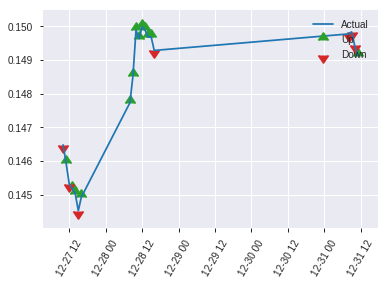


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.21070929206232186
RMSE: 0.45903081820540315
LogLoss: 0.6313048064482143
Mean Per-Class Error: 0.3050960735171262
AUC: 0.7353383458646616
pr_auc: 0.6544768873815101
Gini: 0.47067669172932325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37737017328644956: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   61   0.4586   (61.0/133.0)
1      21   69   0.2333   (21.0/90.0)
Total  93   130  0.3677   (82.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37737      0.627273  129
max f2                       0.0643153    0.79235   188
max f0point5                 0.57503      0.664336  48
max accuracy                 0.57503      0.717489  48
max precision                0.804903     1         0
max recall                   0.0027699    1         221
max specificity              0.804903     1         0
max absolute_mcc             0.57503      0.402285  48
max min_per_class_accuracy   0.449654     0.646617  105
max mean_per_class_accuracy  0.52692      0.694904  76

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 38.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.771138           1.65185   1.65185            0.666667         0.784051   0.666667                    0.784051            0.0222222       0.0222222                  65.1852   65.1852
    2        0.0224215                   0.759214           2.47778   1.98222            1                0.76374    0.8                         0.775927            0.0222222       0.0444444                  147.778   98.2222
    3        0.0313901                   0.739166           2.47778   2.12381            1                0.75117    0.857143                    0.768853            0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.727314           1.23889   1.92716            0.5              0.73232    0.777778                    0.760735            0.0111111       0.0777778                  23.8889   92.716
    5        0.0538117                   0.719256           2.47778   2.06481            1                0.723082   0.833333                    0.751322            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.670583           2.02727   2.04686            0.818182         0.694621   0.826087                    0.724204            0.1             0.211111                   102.727   104.686
    7        0.152466                    0.613605           1.80202   1.96765            0.727273         0.644372   0.794118                    0.698376            0.0888889       0.3                        80.202    96.7647
    8        0.201794                    0.582439           1.80202   1.92716            0.727273         0.598267   0.777778                    0.673905            0.0888889       0.388889                   80.202    92.716
    9        0.300448                    0.553674           1.23889   1.70116            0.5              0.567496   0.686567                    0.638965            0.122222        0.511111                   23.8889   70.1161
    10       0.399103                    0.512348           1.01364   1.53121            0.409091         0.529406   0.617978                    0.611883            0.1             0.611111                   1.36364   53.1211
    11       0.502242                    0.438279           0.646377  1.3495             0.26087          0.477255   0.544643                    0.584236            0.0666667       0.677778                   -35.3623  34.9504
    12       0.600897                    0.367653           0.90101   1.27587            0.363636         0.401903   0.514925                    0.554301            0.0888889       0.766667                   -9.89899  27.5871
    13       0.699552                    0.195825           0.788384  1.20712            0.318182         0.281681   0.487179                    0.515854            0.0777778       0.844444                   -21.1616  20.7123
    14       0.798206                    0.0920762          0.675758  1.14145            0.272727         0.14047    0.460674                    0.469459            0.0666667       0.911111                   -32.4242  14.1448
    15       0.896861                    0.0429859          0.675758  1.09022            0.272727         0.065697   0.44                        0.425045            0.0666667       0.977778                   -32.4242  9.02222
    16       1                           0.0027224          0.215459  1                  0.0869565        0.0210881  0.403587                    0

This function is available for GLM models only


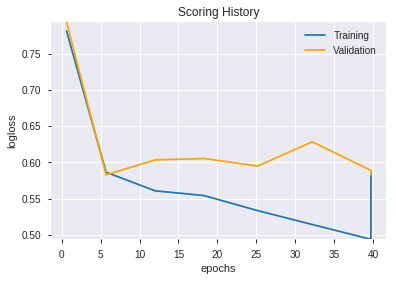

--2019-08-27 18:53:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.251
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.251|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_184616_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_184616_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'hour',
 'TRANGE',
 'SUB',
 'DIV',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLHAMMER',
 'SAREXT',
 'STOCHF_fastk',
 'days_in_month',
 'day',
 'CORREL_8',
 'is_month_start',
 'STOCHRSI_fastk',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'WILLR_8',
 'Volume',
 'CDLLONGLEGGEDDOJI',
 'CDLDARKCLOUDCOVER',
 'VAR_8',
 'CDLTAKURI',
 'CDLPIERCING',
 'CDLSEPARATINGLINES',
 'CDLLADDERBOTTOM',
 'CDLDRAGONFLYDOJI',
 'CDLIDENTICAL3CROWS',
 'CDLSHOOTINGSTAR',
 'is_month_end',
 'CDLTASUKIGAP',
 'CORREL_14',
 'CDLINVERTEDHAMMER',
 'CORREL_12',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGSTAR',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CDL3BLACKCROWS',
 'CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'CDL3LINESTRIKE',
 'CDLGRAVESTONEDOJI',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLMATCHINGLOW']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_185342_model_1  0.739348  0.600006              0.316082  0.450942  0.203349

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.482683           1.000000    0.129177
1             CDLHAMMER             0.202311           0.419139    0.054143
2    CDLCLOSINGMARUBOZU             0.194226           0.402388    0.051979
3                   DIV             0.184551           0.382344    0.049390
4                   SUB             0.179130           0.371114    0.047939
5           CDLLONGLINE             0.136960           0.283746    0.036654
6                  hour             0.126708           0.262508    0.033910
7          STOCHF_fastk             0.123574           0.256014    0.033071
8    CDLSEPARATINGLINES             0.121950           0.252650    0.032637
9                 VAR_8             0.099759           0.206675    0.026698
10             CORREL_8             0.087048           0.180341    0.023296
11          CDLPIERCING             0.081321           0.168476    0.021763
12       CDL3BLACKCROWS             0.081180           0.168185    0.021726
13      CDLSHOOTINGSTAR             0.078559           0.162755    0.021024
14        CDLHANGINGMAN             0.078181           0.161971    0.020923
15       CDL3LINESTRIKE             0.077348           0.160246    0.020700
16               SAREXT             0.072448           0.150094    0.019389
17    CDLDARKCLOUDCOVER             0.072236           0.149656    0.019332
18         CDLTHRUSTING             0.071157           0.147419    0.019043
19      CDLADVANCEBLOCK             0.068699           0.142327    0.018385
20   CDLEVENINGDOJISTAR             0.064309           0.133233    0.017211
21        CDLHIKKAKEMOD             0.064203           0.133013    0.017182
22                  day             0.063607           0.131778    0.017023
23               Volume             0.060135           0.124586    0.016094
24         CDLTASUKIGAP             0.059804           0.123900    0.016005
25               TRANGE             0.058869           0.121963    0.015755
26            CORREL_14             0.057276           0.118661    0.015328
27     CDLDRAGONFLYDOJI             0.055630           0.115252    0.014888
28            CDLTAKURI             0.055427           0.114832    0.014834
29            CORREL_12             0.053945           0.111760    0.014437
30   CDLIDENTICAL3CROWS             0.051641           0.106987    0.013820
31       CDLRICKSHAWMAN             0.050643           0.104919    0.013553
32    CDLINVERTEDHAMMER             0.047837           0.099106    0.012802
33              WILLR_8             0.047239           0.097866    0.012642
34       CDLMORNINGSTAR             0.046518           0.096374    0.012449
35         HT_TRENDMODE             0.040708           0.084336    0.010894
36    CDLLONGLEGGEDDOJI             0.032527           0.067387    0.008705
37              CDLDOJI             0.032479           0.067287    0.008692
38       CDLEVENINGSTAR             0.031557           0.065379    0.008445
39       is_month_start             0.027544           0.057064    0.007371
40  CDLGAPSIDESIDEWHITE             0.026052           0.053973    0.006972
41    CDLSTALLEDPATTERN             0.024595           0.050954    0.006582
42        days_in_month             0.021655           0.044865    0.005795
43       CDLMATCHINGLOW             0.014419           0.029873    0.003859
44    CDLGRAVESTONEDOJI             0.009761           0.020222    0.002612
45       STOCHRSI_fastk             0.005501           0.011396    0.001472
46         is_month_end             0.005313           0.011008    0.001422
47   CDLMORNINGDOJISTAR             0.004275           0.008856    0.001144
48      CDLLADDERBOTTOM             0.001721           0.003566    0.000461
49           CDL3INSIDE             0.001389           0.002877    0.000372

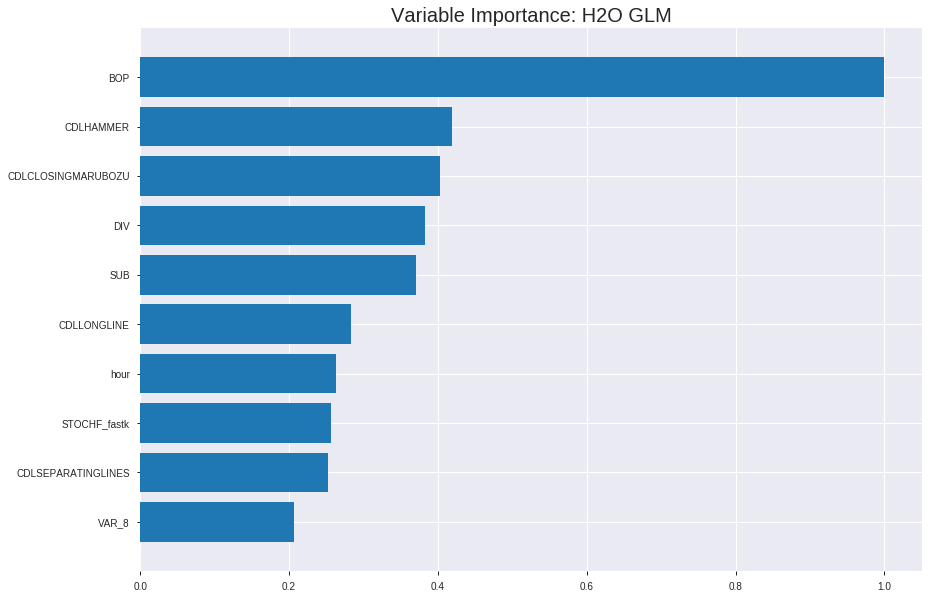

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_185342_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19625280721951532
RMSE: 0.44300429706664846
LogLoss: 0.5757249738159322
Null degrees of freedom: 1558
Residual degrees of freedom: 1508
Null deviance: 2158.5220527111505
Residual deviance: 1795.1104683580766
AIC: 1897.1104683580766
AUC: 0.7692024254654085
pr_auc: 0.7438951319855764
Gini: 0.538404850930817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32637689610346193: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      319  493   0.6071   (493.0/812.0)
1      63   684   0.0843   (63.0/747.0)
Total  382  1177  0.3566   (556.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326377     0.711019  284
max f2                       0.163165     0.831822  349
max f0point5                 0.542359     0.701283  175
max accuracy                 0.533472     0.706863  180
max precision                0.977538     1         0
max recall                   0.0292297    1         395
max specificity              0.977538     1         0
max absolute_mcc             0.533472     0.412196  180
max min_per_class_accuracy   0.48965      0.698276  200
max mean_per_class_accuracy  0.533472     0.704451  180

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.912455           2.08701   2.08701            1                0.934623  1                           0.934623            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.880495           1.6957    1.89136            0.8125           0.893185  0.90625                     0.913904            0.0174029       0.038822                   69.5699   89.1357
    3        0.0301475                   0.861814           1.80875   1.86499            0.866667         0.870776  0.893617                    0.90014             0.0174029       0.0562249                  80.8746   86.4992
    4        0.0404105                   0.846124           1.6957    1.822              0.8125           0.854853  0.873016                    0.888638            0.0174029       0.0736278                  69.5699   82.1997
    5        0.0500321                   0.828966           1.80875   1.81945            0.866667         0.839287  0.871795                    0.879148            0.0174029       0.0910308                  80.8746   81.9449
    6        0.100064                    0.749391           1.76594   1.79269            0.846154         0.786108  0.858974                    0.832628            0.0883534       0.179384                   76.5936   79.2692
    7        0.150096                    0.694668           1.49837   1.69458            0.717949         0.721597  0.811966                    0.795618            0.0749665       0.254351                   49.837    69.4585
    8        0.200128                    0.663216           1.79269   1.71911            0.858974         0.679375  0.823718                    0.766557            0.0896921       0.344043                   79.2692   71.9111
    9        0.300192                    0.607114           1.31107   1.5831             0.628205         0.635842  0.758547                    0.722985            0.131191        0.475234                   31.1073   58.3099
    10       0.400257                    0.550443           1.31107   1.51509            0.628205         0.57782   0.725962                    0.686694            0.131191        0.606426                   31.1073   51.5092
    11       0.500321                    0.483141           1.03013   1.4181             0.49359          0.518844  0.679487                    0.653124            0.103079        0.709505                   3.01291   41.81
    12       0.599743                    0.420442           0.821341  1.31917            0.393548         0.4504    0.632086                    0.619517            0.08166         0.791165                   -17.8659  31.9172
    13       0.699808                    0.364992           0.829455  1.24915            0.397436         0.394196  0.598533                    0.587299            0.0829987       0.874163                   -17.0545  24.9148
    14       0.799872                    0.284363           0.62878   1.17154            0.301282         0.328913  0.561347                    0.554975            0.0629183       0.937082                   -37.122   17.154
    15       0.899936                    0.178603           0.374592  1.08293            0.179487         0.232698  0.518888                    0.519141            0.0374833       0.974565                   -62.5408  8.29271
    16       1                           0.0023695          0.254188  1                  0.121795         0.119523  0.479153                    0.479153            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1922482733956711
RMSE: 0.4384612564362684
LogLoss: 0.5753731838542709
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 615.2252417868635
Residual deviance: 513.2328799980097
AIC: 615.2328799980097
AUC: 0.7817784552845528
pr_auc: 0.7253970375639663
Gini: 0.5635569105691056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42390099904519585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  100  0.4065   (100.0/246.0)
1      37   163  0.185    (37.0/200.0)
Total  183  263  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423901     0.704104  234
max f2                       0.246674     0.824786  328
max f0point5                 0.562694     0.718326  152
max accuracy                 0.562694     0.737668  152
max precision                0.949253     1         0
max recall                   0.00288967   1         399
max specificity              0.949253     1         0
max absolute_mcc             0.562694     0.466568  152
max min_per_class_accuracy   0.501754     0.705     186
max mean_per_class_accuracy  0.562694     0.728069  152

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.896343           2.23      2.23               1                0.928663  1                           0.928663            0.025           0.025                      123        123
    2        0.0201794                   0.864107           1.6725    1.98222            0.75             0.880919  0.888889                    0.907444            0.015           0.04                       67.25      98.2222
    3        0.0313901                   0.851212           1.338     1.75214            0.6              0.859792  0.785714                    0.890425            0.015           0.055                      33.8       75.2143
    4        0.0403587                   0.834105           1.6725    1.73444            0.75             0.846217  0.777778                    0.880601            0.015           0.07                       67.25      73.4444
    5        0.0515695                   0.818406           1.784     1.74522            0.8              0.826508  0.782609                    0.868842            0.02            0.09                       78.4       74.5217
    6        0.100897                    0.756664           1.92591   1.83356            0.863636         0.785388  0.822222                    0.828042            0.095           0.185                      92.5909    83.3556
    7        0.150224                    0.706844           1.82455   1.8306             0.818182         0.731329  0.820896                    0.796286            0.09            0.275                      82.4545    83.0597
    8        0.201794                    0.659433           1.64826   1.784              0.73913          0.682648  0.8                         0.767245            0.085           0.36                       64.8261    78.4
    9        0.300448                    0.599475           1.57114   1.7141             0.704545         0.62759   0.768657                    0.721388            0.155           0.515                      57.1136    71.4104
    10       0.401345                    0.552933           1.338     1.61955            0.6              0.577383  0.726257                    0.685186            0.135           0.65                       33.8       61.9553
    11       0.5                         0.481772           0.709545  1.44               0.318182         0.515047  0.64574                     0.651616            0.07            0.72                       -29.0455   44
    12       0.600897                    0.417048           0.991111  1.36463            0.444444         0.446692  0.61194                     0.617207            0.1             0.82                       -0.888889  36.4627
    13       0.699552                    0.352572           0.5575    1.2508             0.25             0.385931  0.560897                    0.584591            0.055           0.875                      -44.25     25.0801
    14       0.800448                    0.261641           0.693778  1.18059            0.311111         0.305295  0.529412                    0.549386            0.07            0.945                      -30.6222   18.0588
    15       0.899103                    0.173933           0.304091  1.08441            0.136364         0.222473  0.486284                    0.513515            0.03            0.975                      -69.5909   8.4414
    16       1                           0.00288967         0.247778  1                  0.111111         0.113111  0.44843                     0.473115     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 18:53:43  0.000 sec   2            18        51            1.36915           1.36349
    2019-08-27 18:53:43  0.040 sec   4            11        51            1.36074           1.3548
    2019-08-27 18:53:43  0.072 sec   6            6.8       51            1.34857           1.3422
    2019-08-27 18:53:43  0.096 sec   8            4.2       51            1.3318            1.32486
    2019-08-27 18:53:43  0.119 sec   10           2.6       51            1.31031           1.30265
    2019-08-27 18:53:43  0.144 sec   12           1.6       51            1.28508           1.2766
    2019-08-27 18:53:43  0.165 sec   14           1         51            1.2582            1.2489
    2019-08-27 18:53:43  0.188 sec   16           0.63      51            1.2321            1.22211
    2019-08-27 18:53:43  0.209 sec   18           0.39      51            1.20886           1.19847
    2019-08-27 18:53:43  0.234 sec   20           0.24      51            1.18965           1.17932
    2019-08-27 18:53:43  0.254 sec   22           0.15      51            1.17477           1.16526
    2019-08-27 18:53:43  0.274 sec   24           0.093     51            1.16393           1.1562
    2019-08-27 18:53:43  0.298 sec   26           0.058     51            1.15642           1.15162
    2019-08-27 18:53:43  0.320 sec   28           0.036     51            1.15145           1.15075
    2019-08-27 18:53:43  0.336 sec   30           0.022     51            1.14826           1.15276
    2019-08-27 18:53:43  0.352 sec   32           0.014     51            1.14624           1.15695
    2019-08-27 18:53:43  0.375 sec   34           0.0086    51            1.14498           1.1627
    2019-08-27 18:53:43  0.396 sec   36           0.0054    51            1.14419           1.16962
    2019-08-27 18:53:43  0.409 sec   37           0.0033    51            1.14373           1.17633

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6543778801843319)

('auc', 0.7393483709273183)

('logloss', 0.6000058186934354)

('mean_per_class_error', 0.31048454469507103)

('rmse', 0.450941850017365)

('mse', 0.2033485520970837)

glm prediction progress: |████████████████████████████████████████████████| 100%


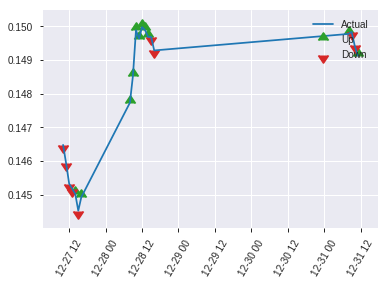


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2033485520970837
RMSE: 0.450941850017365
LogLoss: 0.6000058186934354
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 305.94391779285456
Residual deviance: 267.6025951372722
AIC: 369.6025951372722
AUC: 0.7393483709273183
pr_auc: 0.6539106995927559
Gini: 0.4786967418546366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39665243710749504: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   56   0.4211   (56.0/133.0)
1      19   71   0.2111   (19.0/90.0)
Total  96   127  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396652     0.654378  126
max f2                       0.21155      0.791897  182
max f0point5                 0.582521     0.65508   70
max accuracy                 0.582521     0.717489  70
max precision                0.942916     1         0
max recall                   0.00621317   1         221
max specificity              0.942916     1         0
max absolute_mcc             0.582521     0.399182  70
max min_per_class_accuracy   0.47362      0.655556  102
max mean_per_class_accuracy  0.582521     0.689515  70

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 44.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.86371            2.47778   2.47778            1                0.917069   1                           0.917069            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.841296           1.23889   1.98222            0.5              0.848249   0.8                         0.889541            0.0111111       0.0444444                  23.8889   98.2222
    3        0.0313901                   0.830051           2.47778   2.12381            1                0.838895   0.857143                    0.87507             0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.817633           2.47778   2.20247            1                0.8232     0.888889                    0.863544            0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.812822           1.65185   2.06481            0.666667         0.815691   0.833333                    0.85158             0.0222222       0.111111                   65.1852   106.481
    6        0.103139                    0.768323           2.02727   2.04686            0.818182         0.790181   0.826087                    0.822215            0.1             0.211111                   102.727   104.686
    7        0.152466                    0.698293           1.80202   1.96765            0.727273         0.723333   0.794118                    0.790224            0.0888889       0.3                        80.202    96.7647
    8        0.201794                    0.654365           1.35152   1.81704            0.545455         0.679675   0.733333                    0.763201            0.0666667       0.366667                   35.1515   81.7037
    9        0.300448                    0.589813           1.35152   1.66418            0.545455         0.626771   0.671642                    0.718403            0.133333        0.5                        35.1515   66.4179
    10       0.399103                    0.525122           1.12626   1.53121            0.454545         0.558825   0.617978                    0.678957            0.111111        0.611111                   12.6263   53.1211
    11       0.502242                    0.447132           0.861836  1.39375            0.347826         0.485481   0.5625                      0.639225            0.0888889       0.7                        -13.8164  39.375
    12       0.600897                    0.382723           0.90101   1.31285            0.363636         0.407986   0.529851                    0.60126             0.0888889       0.788889                   -9.89899  31.2852
    13       0.699552                    0.304264           0.675758  1.22301            0.272727         0.346845   0.49359                     0.565381            0.0666667       0.855556                   -32.4242  22.3006
    14       0.798206                    0.221061           0.788384  1.16929            0.318182         0.264911   0.47191                     0.528244            0.0777778       0.933333                   -21.1616  16.9288
    15       0.896861                    0.137716           0.450505  1.09022            0.181818         0.181184   0.44                        0.490068            0.0444444       0.977778                   -54.9495  9.02222
    16       1                           0.00562687         0.215459  1                  0.0869565        0.0844671  0.403587                    

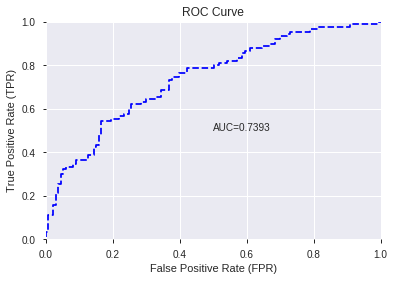

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


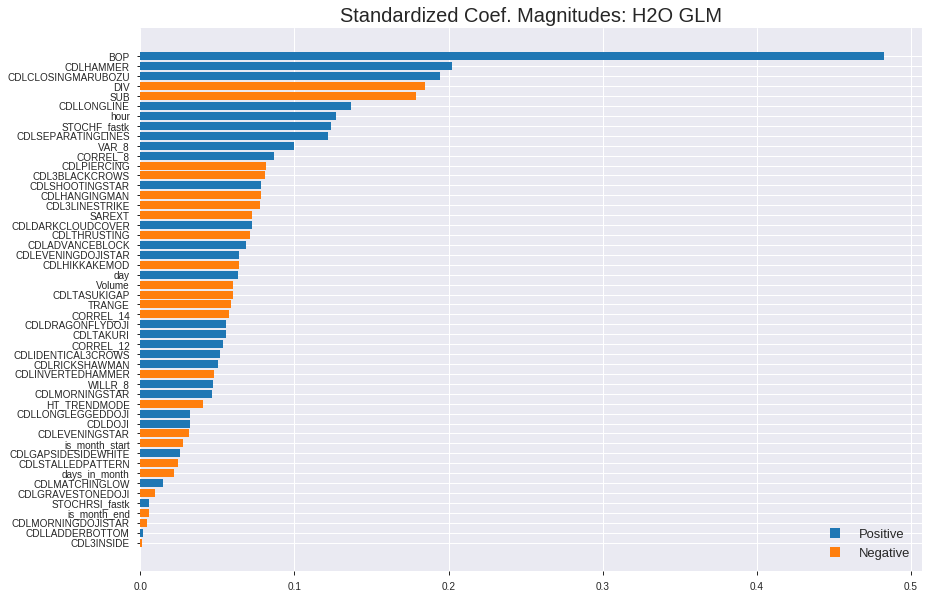

'log_likelihood'
--2019-08-27 18:53:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_185342_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_185342_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'hour',
 'STOCHF_fastk',
 'CDLSEPARATINGLINES',
 'VAR_8',
 'CORREL_8',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'SAREXT',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'day',
 'Volume',
 'CDLTASUKIGAP',
 'TRANGE',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CORREL_12',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'WILLR_8',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'is_month_end',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDL3INSIDE']

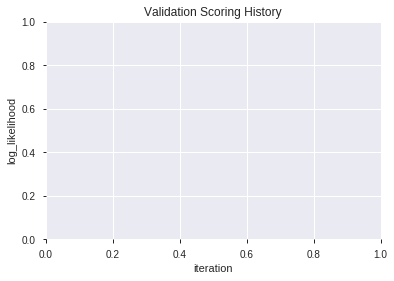

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_185359_model_5  0.752799  0.578827              0.305138  0.445576  0.198538
1  XGBoost_grid_1_AutoML_20190827_185359_model_3  0.748956  0.581443              0.318212  0.447427  0.200191
2               XGBoost_2_AutoML_20190827_185359  0.738764  0.592674              0.320175  0.452116  0.204409
3  XGBoost_grid_1_AutoML_20190827_185359_model_7  0.738596  0.596282              0.318212  0.454068  0.206178
4               XGBoost_3_AutoML_20190827_185359  0.737427  0.599204              0.325898  0.455730  0.207690
5  XGBoost_grid_1_AutoML_20190827_185359_model_6  0.735422  0.596837              0.320510  0.455485  0.207466
6  XGBoost_grid_1_AutoML_20190827_185359_model_4  0.732164  0.592451              0.341437  0.452206  0.204490
7  XGBoost_grid_1_AutoML_20190827_185359_model_2  0.730409  0.596702              0.331788  0.455225  0.207229
8               XGBoost_1_AutoML_20190827_185359  0.729741  0.602910              0.305472  0.456811  0.208676
9  XGBoost_grid_1_AutoML_20190827_185359_model_1  0.728780  0.614792              0.358438  0.463052  0.214417

variable  relative_importance  scaled_importance  percentage
0                   BOP          2740.214355           1.000000    0.121149
1                Volume          2217.795166           0.809351    0.098052
2                   DIV          2129.787109           0.777234    0.094161
3          STOCHF_fastk          2013.017578           0.734620    0.088999
4               WILLR_8          1910.755615           0.697302    0.084478
5                SAREXT          1717.950439           0.626940    0.075953
6                   day          1570.583984           0.573161    0.069438
7                  hour          1461.191284           0.533240    0.064602
8                TRANGE          1350.762817           0.492941    0.059719
9                 VAR_8          1267.157715           0.462430    0.056023
10       STOCHRSI_fastk          1108.678345           0.404595    0.049016
11                  SUB           859.284485           0.313583    0.037990
12        days_in_month           418.459167           0.152710    0.018501
13   CDLCLOSINGMARUBOZU           343.493439           0.125353    0.015186
14         HT_TRENDMODE           260.563690           0.095089    0.011520
15          CDLLONGLINE           191.698654           0.069958    0.008475
16              CDLDOJI           165.928055           0.060553    0.007336
17            CDLHAMMER           139.398788           0.050871    0.006163
18            CORREL_12            97.598640           0.035617    0.004315
19       CDLRICKSHAWMAN            84.457680           0.030822    0.003734
20             CORREL_8            74.564186           0.027211    0.003297
21         is_month_end            65.093758           0.023755    0.002878
22            CORREL_14            55.630386           0.020301    0.002460
23     CDLDRAGONFLYDOJI            48.891697           0.017842    0.002162
24    CDLLONGLEGGEDDOJI            45.957321           0.016771    0.002032
25       CDLMORNINGSTAR            35.134087           0.012822    0.001553
26           CDL3INSIDE            28.618467           0.010444    0.001265
27    CDLGRAVESTONEDOJI            28.412416           0.010369    0.001256
28    CDLINVERTEDHAMMER            24.708132           0.009017    0.001092
29      CDLSHOOTINGSTAR            24.116903           0.008801    0.001066
30       is_month_start            20.840961           0.007606    0.000921
31      CDLADVANCEBLOCK            19.354628           0.007063    0.000856
32        CDLHANGINGMAN            16.622747           0.006066    0.000735
33            CDLTAKURI            15.902294           0.005803    0.000703
34       CDLMATCHINGLOW            10.784119           0.003936    0.000477
35  CDLGAPSIDESIDEWHITE            10.536432           0.003845    0.000466
36   CDLMORNINGDOJISTAR             9.618014           0.003510    0.000425
37   CDLSEPARATINGLINES             8.661278           0.003161    0.000383
38       CDLEVENINGSTAR             6.521928           0.002380    0.000288
39       CDL3LINESTRIKE             6.219205           0.002270    0.000275
40    CDLSTALLEDPATTERN             3.622191           0.001322    0.000160
41          CDLPIERCING             3.541187           0.001292    0.000157
42       CDL3BLACKCROWS             2.873901           0.001049    0.000127
43      CDLLADDERBOTTOM             2.138533           0.000780    0.000095
44         CDLTHRUSTING             1.353905           0.000494    0.000060

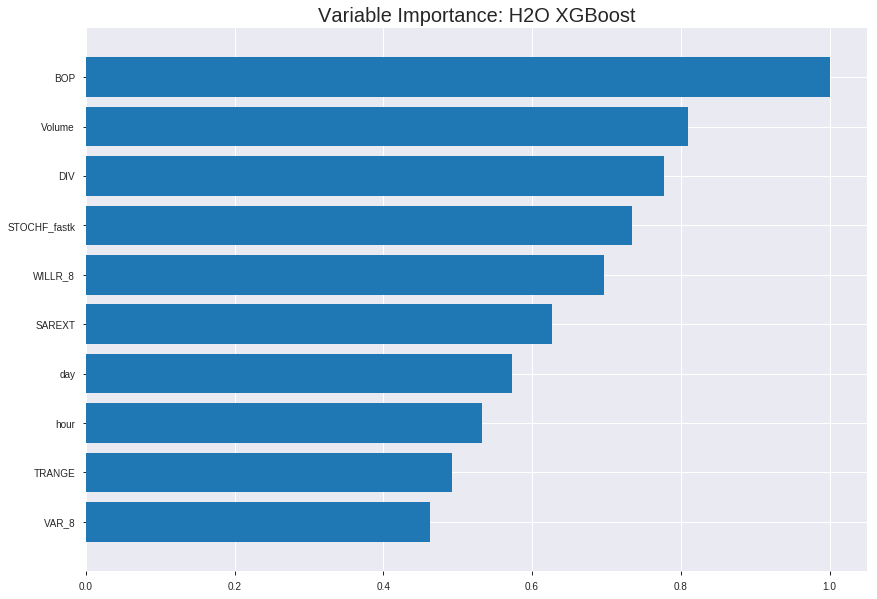

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_185359_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03148603576576976
RMSE: 0.177443049358857
LogLoss: 0.17567135696854744
Mean Per-Class Error: 0.0006693440428380271
AUC: 0.9999975270540289
pr_auc: 0.9986586285709137
Gini: 0.9999950541080578
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5661011338233948: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      812  0    0        (0.0/812.0)
1      1    746  0.0013   (1.0/747.0)
Total  813  746  0.0006   (1.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.566101     0.99933   196
max f2                       0.516177     0.999465  198
max f0point5                 0.566101     0.999732  196
max accuracy                 0.566101     0.999359  196
max precision                0.962421     1         0
max recall                   0.516177     1         198
max specificity              0.962421     1         0
max absolute_mcc             0.566101     0.998716  196
max min_per_class_accuracy   0.566101     0.998661  196
max mean_per_class_accuracy  0.566101     0.999331  196

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.74 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010263                    0.948101           2.08701  2.08701            1                0.952916   1                           0.952916            0.021419        0.021419                   108.701  108.701
    2        0.020526                    0.939672           2.08701  2.08701            1                0.943821   1                           0.948369            0.021419        0.042838                   108.701  108.701
    3        0.0301475                   0.932775           2.08701  2.08701            1                0.936108   1                           0.944456            0.0200803       0.0629183                  108.701  108.701
    4        0.0404105                   0.926539           2.08701  2.08701            1                0.929941   1                           0.940769            0.021419        0.0843373                  108.701  108.701
    5        0.0500321                   0.923287           2.08701  2.08701            1                0.924824   1                           0.937703            0.0200803       0.104418                   108.701  108.701
    6        0.100064                    0.906611           2.08701  2.08701            1                0.915462   1                           0.926582            0.104418        0.208835                   108.701  108.701
    7        0.150096                    0.89048            2.08701  2.08701            1                0.898855   1                           0.91734             0.104418        0.313253                   108.701  108.701
    8        0.200128                    0.867552           2.08701  2.08701            1                0.879703   1                           0.907931            0.104418        0.417671                   108.701  108.701
    9        0.300192                    0.822752           2.08701  2.08701            1                0.846211   1                           0.887357            0.208835        0.626506                   108.701  108.701
    10       0.400257                    0.751995           2.08701  2.08701            1                0.792309   1                           0.863595            0.208835        0.835341                   108.701  108.701
    11       0.500321                    0.317559           1.64553  1.99872            0.788462         0.620673   0.957692                    0.815011            0.164659        1                          64.5531  99.8718
    12       0.599743                    0.204523           0        1.66738            0                0.248154   0.79893                     0.72104             0               1                          -100     66.738
    13       0.699808                    0.148705           0        1.42896            0                0.175405   0.684693                    0.643021            0               1                          -100     42.8964
    14       0.799872                    0.107675           0        1.2502             0                0.127982   0.599038                    0.578589            0               1                          -100     25.02
    15       0.899936                    0.0729709          0        1.11119            0                0.0902103  0.532431                    0.524286            0               1                          -100     11.119
    16       1                           0.0303254          0        1                  0                0.0556923  0.479153                    0.477397            0               1 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19025094064918313
RMSE: 0.4361776480394005
LogLoss: 0.5663699867519997
Mean Per-Class Error: 0.27680894308943094
AUC: 0.780630081300813
pr_auc: 0.7113201315553328
Gini: 0.561260162601626
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32502254843711853: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      138  108  0.439    (108.0/246.0)
1      28   172  0.14     (28.0/200.0)
Total  166  280  0.3049   (136.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325023     0.716667  251
max f2                       0.162409     0.818966  323
max f0point5                 0.570616     0.695093  145
max accuracy                 0.468953     0.721973  190
max precision                0.946866     1         0
max recall                   0.0319265    1         399
max specificity              0.946866     1         0
max absolute_mcc             0.456479     0.444113  194
max min_per_class_accuracy   0.468953     0.719512  190
max mean_per_class_accuracy  0.456479     0.723191  194

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.919521           1.338     1.338              0.6              0.927679   0.6                         0.927679            0.015           0.015                      33.8      33.8
    2        0.0201794                   0.91308            1.6725    1.48667            0.75             0.917621   0.666667                    0.923209            0.015           0.03                       67.25     48.6667
    3        0.0313901                   0.894609           2.23      1.75214            1                0.902527   0.785714                    0.915822            0.025           0.055                      123       75.2143
    4        0.0403587                   0.888863           2.23      1.85833            1                0.890265   0.833333                    0.910143            0.02            0.075                      123       85.8333
    5        0.0515695                   0.878477           1.338     1.74522            0.6              0.883616   0.782609                    0.904376            0.015           0.09                       33.8      74.5217
    6        0.100897                    0.834494           1.92591   1.83356            0.863636         0.850734   0.822222                    0.878151            0.095           0.185                      92.5909   83.3556
    7        0.150224                    0.784028           1.72318   1.79731            0.772727         0.813634   0.80597                     0.856966            0.085           0.27                       72.3182   79.7313
    8        0.201794                    0.738437           1.74522   1.784              0.782609         0.765001   0.8                         0.833464            0.09            0.36                       74.5217   78.4
    9        0.300448                    0.654489           1.36841   1.64754            0.613636         0.694254   0.738806                    0.787753            0.135           0.495                      36.8409   64.7537
    10       0.401345                    0.542829           1.338     1.56972            0.6              0.587395   0.703911                    0.737384            0.135           0.63                       33.8      56.9721
    11       0.5                         0.444459           1.115     1.48               0.5              0.49396    0.663677                    0.689354            0.11            0.74                       11.5      48
    12       0.600897                    0.345591           0.892     1.38127            0.4              0.388093   0.619403                    0.638769            0.09            0.83                       -10.8     38.1269
    13       0.699552                    0.241799           0.658864  1.27939            0.295455         0.29357    0.573718                    0.590087            0.065           0.895                      -34.1136  27.9391
    14       0.800448                    0.167212           0.495556  1.18059            0.222222         0.199822   0.529412                    0.540894            0.05            0.945                      -50.4444  18.0588
    15       0.899103                    0.105322           0.304091  1.08441            0.136364         0.138317   0.486284                    0.496721            0.03            0.975                      -69.5909  8.4414
    16       1                           0.0319265          0.247778  1                  0.111111         0.0653708  0.44843                     0.453199   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:54:12  5.028 sec   0                  0.5              0.693147            0.5             0                  1                0.520847                         0.5                0.693147              0.5               0                    1                  0.55157
    2019-08-27 18:54:12  5.433 sec   5                  0.445371         0.589006            0.975612        0.970579           2.08701          0.0711995                        0.478759           0.651213              0.741006          0.676433             1.338              0.340807
    2019-08-27 18:54:13  5.810 sec   10                 0.39366          0.498295            0.994214        0.990425           2.08701          0.0365619                        0.463625           0.62132               0.754187          0.687945             1.784              0.313901
    2019-08-27 18:54:13  6.167 sec   15                 0.350794         0.427392            0.997143        0.994001           2.08701          0.0230917                        0.449983           0.594278              0.776951          0.713765             2.23               0.275785
    2019-08-27 18:54:13  6.504 sec   20                 0.316919         0.373786            0.998872        0.997381           2.08701          0.0141116                        0.44234            0.578827              0.782663          0.71104              1.338              0.266816
    2019-08-27 18:54:14  6.887 sec   25                 0.28849          0.33004             0.999153        0.997707           2.08701          0.0115459                        0.439013           0.57159               0.779868          0.714171             2.23               0.257848
    2019-08-27 18:54:14  7.267 sec   30                 0.265284         0.295593            0.999652        0.99828            2.08701          0.00898012                       0.435115           0.563075              0.784461          0.715825             1.784              0.269058
    2019-08-27 18:54:14  7.660 sec   35                 0.245438         0.267               0.999836        0.998483           2.08701          0.00641437                       0.434061           0.560488              0.785904          0.71032              1.784              0.293722
    2019-08-27 18:54:15  8.039 sec   40                 0.229867         0.245199            0.999958        0.995938           2.08701          0.00256575                       0.43377            0.559324              0.784329          0.70735              1.338              0.289238
    2019-08-27 18:54:15  8.536 sec   45                 0.215747         0.22548             0.999971        0.994614           2.08701          0.00256575                       0.434593           0.560832              0.781839          0.705841             1.338              0.311659
    2019-08-27 18:54:16  8.990 sec   50                 0.202452         0.207706            0.999998        0.99866            2.08701          0.000641437                      0.435447           0.562627              0.780955          0.708633             1.338              0.29148
    2019-08-27 18:54:16  9.381 sec   55                 0.189663         0.190888            0.999987        0.997308           2.08701          0.000641437                      0.436068           0.56549               0.779746          0.7

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                2740.21435546875       1.0                    0.12114927507198486
Volume             2217.795166015625      0.8093509770830472     0.0980522841524138
DIV                2129.787109375         0.7772337609736636     0.0941613067034317
STOCHF_fastk       2013.017578125         0.7346204774482493     0.08899873829589082
WILLR_8            1910.755615234375      0.6973015127159696     0.08447757277213816
---                ---                    ---                    ---
CDLSTALLEDPATTERN  3.6221907138824463     0.0013218640018630304  0.000160142865569459
CDLPIERCING        3.541187047958374      0.0012923029327581955  0.0001565615634770554
CDL3BLACKCROWS     2.873901128768921      0.0010487869764762626  0.00012705978190503806
CDLLADDERBOTTOM    2.1385326385498047     0.0007804253102615326  9.454796058601354e-05
CDLTHRUSTING       1.3539049625396729     0.0004940872453418227  5.9858311595475755e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.6696428571428571)

('auc', 0.7527986633249791)

('logloss', 0.5788268166106729)

('mean_per_class_error', 0.3051378446115288)

('rmse', 0.44557591991463324)

('mse', 0.19853790040777164)

xgboost prediction progress: |████████████████████████████████████████████| 100%


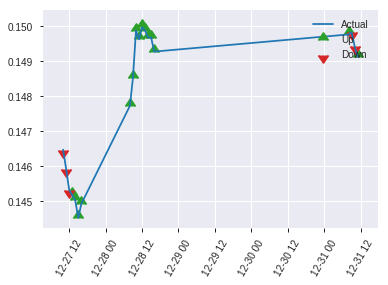


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19853790040777164
RMSE: 0.44557591991463324
LogLoss: 0.5788268166106729
Mean Per-Class Error: 0.3051378446115288
AUC: 0.7527986633249791
pr_auc: 0.6725400297798126
Gini: 0.5055973266499583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33040472865104675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   59   0.4436   (59.0/133.0)
1      15   75   0.1667   (15.0/90.0)
Total  89   134  0.3318   (74.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330405     0.669643  133
max f2                       0.222208     0.791985  163
max f0point5                 0.661834     0.686275  53
max accuracy                 0.661834     0.730942  53
max precision                0.940896     1         0
max recall                   0.06242      1         211
max specificity              0.940896     1         0
max absolute_mcc             0.661834     0.431126  53
max min_per_class_accuracy   0.44644      0.666667  102
max mean_per_class_accuracy  0.330405     0.694862  133

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 44.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.92471            2.47778   2.47778            1                0.935419  1                           0.935419            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.909645           2.47778   2.47778            1                0.918575  1                           0.928681            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.89367            1.23889   2.12381            0.5              0.903733  0.857143                    0.921553            0.0111111       0.0666667                  23.8889   112.381
    4        0.0403587                   0.883868           1.23889   1.92716            0.5              0.886796  0.777778                    0.913829            0.0111111       0.0777778                  23.8889   92.716
    5        0.0538117                   0.882724           2.47778   2.06481            1                0.883288  0.833333                    0.906194            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.83346            1.80202   1.93913            0.727273         0.861752  0.782609                    0.884939            0.0888889       0.2                        80.202    93.913
    7        0.152466                    0.763778           2.25253   2.04052            0.909091         0.796505  0.823529                    0.856328            0.111111        0.311111                   125.253   104.052
    8        0.201794                    0.714364           1.80202   1.98222            0.727273         0.742227  0.8                         0.828437            0.0888889       0.4                        80.202    98.2222
    9        0.300448                    0.599215           0.90101   1.6272             0.363636         0.647147  0.656716                    0.768909            0.0888889       0.488889                   -9.89899  62.7197
    10       0.399103                    0.513652           1.01364   1.47553            0.409091         0.565821  0.595506                    0.718707            0.1             0.588889                   1.36364   47.5531
    11       0.502242                    0.415087           0.861836  1.3495             0.347826         0.461343  0.544643                    0.665856            0.0888889       0.677778                   -13.8164  34.9504
    12       0.600897                    0.329594           1.57677   1.38682            0.636364         0.377618  0.559701                    0.618533            0.155556        0.833333                   57.6768   38.6816
    13       0.699552                    0.241071           0.450505  1.25477            0.181818         0.291849  0.50641                     0.572462            0.0444444       0.877778                   -54.9495  25.4772
    14       0.798206                    0.16901            0.675758  1.18321            0.272727         0.211167  0.477528                    0.527808            0.0666667       0.944444                   -32.4242  18.3208
    15       0.896861                    0.0924404          0.337879  1.09022            0.136364         0.130342  0.44                        0.484086            0.0333333       0.977778                   -66.2121  9.02222
    16       1                           0.0306305          0.215459  1                  0.0869565        0.06248   0.403587                    0.440602           

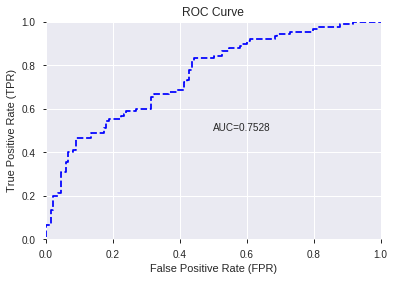

This function is available for GLM models only


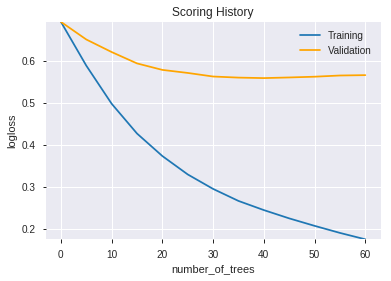

--2019-08-27 18:54:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_185359_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_185359_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'DIV',
 'STOCHF_fastk',
 'WILLR_8',
 'SAREXT',
 'day',
 'hour',
 'TRANGE',
 'VAR_8',
 'STOCHRSI_fastk',
 'SUB',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLDOJI',
 'CDLHAMMER',
 'CORREL_12',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'is_month_end',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLMORNINGSTAR',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190827_185437_model_1  0.742189  0.601987               0.29269  0.452747  0.20498

variable  relative_importance  scaled_importance    percentage
0                          BOP             0.340096           1.000000  3.413723e-02
1                          DIV             0.171979           0.505679  1.726249e-02
2                    CDLHAMMER             0.170587           0.501586  1.712277e-02
3                          SUB             0.154999           0.455752  1.555812e-02
4                  CDLLONGLINE             0.154094           0.453090  1.546725e-02
...                        ...                  ...                ...           ...
1029  BBANDS_middleband_12_2_4             0.000018           0.000052  1.777656e-06
1030                   TRIMA_8             0.000013           0.000037  1.266647e-06
1031   BBANDS_upperband_14_6_3             0.000010           0.000029  1.000168e-06
1032   BBANDS_upperband_20_5_4             0.000008           0.000025  8.483409e-07
1033                  MAVP_8_6             0.000002           0.000006  2.099585e-07

[1034 rows x 4 columns]

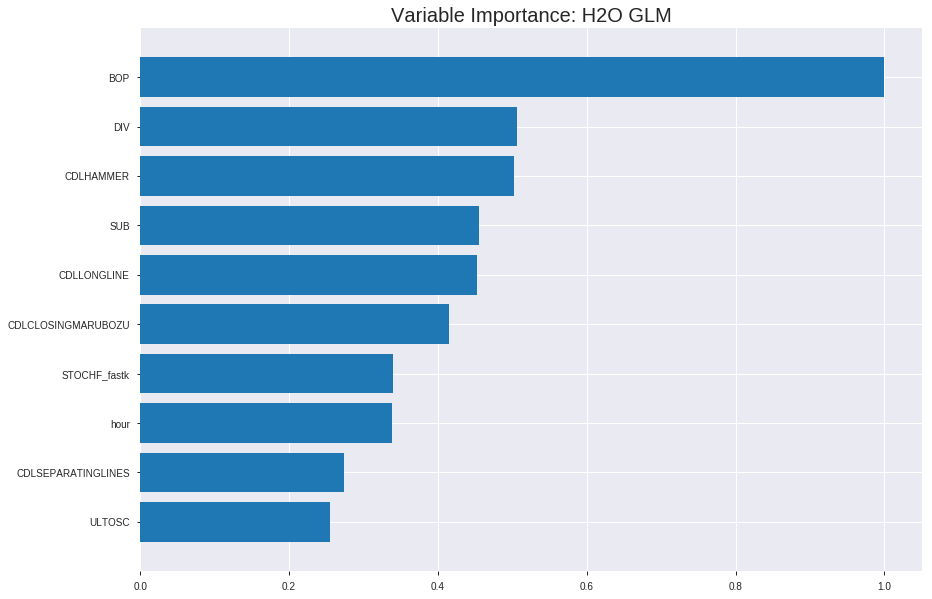

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_185437_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.18921409823234106
RMSE: 0.4349874690520878
LogLoss: 0.5594377328232452
Null degrees of freedom: 1558
Residual degrees of freedom: 524
Null deviance: 2158.5220527111505
Residual deviance: 1744.3268509428785
AIC: 3814.3268509428785
AUC: 0.789218450155301
pr_auc: 0.7773717433309045
Gini: 0.578436900310602
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46208552236469264: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      543  269  0.3313   (269.0/812.0)
1      179  568  0.2396   (179.0/747.0)
Total  722  837  0.2874   (448.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462086     0.717172  212
max f2                       0.258053     0.8378    316
max f0point5                 0.53116      0.716949  177
max accuracy                 0.515397     0.723541  184
max precision                0.943892     1         0
max recall                   0.0573575    1         391
max specificity              0.943892     1         0
max absolute_mcc             0.515397     0.44563   184
max min_per_class_accuracy   0.495495     0.717537  194
max mean_per_class_accuracy  0.515397     0.722443  184

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.88873            2.08701   2.08701            1                0.909621  1                           0.909621            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.868064           2.08701   2.08701            1                0.876874  1                           0.893248            0.021419        0.042838                   108.701   108.701
    3        0.0301475                   0.848736           1.80875   1.99821            0.866667         0.858721  0.957447                    0.882229            0.0174029       0.060241                   80.8746   99.8206
    4        0.0404105                   0.833022           1.95658   1.98763            0.9375           0.842     0.952381                    0.872012            0.0200803       0.0803213                  95.6576   98.7633
    5        0.0500321                   0.812521           1.80875   1.95323            0.866667         0.823893  0.935897                    0.862758            0.0174029       0.0977242                  80.8746   95.3232
    6        0.100064                    0.740956           1.79269   1.87296            0.858974         0.771385  0.897436                    0.817072            0.0896921       0.187416                   79.2692   87.2962
    7        0.150096                    0.701596           1.76594   1.83729            0.846154         0.720284  0.880342                    0.784809            0.0883534       0.27577                    76.5936   83.7286
    8        0.200128                    0.66794            1.57864   1.77262            0.75641          0.683104  0.849359                    0.759383            0.0789826       0.354752                   57.8639   77.2625
    9        0.300192                    0.603088           1.4181    1.65445            0.679487         0.635152  0.792735                    0.717973            0.141901        0.496653                   41.81     65.445
    10       0.400257                    0.549726           1.19067   1.5385             0.570513         0.579117  0.737179                    0.683259            0.119143        0.615797                   19.0669   53.8504
    11       0.500321                    0.487966           1.12378   1.45556            0.538462         0.520968  0.697436                    0.650801            0.11245         0.728246                   12.3777   45.5559
    12       0.599743                    0.423534           0.70016   1.33033            0.335484         0.452642  0.637433                    0.617951            0.0696118       0.797858                   -29.984   33.0332
    13       0.699808                    0.360923           0.78932   1.25297            0.378205         0.39467   0.600367                    0.586024            0.0789826       0.876841                   -21.068   25.2974
    14       0.799872                    0.284608           0.682293  1.18158            0.326923         0.324066  0.566159                    0.553253            0.0682731       0.945114                   -31.7707  18.1582
    15       0.899936                    0.179366           0.347836  1.08888            0.166667         0.236848  0.521739                    0.518072            0.0348059       0.97992                    -65.2164  8.88772
    16       1                           0.00232197         0.200674  1                  0.0961538        0.129134  0.479153                    0.479153          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19407645997663336
RMSE: 0.44054109907775163
LogLoss: 0.5762170602133312
Null degrees of freedom: 445
Residual degrees of freedom: -589
Null deviance: 615.2252417868635
Residual deviance: 513.9856177102914
AIC: 2583.9856177102915
AUC: 0.7721747967479675
pr_auc: 0.7257066066353376
Gini: 0.544349593495935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3320094890964035: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  131  0.5325   (131.0/246.0)
1      19   181  0.095    (19.0/200.0)
Total  134  312  0.3363   (150.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.332009     0.707031  274
max f2                       0.216574     0.82483   334
max f0point5                 0.554557     0.686528  128
max accuracy                 0.528004     0.713004  158
max precision                0.91705      1         0
max recall                   0.00694335   1         399
max specificity              0.91705      1         0
max absolute_mcc             0.521656     0.416326  161
max min_per_class_accuracy   0.470259     0.68      188
max mean_per_class_accuracy  0.521656     0.705711  161

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 45.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.883618           2.23      2.23               1                0.903311  1                           0.903311            0.025           0.025                      123       123
    2        0.0201794                   0.846157           2.23      2.23               1                0.857072  1                           0.88276             0.02            0.045                      123       123
    3        0.0313901                   0.83127            1.784     2.07071            0.8              0.841428  0.928571                    0.867999            0.02            0.065                      78.4      107.071
    4        0.0403587                   0.798389           1.115     1.85833            0.5              0.821636  0.833333                    0.857696            0.01            0.075                      11.5      85.8333
    5        0.0515695                   0.788442           2.23      1.93913            1                0.793983  0.869565                    0.843845            0.025           0.1                        123       93.913
    6        0.100897                    0.733562           1.82455   1.88311            0.818182         0.75449   0.844444                    0.80016             0.09            0.19                       82.4545   88.3111
    7        0.150224                    0.682087           1.92591   1.89716            0.863636         0.705123  0.850746                    0.768954            0.095           0.285                      92.5909   89.7164
    8        0.201794                    0.637217           1.45435   1.784              0.652174         0.656324  0.8                         0.740171            0.075           0.36                       45.4348   78.4
    9        0.300448                    0.562946           1.41909   1.66418            0.636364         0.595296  0.746269                    0.6926              0.14            0.5                        41.9091   66.4179
    10       0.401345                    0.526191           1.23889   1.55726            0.555556         0.542491  0.698324                    0.654863            0.125           0.625                      23.8889   55.7263
    11       0.5                         0.459025           0.658864  1.38               0.295455         0.488046  0.618834                    0.621949            0.065           0.69                       -34.1136  38
    12       0.600897                    0.385361           1.18933   1.34799            0.533333         0.420818  0.604478                    0.588177            0.12            0.81                       18.9333   34.7985
    13       0.699552                    0.331812           0.962955  1.29369            0.431818         0.358548  0.580128                    0.555793            0.095           0.905                      -3.70455  29.3686
    14       0.800448                    0.256889           0.346889  1.17434            0.155556         0.296875  0.526611                    0.523156            0.035           0.94                       -65.3111  17.4342
    15       0.899103                    0.156251           0.456136  1.09554            0.204545         0.210678  0.491272                    0.488869            0.045           0.985                      -54.3864  9.55362
    16       1                           0.00694335         0.148667  1                  0.0666667        0.107908  0.44843                     0.450432            0.015         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 18:54:41  0.000 sec   2            .18E2     1034          1.3589121266596558  1.3603036023606718
     2019-08-27 18:54:43  2.044 sec   4            .13E2     1034          1.3523716596206352  1.3542265446504227
     2019-08-27 18:54:45  3.996 sec   6            .93E1     1034          1.3443019099535927  1.3463452742542956
     2019-08-27 18:54:47  5.935 sec   8            .68E1     1034          1.3344255152819742  1.3363663590781056
     2019-08-27 18:54:49  7.886 sec   10           .49E1     1034          1.3225527649760749  1.3241473647099047
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 18:55:16  35.314 sec  38           .58E-1    1035          1.109339155050902   1.1525305283888014
     2019-08-27 18:55:18  37.245 sec  40           .42E-1    1035          1.1005932510135354  1.1549695444293069
     2019-08-27 18:55:20  39.197 sec  42           .31E-1    1035          1.0925201361830752  1.1597956225202826
     2019-08-27 18:55:22  41.084 sec  44           .22E-1    1035          1.0850377435472023  1.1672121453898454
     2019-08-27 18:55:24  43.019 sec  46           .16E-1    1035          1.0780119434692816  1.1776297591428877


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7130044843049327)

('F1', 0.6559139784946236)

('auc', 0.7421888053467001)

('logloss', 0.6019871695661547)

('mean_per_class_error', 0.2926900584795322)

('rmse', 0.4527474579072585)

('mse', 0.20498026064148483)

glm prediction progress: |████████████████████████████████████████████████| 100%


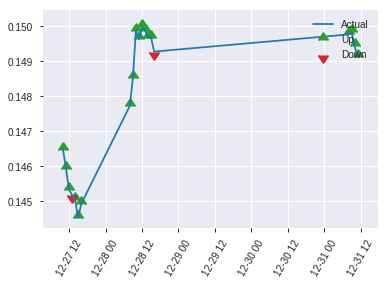


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20498026064148483
RMSE: 0.4527474579072585
LogLoss: 0.6019871695661547
Null degrees of freedom: 222
Residual degrees of freedom: -812
Null deviance: 305.94391779285456
Residual deviance: 268.486277626505
AIC: 2338.486277626505
AUC: 0.7421888053467001
pr_auc: 0.6612612599059059
Gini: 0.48437761069340013
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5328079573661816: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      98   35   0.2632   (35.0/133.0)
1      29   61   0.3222   (29.0/90.0)
Total  127  96   0.287    (64.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.532808     0.655914  95
max f2                       0.130481     0.786219  205
max f0point5                 0.627701     0.644654  56
max accuracy                 0.532808     0.713004  95
max precision                0.950258     1         0
max recall                   0.0104476    1         222
max specificity              0.950258     1         0
max absolute_mcc             0.532808     0.410828  95
max min_per_class_accuracy   0.532808     0.677778  95
max mean_per_class_accuracy  0.532808     0.70731   95

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 47.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.888968           2.47778   2.47778            1                0.924828   1                           0.924828            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.874705           1.23889   1.98222            0.5              0.879014   0.8                         0.906503            0.0111111       0.0444444                  23.8889   98.2222
    3        0.0313901                   0.858494           2.47778   2.12381            1                0.867267   0.857143                    0.895292            0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.853048           2.47778   2.20247            1                0.855979   0.888889                    0.886556            0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.835447           1.65185   2.06481            0.666667         0.845146   0.833333                    0.876204            0.0222222       0.111111                   65.1852   106.481
    6        0.103139                    0.77452            2.25253   2.15459            0.909091         0.796731   0.869565                    0.838195            0.111111        0.222222                   125.253   115.459
    7        0.152466                    0.727202           1.35152   1.89477            0.545455         0.744431   0.764706                    0.80786             0.0666667       0.288889                   35.1515   89.4771
    8        0.201794                    0.668016           1.35152   1.76198            0.545455         0.693981   0.711111                    0.780023            0.0666667       0.355556                   35.1515   76.1975
    9        0.300448                    0.601659           1.35152   1.6272             0.545455         0.631012   0.656716                    0.731094            0.133333        0.488889                   35.1515   62.7197
    10       0.399103                    0.552146           1.23889   1.53121            0.5              0.578763   0.617978                    0.693439            0.122222        0.611111                   23.8889   53.1211
    11       0.502242                    0.482495           0.969565  1.41587            0.391304         0.51365    0.571429                    0.656518            0.1             0.711111                   -3.04348  41.5873
    12       0.600897                    0.410558           0.90101   1.33134            0.363636         0.452422   0.537313                    0.62301             0.0888889       0.8                        -9.89899  33.1343
    13       0.699552                    0.344263           0.450505  1.20712            0.181818         0.376322   0.487179                    0.58822             0.0444444       0.844444                   -54.9495  20.7123
    14       0.798206                    0.25962            0.788384  1.15537            0.318182         0.296426   0.466292                    0.552156            0.0777778       0.922222                   -21.1616  15.5368
    15       0.896861                    0.152929           0.450505  1.07783            0.181818         0.200391   0.435                       0.513462            0.0444444       0.966667                   -54.9495  7.78333
    16       1                           0.0104476          0.323188  1                  0.130435         0.0942248  0.403587                   

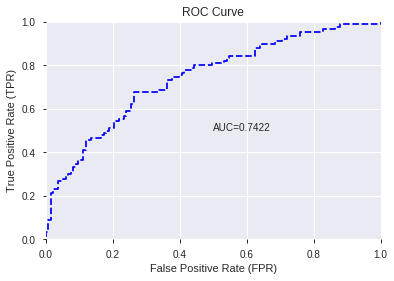

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


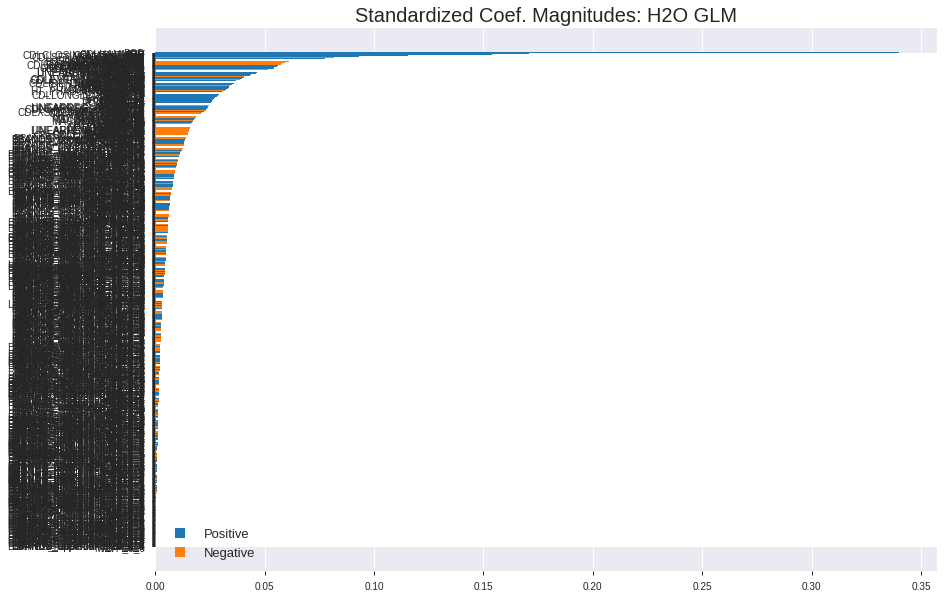

'log_likelihood'
--2019-08-27 18:55:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_185437_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_185437_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

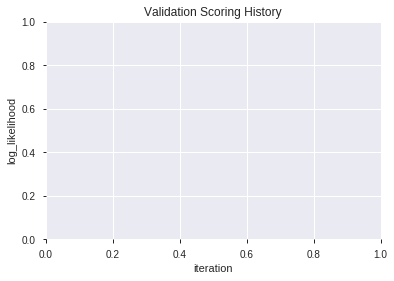

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_2_AutoML_20190827_185600  0.765246  0.570305              0.277360  0.441048  0.194523
1  XGBoost_grid_1_AutoML_20190827_185600_model_2  0.757477  0.578113              0.290602  0.445080  0.198096
2               XGBoost_3_AutoML_20190827_185600  0.757143  0.576977              0.305472  0.444721  0.197777
3  XGBoost_grid_1_AutoML_20190827_185600_model_3  0.756558  0.575595              0.316750  0.444263  0.197370
4  XGBoost_grid_1_AutoML_20190827_185600_model_6  0.756307  0.572691              0.313158  0.443157  0.196388
5  XGBoost_grid_1_AutoML_20190827_185600_model_7  0.754637  0.577482              0.303175  0.445294  0.198287
6  XGBoost_grid_1_AutoML_20190827_185600_model_5  0.747786  0.585745              0.356642  0.449076  0.201669
7               XGBoost_1_AutoML_20190827_185600  0.746449  0.584663              0.291061  0.448238  0.200917
8  XGBoost_grid_1_AutoML_20190827_185600_model_1  0.739766  0.588959              0.333584  0.450874  0.203288
9  XGBoost_grid_1_AutoML_20190827_185600_model_4  0.735923  0.592961              0.316082  0.451549  0.203896

variable  relative_importance  scaled_importance  percentage
0                        BOP          1268.334961           1.000000    0.163023
1                        DIV           499.817719           0.394074    0.064243
2               STOCHF_fastk           354.450653           0.279461    0.045559
3                       hour           311.208282           0.245368    0.040000
4                        SUB           189.938095           0.149754    0.024413
..                       ...                  ...                ...         ...
250  BBANDS_lowerband_20_1_2             1.123856           0.000886    0.000144
251                      OBV             0.865185           0.000682    0.000111
252   LINEARREG_INTERCEPT_30             0.854543           0.000674    0.000110
253              aroondown_8             0.817516           0.000645    0.000105
254  BBANDS_upperband_30_1_3             0.795341           0.000627    0.000102

[255 rows x 4 columns]

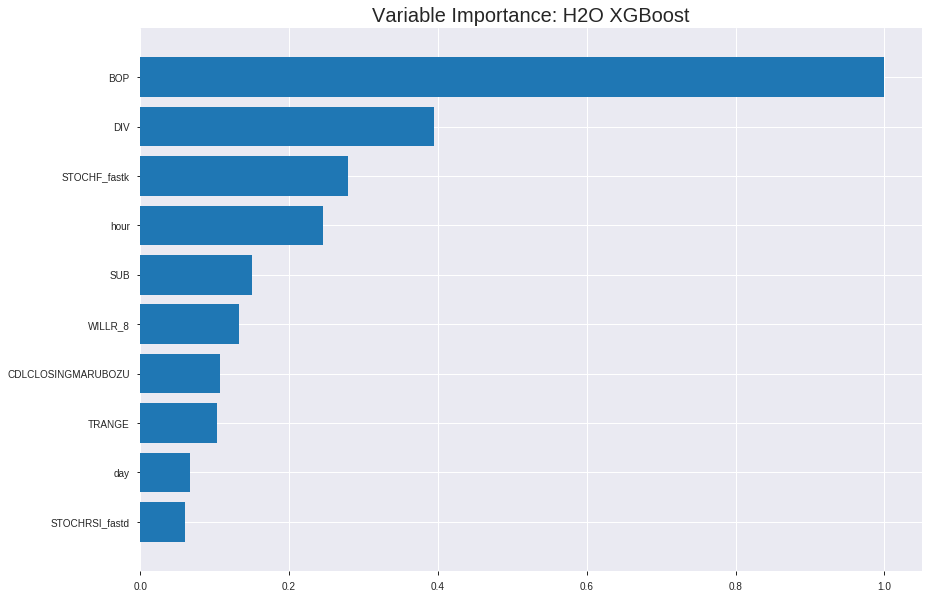

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20190827_185600


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12778794371437618
RMSE: 0.3574743958864413
LogLoss: 0.420901005839054
Mean Per-Class Error: 0.1402382930737729
AUC: 0.935671256454389
pr_auc: 0.92922426247399
Gini: 0.871342512908778
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.511465827624003: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      714  98   0.1207   (98.0/812.0)
1      122  625  0.1633   (122.0/747.0)
Total  836  723  0.1411   (220.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.511466     0.85034   184
max f2                       0.372187     0.905542  253
max f0point5                 0.551348     0.871382  167
max accuracy                 0.524897     0.86145   177
max precision                0.91489      1         0
max recall                   0.190258     1         344
max specificity              0.91489      1         0
max absolute_mcc             0.524897     0.723365  177
max min_per_class_accuracy   0.497938     0.854083  192
max mean_per_class_accuracy  0.524897     0.859762  177

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 48.14 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.880368           2.08701    2.08701            1                0.898275  1                           0.898275            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.868932           2.08701    2.08701            1                0.874239  1                           0.886257            0.021419        0.042838                   108.701   108.701
    3        0.0301475                   0.856832           2.08701    2.08701            1                0.862611  1                           0.878711            0.0200803       0.0629183                  108.701   108.701
    4        0.0404105                   0.847596           2.08701    2.08701            1                0.851392  1                           0.871773            0.021419        0.0843373                  108.701   108.701
    5        0.0500321                   0.835261           2.08701    2.08701            1                0.841416  1                           0.865935            0.0200803       0.104418                   108.701   108.701
    6        0.100064                    0.798278           2.06026    2.07364            0.987179         0.816905  0.99359                     0.84142             0.103079        0.207497                   106.026   107.364
    7        0.150096                    0.761889           2.06026    2.06918            0.987179         0.778706  0.991453                    0.820515            0.103079        0.310576                   106.026   106.918
    8        0.200128                    0.726571           1.95323    2.04019            0.935897         0.742769  0.977564                    0.801079            0.0977242       0.4083                     95.3232   104.019
    9        0.300192                    0.654192           1.85958    1.97999            0.891026         0.690064  0.948718                    0.764074            0.186078        0.594378                   85.9584   97.9988
    10       0.400257                    0.56652            1.6054     1.88634            0.769231         0.606946  0.903846                    0.724792            0.160643        0.75502                    60.5396   88.634
    11       0.500321                    0.485766           1.09702    1.72848            0.525641         0.522641  0.828205                    0.684362            0.109772        0.864793                   9.70206   72.8476
    12       0.599743                    0.396502           0.794412   1.57363            0.380645         0.441998  0.754011                    0.644184            0.0789826       0.943775                   -20.5588  57.3631
    13       0.699808                    0.316224           0.347836   1.39836            0.166667         0.354984  0.670027                    0.602832            0.0348059       0.978581                   -65.2164  39.8357
    14       0.799872                    0.240194           0.16054    1.24351            0.0769231        0.27648   0.59583                     0.562005            0.0160643       0.994645                   -83.946   24.3506
    15       0.899936                    0.158847           0.0535132  1.11119            0.025641         0.19854   0.532431                    0.521591            0.00535475      1                          -94.6487  11.119
    16       1                           0.0501497          0          1                  0                0.120212  0.479153                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.18929205195664753
RMSE: 0.43507706438819266
LogLoss: 0.5595111630326388
Mean Per-Class Error: 0.27839430894308936
AUC: 0.7840345528455285
pr_auc: 0.7026462464382217
Gini: 0.568069105691057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4123093783855438: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      157  89   0.3618   (89.0/246.0)
1      39   161  0.195    (39.0/200.0)
Total  196  250  0.287    (128.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412309     0.715556  220
max f2                       0.233578     0.842648  321
max f0point5                 0.575763     0.691748  139
max accuracy                 0.469578     0.717489  187
max precision                0.89048      1         0
max recall                   0.101568     1         394
max specificity              0.89048      1         0
max absolute_mcc             0.412309     0.444115  220
max min_per_class_accuracy   0.461579     0.711382  190
max mean_per_class_accuracy  0.412309     0.721606  220

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 46.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.861727           1.338      1.338              0.6              0.880438  0.6                         0.880438            0.015           0.015                      33.8      33.8
    2        0.0201794                   0.844177           1.6725     1.48667            0.75             0.853036  0.666667                    0.868259            0.015           0.03                       67.25     48.6667
    3        0.0313901                   0.832055           1.784      1.59286            0.8              0.838897  0.714286                    0.857773            0.02            0.05                       78.4      59.2857
    4        0.0403587                   0.822595           2.23       1.73444            1                0.827395  0.777778                    0.851022            0.02            0.07                       123       73.4444
    5        0.0515695                   0.813475           2.23       1.84217            1                0.818948  0.826087                    0.844049            0.025           0.095                      123       84.2174
    6        0.100897                    0.762204           1.82455    1.83356            0.818182         0.783855  0.822222                    0.814621            0.09            0.185                      82.4545   83.3556
    7        0.150224                    0.725936           1.52045    1.73075            0.681818         0.741128  0.776119                    0.790489            0.075           0.26                       52.0455   73.0746
    8        0.201794                    0.68067            1.5513     1.68489            0.695652         0.705679  0.755556                    0.768816            0.08            0.34                       55.1304   68.4889
    9        0.300448                    0.610746           1.46977    1.61425            0.659091         0.644888  0.723881                    0.728123            0.145           0.485                      46.9773   61.4254
    10       0.401345                    0.539607           1.338      1.5448             0.6              0.574459  0.692737                    0.689492            0.135           0.62                       33.8      54.4804
    11       0.5                         0.437622           1.21636    1.48               0.545455         0.491712  0.663677                    0.650468            0.12            0.74                       21.6364   48
    12       0.600897                    0.394208           0.892      1.38127            0.4              0.416349  0.619403                    0.611157            0.09            0.83                       -10.8     38.1269
    13       0.699552                    0.315348           0.760227   1.29369            0.340909         0.347865  0.580128                    0.574026            0.075           0.905                      -23.9773  29.3686
    14       0.800448                    0.244323           0.594667   1.20557            0.266667         0.280696  0.540616                    0.537052            0.06            0.965                      -40.5333  20.5574
    15       0.899103                    0.162755           0.253409   1.1011             0.113636         0.198395  0.493766                    0.499893            0.025           0.99                       -74.6591  10.1097
    16       1                           0.0726398          0.0991111  1                  0.0444444        0.126174  0.44843                     0.46218


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 18:56:07  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.520847                         0.5                0.693147              0.5               0                    1                  0.55157
    2019-08-27 18:56:07  0.722 sec   5                  0.474681         0.643504            0.837002        0.818828           2.08701          0.246312                         0.479982           0.6537                0.781352          0.724541             2.007              0.313901
    2019-08-27 18:56:08  1.217 sec   10                 0.456337         0.608265            0.854149        0.84029            2.08701          0.236049                         0.467077           0.628382              0.775488          0.714479             2.23               0.307175
    2019-08-27 18:56:08  1.779 sec   15                 0.44125          0.579403            0.865263        0.854241           2.08701          0.235407                         0.458584           0.611553              0.77753           0.707338             1.85833            0.298206
    2019-08-27 18:56:09  2.293 sec   20                 0.429557         0.556971            0.871894        0.85644            2.08701          0.228993                         0.451292           0.596881              0.781463          0.711736             2.23               0.273543
    2019-08-27 18:56:09  2.807 sec   25                 0.419195         0.536952            0.877219        0.861694           2.08701          0.221296                         0.446483           0.586824              0.782297          0.713403             2.23               0.269058
    2019-08-27 18:56:10  3.333 sec   30                 0.410388         0.519901            0.884536        0.874432           2.08701          0.205901                         0.443339           0.579748              0.781047          0.704786             2.23               0.302691
    2019-08-27 18:56:10  3.873 sec   35                 0.40222          0.50407             0.891418        0.883203           2.08701          0.200128                         0.440742           0.574007              0.783364          0.706909             2.23               0.273543
    2019-08-27 18:56:11  4.414 sec   40                 0.394621         0.489488            0.89883         0.892682           2.08701          0.183451                         0.439054           0.570053              0.782927          0.704563             2.23               0.269058
    2019-08-27 18:56:12  4.999 sec   45                 0.38724          0.475375            0.905857        0.899641           2.08701          0.180244                         0.437865           0.566875              0.782154          0.704941             2.23               0.2713
    2019-08-27 18:56:12  5.508 sec   50                 0.38065          0.462945            0.912462        0.905721           2.08701          0.171905                         0.436827           0.564142              0.782378          0.704122             2.23               0.278027
    2019-08-27 18:56:13  6.064 sec   55                 0.374335         0.451414            0.919526        0.91373            2.08701          0.161642                         0.436702           0.563548              0.780488          0.69

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1268.3349609375        1.0                    0.16302260966723675
DIV                      499.8177185058594      0.39407391099305117    0.06424295737186157
STOCHF_fastk             354.4506530761719      0.27946139150353216    0.04555852534414316
hour                     311.2082824707031      0.24536758195222422    0.04000046353759117
SUB                      189.93809509277344     0.1497538906854536     0.024413270067364743
---                      ---                    ---                    ---
BBANDS_lowerband_20_1_2  1.1238555908203125     0.0008860873707917076  0.00014445227557964463
OBV                      0.8651847839355469     0.0006821421868683953  0.00011120459946740166
LINEARREG_INTERCEPT_30   0.8545427322387695     0.0006737516181112972  0.00010983674705202716
aroondown_8              0.8175163269042969     0.000644558694731574   0.000105077640498849
BBANDS_upperband_30_1_3  0.7953414916992188     0.0006270752728532655  0.0001022274474383339


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.6986899563318778)

('auc', 0.7652464494569757)

('logloss', 0.5703054139339415)

('mean_per_class_error', 0.27736006683375103)

('rmse', 0.4410480200300253)

('mse', 0.1945233559724056)

xgboost prediction progress: |████████████████████████████████████████████| 100%


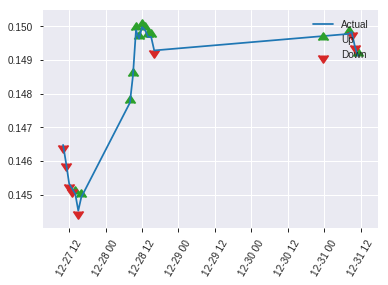


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.1945233559724056
RMSE: 0.4410480200300253
LogLoss: 0.5703054139339415
Mean Per-Class Error: 0.27736006683375103
AUC: 0.7652464494569757
pr_auc: 0.6674326290031743
Gini: 0.5304928989139515
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3368867337703705: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   59   0.4436   (59.0/133.0)
1      10   80   0.1111   (10.0/90.0)
Total  84   139  0.3094   (69.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.336887     0.69869   138
max f2                       0.299545     0.805825  154
max f0point5                 0.659958     0.644654  56
max accuracy                 0.659958     0.70852   56
max precision                0.880434     1         0
max recall                   0.103105     1         219
max specificity              0.880434     1         0
max absolute_mcc             0.336887     0.450851  138
max min_per_class_accuracy   0.471353     0.666667  103
max mean_per_class_accuracy  0.336887     0.72264   138

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 45.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.842415           2.47778   2.47778            1                0.866746  1                           0.866746            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.8334             2.47778   2.47778            1                0.837596  1                           0.855086            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.827546           1.23889   2.12381            0.5              0.829732  0.857143                    0.847842            0.0111111       0.0666667                  23.8889   112.381
    4        0.0403587                   0.822449           1.23889   1.92716            0.5              0.826221  0.777778                    0.843037            0.0111111       0.0777778                  23.8889   92.716
    5        0.0538117                   0.804578           2.47778   2.06481            1                0.813262  0.833333                    0.835594            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.759506           1.80202   1.93913            0.727273         0.781975  0.782609                    0.80995             0.0888889       0.2                        80.202    93.913
    7        0.152466                    0.714987           1.80202   1.89477            0.727273         0.728915  0.764706                    0.783733            0.0888889       0.288889                   80.202    89.4771
    8        0.201794                    0.690751           1.57677   1.81704            0.636364         0.702874  0.733333                    0.763967            0.0777778       0.366667                   57.6768   81.7037
    9        0.300448                    0.626691           1.35152   1.66418            0.545455         0.660129  0.671642                    0.729871            0.133333        0.5                        35.1515   66.4179
    10       0.399103                    0.530659           1.01364   1.50337            0.409091         0.579174  0.606742                    0.69262             0.1             0.6                        1.36364   50.3371
    11       0.502242                    0.453648           0.969565  1.39375            0.391304         0.487247  0.5625                      0.650445            0.1             0.7                        -3.04348  39.375
    12       0.600897                    0.35691            1.46414   1.40531            0.590909         0.408421  0.567164                    0.61071             0.144444        0.844444                   46.4141   40.5307
    13       0.699552                    0.290144           0.788384  1.3183             0.318182         0.32315   0.532051                    0.570157            0.0777778       0.922222                   -21.1616  31.8305
    14       0.798206                    0.213083           0.225253  1.18321            0.0909091        0.251489  0.477528                    0.530771            0.0222222       0.944444                   -77.4747  18.3208
    15       0.896861                    0.143735           0.337879  1.09022            0.136364         0.180146  0.44                        0.492202            0.0333333       0.977778                   -66.2121  9.02222
    16       1                           0.081421           0.215459  1                  0.0869565        0.119717  0.403587                    0.453784            

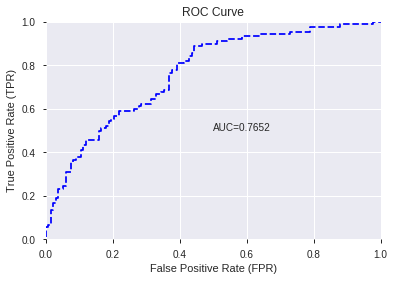

This function is available for GLM models only


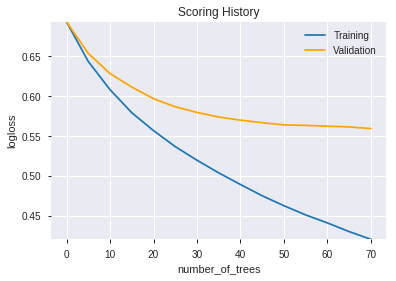

--2019-08-27 18:57:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip


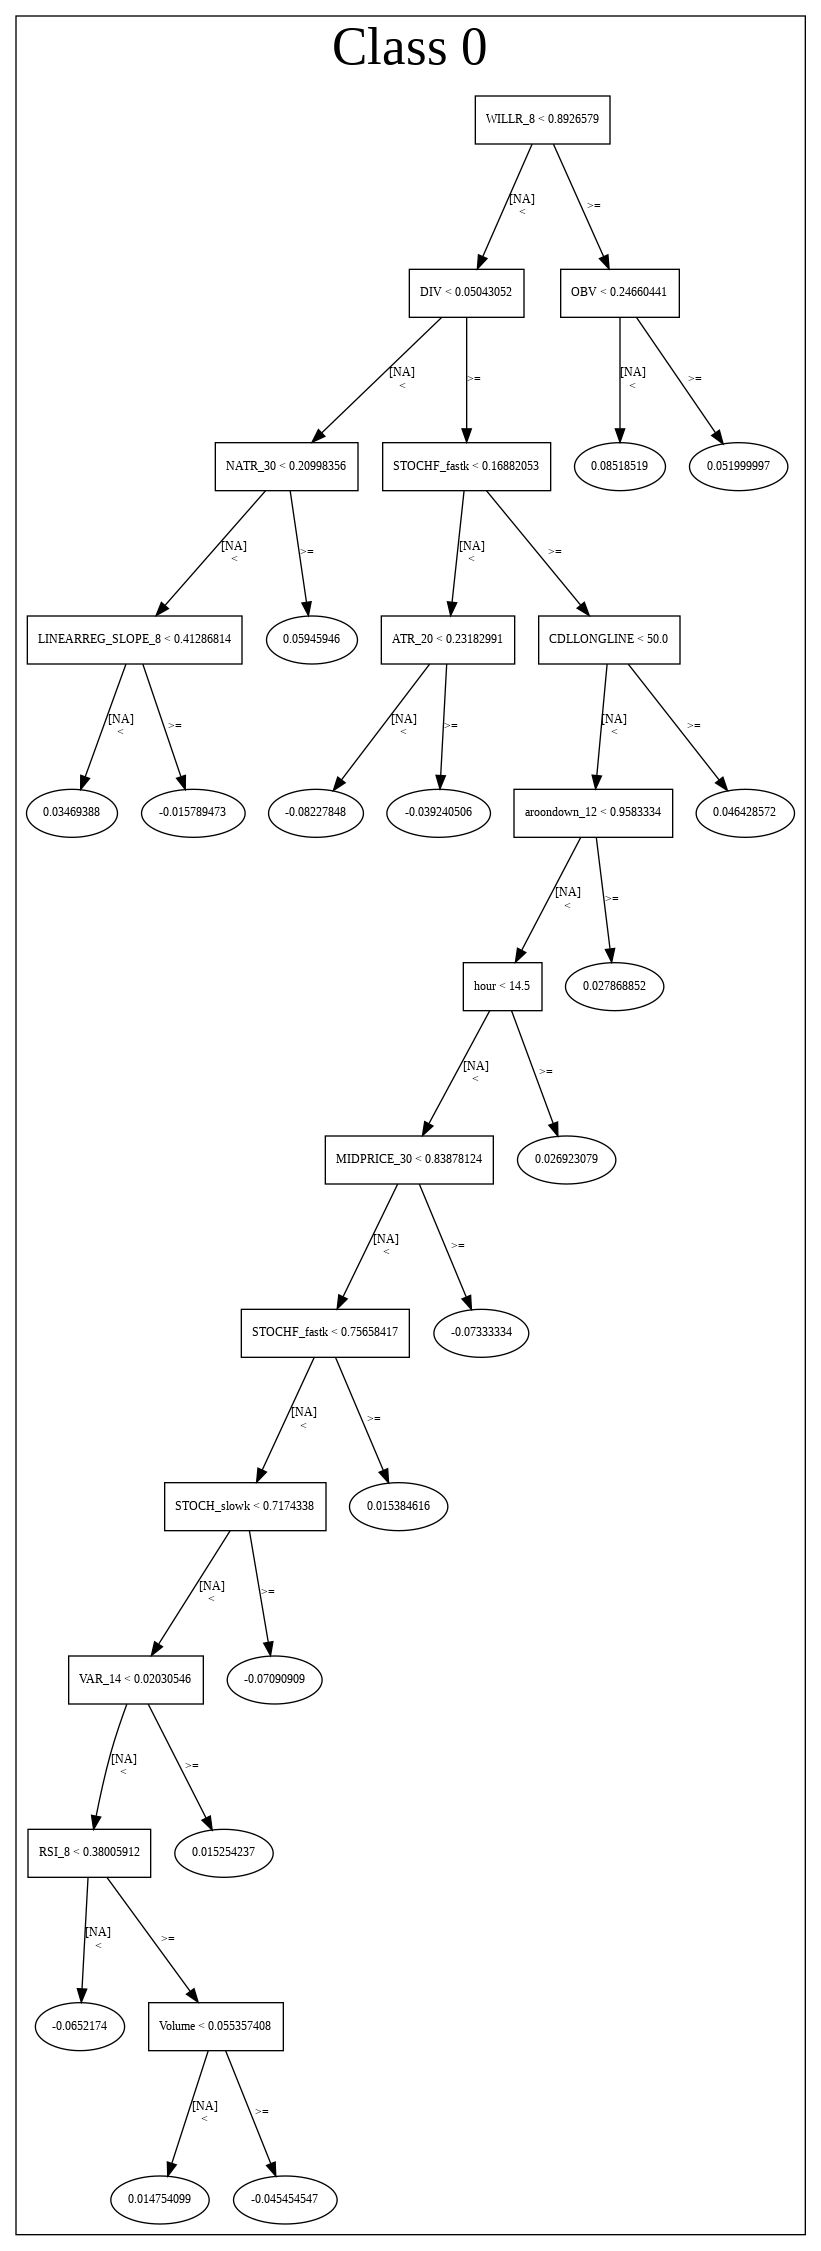

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_2_AutoML_20190827_185600',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_2_AutoML_20190827_185600',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_af9a',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_185719_model_8  0.740184  0.601893              0.339140  0.452811  0.205038
1  DeepLearning_grid_1_AutoML_20190827_185719_model_5  0.729156  0.659058              0.360067  0.469812  0.220723
2  DeepLearning_grid_1_AutoML_20190827_185719_model_9  0.728906  0.606552              0.325397  0.456546  0.208434
3  DeepLearning_grid_1_AutoML_20190827_185719_model_6  0.717711  0.672288              0.367586  0.472050  0.222831
4  DeepLearning_grid_1_AutoML_20190827_185719_model_3  0.705514  0.800107              0.344528  0.485592  0.235800
5  DeepLearning_grid_1_AutoML_20190827_185719_model_7  0.704595  0.821296              0.367419  0.489894  0.239996
6               DeepLearning_1_AutoML_20190827_185719  0.703258  0.647284              0.358605  0.472271  0.223040
7  DeepLearning_grid_1_AutoML_20190827_185719_model_4  0.693400  0.880755              0.415330  0.513564  0.263748
8  DeepLearning_grid_1_AutoML_20190827_185719_model_1  0.677778  0.995237              0.360860  0.502901  0.252910
9  DeepLearning_grid_1_AutoML_20190827_185719_model_2  0.667084  0.838602              0.382456  0.504544  0.254564

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.031856
1                  hour             0.883263           0.883263    0.028138
2           CDLLONGLINE             0.774150           0.774150    0.024662
3                   SUB             0.763495           0.763495    0.024322
4    CDLCLOSINGMARUBOZU             0.756466           0.756466    0.024098
5                   DIV             0.738862           0.738862    0.023537
6          HT_TRENDMODE             0.725737           0.725737    0.023119
7                SAREXT             0.697854           0.697854    0.022231
8                Volume             0.692281           0.692281    0.022054
9                TRANGE             0.691198           0.691198    0.022019
10        days_in_month             0.663413           0.663413    0.021134
11             CORREL_8             0.652304           0.652304    0.020780
12            CDLHAMMER             0.643519           0.643519    0.020500
13       CDLRICKSHAWMAN             0.635907           0.635907    0.020258
14      CDLSHOOTINGSTAR             0.635499           0.635499    0.020245
15    CDLDARKCLOUDCOVER             0.635422           0.635422    0.020242
16            CDLTAKURI             0.632325           0.632325    0.020144
17         STOCHF_fastk             0.630704           0.630704    0.020092
18      CDLLADDERBOTTOM             0.628484           0.628484    0.020021
19         CDLTHRUSTING             0.622303           0.622303    0.019824
20   CDLSEPARATINGLINES             0.621909           0.621909    0.019812
21                VAR_8             0.621874           0.621874    0.019811
22    CDLSTALLEDPATTERN             0.617767           0.617767    0.019680
23       STOCHRSI_fastk             0.616287           0.616287    0.019633
24     CDLDRAGONFLYDOJI             0.614583           0.614583    0.019578
25              WILLR_8             0.609454           0.609454    0.019415
26    CDLLONGLEGGEDDOJI             0.608523           0.608523    0.019385
27              CDLDOJI             0.603727           0.603727    0.019233
28                  day             0.602661           0.602661    0.019199
29   CDLEVENINGDOJISTAR             0.602154           0.602154    0.019182
30         CDLTASUKIGAP             0.600025           0.600025    0.019115
31  CDLGAPSIDESIDEWHITE             0.587577           0.587577    0.018718
32       is_month_start             0.580514           0.580514    0.018493
33        CDLHANGINGMAN             0.579765           0.579765    0.018469
34        CDLHIKKAKEMOD             0.578908           0.578908    0.018442
35            CORREL_14             0.577190           0.577190    0.018387
36       CDLMATCHINGLOW             0.571709           0.571709    0.018213
37       CDLEVENINGSTAR             0.569899           0.569899    0.018155
38       CDL3BLACKCROWS             0.569267           0.569267    0.018135
39            CORREL_12             0.565527           0.565527    0.018016
40      CDLADVANCEBLOCK             0.565102           0.565102    0.018002
41    CDLGRAVESTONEDOJI             0.559394           0.559394    0.017820
42    CDLINVERTEDHAMMER             0.553769           0.553769    0.017641
43          CDLPIERCING             0.553590           0.553590    0.017635
44         is_month_end             0.550839           0.550839    0.017548
45           CDL3INSIDE             0.546952           0.546952    0.017424
46   CDLIDENTICAL3CROWS             0.536753           0.536753    0.017099
47       CDLMORNINGSTAR             0.528645           0.528645    0.016841
48   CDLMORNINGDOJISTAR             0.513652           0.513652    0.016363
49       CDL3LINESTRIKE             0.479670           0.479670    0.015281

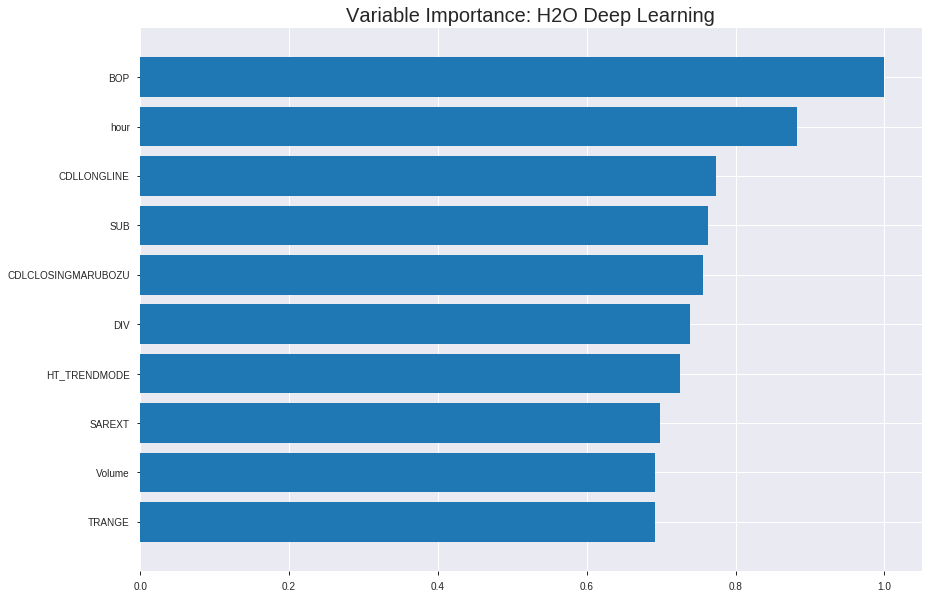

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_185719_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1976604140329082
RMSE: 0.44459016412074187
LogLoss: 0.5789689251664255
Mean Per-Class Error: 0.28497157760763914
AUC: 0.7754622760335266
pr_auc: 0.7561673250062151
Gini: 0.5509245520670532
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4361558203144966: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      410  402   0.4951   (402.0/812.0)
1      109  638   0.1459   (109.0/747.0)
Total  519  1040  0.3278   (511.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.436156     0.714046  240
max f2                       0.27453      0.835431  323
max f0point5                 0.58001      0.705612  150
max accuracy                 0.511542     0.713919  195
max precision                0.924704     1         0
max recall                   0.0310401    1         397
max specificity              0.924704     1         0
max absolute_mcc             0.511542     0.429951  195
max min_per_class_accuracy   0.526945     0.713054  187
max mean_per_class_accuracy  0.511542     0.715028  195

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.89847            2.08701   2.08701            1                0.911218  1                           0.911218            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.882491           1.95658   2.0218             0.9375           0.890212  0.96875                     0.900715            0.0200803       0.0414993                  95.6576   102.18
    3        0.0301475                   0.869996           1.80875   1.9538             0.866667         0.875208  0.93617                     0.892574            0.0174029       0.0589023                  80.8746   95.3801
    4        0.0404105                   0.853965           1.82614   1.92138            0.875            0.862304  0.920635                    0.884887            0.0187416       0.0776439                  82.6138   92.1379
    5        0.0500321                   0.845047           1.94788   1.92648            0.933333         0.849732  0.923077                    0.878126            0.0187416       0.0963855                  94.788    92.6475
    6        0.100064                    0.767932           1.71242   1.81945            0.820513         0.80613   0.871795                    0.842128            0.085676        0.182062                   71.2422   81.9449
    7        0.150096                    0.690239           1.6054    1.7481             0.769231         0.725515  0.837607                    0.803257            0.0803213       0.262383                   60.5396   74.8098
    8        0.200128                    0.643719           1.47161   1.67898            0.705128         0.666536  0.804487                    0.769077            0.0736278       0.336011                   47.1613   67.8977
    9        0.300192                    0.603255           1.48499   1.61431            0.711538         0.621656  0.773504                    0.719936            0.148594        0.484605                   48.4991   61.4315
    10       0.400257                    0.566677           1.2308    1.51844            0.589744         0.585427  0.727564                    0.686309            0.123159        0.607764                   23.0804   51.8437
    11       0.500321                    0.521757           1.09702   1.43415            0.525641         0.545807  0.687179                    0.658209            0.109772        0.717537                   9.70206   43.4154
    12       0.599743                    0.475712           0.821341  1.33256            0.393548         0.496247  0.638503                    0.631359            0.08166         0.799197                   -17.8659  33.2564
    13       0.699808                    0.419698           0.735806  1.24724            0.352564         0.447064  0.597617                    0.605007            0.0736278       0.872825                   -26.4194  24.7235
    14       0.799872                    0.351675           0.588645  1.16485            0.282051         0.389817  0.55814                     0.578087            0.0589023       0.931727                   -41.1355  16.4845
    15       0.899936                    0.255326           0.481619  1.08888            0.230769         0.307084  0.521739                    0.547954            0.0481928       0.97992                    -51.8381  8.88772
    16       1                           0.00669429         0.200674  1                  0.0961538        0.155915  0.479153                    0.508725          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19379633098964708
RMSE: 0.44022304686334524
LogLoss: 0.5715047411863848
Mean Per-Class Error: 0.2717886178861788
AUC: 0.7891666666666667
pr_auc: 0.7502612355682955
Gini: 0.5783333333333334
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4877959503937488: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  88   0.3577   (88.0/246.0)
1      43   157  0.215    (43.0/200.0)
Total  201  245  0.2937   (131.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.487796     0.705618  214
max f2                       0.129081     0.811582  381
max f0point5                 0.58977      0.733831  133
max accuracy                 0.58977      0.742152  133
max precision                0.91888      1         0
max recall                   0.0869235    1         394
max specificity              0.91888      1         0
max absolute_mcc             0.58977      0.479081  133
max min_per_class_accuracy   0.533596     0.705     185
max mean_per_class_accuracy  0.551522     0.728211  167

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.893116           1.784     1.784              0.8              0.90828   0.8                         0.90828             0.02            0.02                       78.4       78.4
    2        0.0201794                   0.885025           2.23      1.98222            1                0.887953  0.888889                    0.899246            0.02            0.04                       123        98.2222
    3        0.0313901                   0.87775            2.23      2.07071            1                0.882639  0.928571                    0.893315            0.025           0.065                      123        107.071
    4        0.0403587                   0.869749           1.6725    1.98222            0.75             0.87372   0.888889                    0.88896             0.015           0.08                       67.25      98.2222
    5        0.0515695                   0.856631           1.784     1.93913            0.8              0.863987  0.869565                    0.883531            0.02            0.1                        78.4       93.913
    6        0.100897                    0.780933           1.92591   1.93267            0.863636         0.820068  0.866667                    0.852505            0.095           0.195                      92.5909    93.2667
    7        0.150224                    0.719103           1.72318   1.86388            0.772727         0.744132  0.835821                    0.81692             0.085           0.28                       72.3182    86.3881
    8        0.201794                    0.651288           1.93913   1.88311            0.869565         0.684576  0.844444                    0.783098            0.1             0.38                       93.913     88.3111
    9        0.300448                    0.600807           1.57114   1.78067            0.704545         0.621341  0.798507                    0.729984            0.155           0.535                      57.1136    78.0672
    10       0.401345                    0.560306           0.991111  1.58218            0.444444         0.583093  0.709497                    0.693056            0.1             0.635                      -0.888889  58.2179
    11       0.5                         0.521055           0.962955  1.46               0.431818         0.541902  0.654709                    0.663232            0.095           0.73                       -3.70455   46
    12       0.600897                    0.455661           0.892     1.36463            0.4              0.486022  0.61194                     0.633477            0.09            0.82                       -10.8      36.4627
    13       0.699552                    0.401112           0.709545  1.27224            0.318182         0.430784  0.570513                    0.604892            0.07            0.89                       -29.0455   27.2244
    14       0.800448                    0.318149           0.396444  1.16185            0.177778         0.358569  0.521008                    0.573843            0.04            0.93                       -60.3556   16.1849
    15       0.899103                    0.194583           0.405455  1.07885            0.181818         0.26108   0.483791                    0.539525            0.04            0.97                       -59.4545   7.88529
    16       1                           0.0371354          0.297333  1                  0.133333         0.130864  0.44843                     0.498292 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:02:14  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:02:16  57.704 sec        707 obs/sec       0.652983  1             1018       0.468375         0.666386            0.120972       0.744903        0.706082           1.6957           0.349583                         0.454009           0.627264              0.166637         0.764248          0.686904             1.784              0.295964
    2019-08-27 19:02:24  1 min  5.962 sec  1029 obs/sec      5.89929   9             9197       0.44459          0.578969            0.207982       0.775462        0.756167           2.08701          0.327774                         0.440223           0.571505              0.21648          0.789167          0.750261             1.784              0.293722
    2019-08-27 19:02:32  1 min 14.026 sec  1128 obs/sec      11.73     18            18287      0.439824         0.568175            0.22487        0.786837        0.766407           2.08701          0.32136                          0.442892           0.58091               0.206951         0.774685          0.72444              1.784              0.320628
    2019-08-27 19:02:40  1 min 22.560 sec  1184 obs/sec      18.213    28            28394      0.430277         0.544367            0.258159       0.803107        0.791243           2.08701          0.311097                         0.442466           0.596816              0.208477         0.783567          0.734944             2.23               0.325112
    2019-08-27 19:02:48  1 min 30.477 sec  1236 obs/sec      24.6825   38            38480      0.422369         0.52779             0.285176       0.812701        0.799636           2.08701          0.294419                         0.439927           0.599497              0.217535         0.78253           0.722088             1.338              0.313901
    2019-08-27 19:02:57  1 min 38.573 sec  1289 obs/sec      31.8165   49            49602      0.41651          0.515882            0.304871       0.826868        0.823638           2.08701          0.308531                         0.44157            0.58599               0.211678         0.78248           0.725292             1.784              0.269058
    2019-08-27 19:02:57  1 min 39.372 sec  1288 obs/sec      31.8165   49            49602      0.44459          0.578969            0.207982       0.775462        0.756167           2.08701          0.327774                         0.440223           0.571505              0.21648          0.789167          0.750261             1.784              0.293722

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.031856396729007475
hour                0.8832626938819885     0.8832626938819885   0.02813756679223651
CDLLONGLINE         0.7741503715515137     0.7741503715515137   0.02466164136405356
SUB                 0.7634949684143066     0.7634949684143066   0.02432219861440718
CDLCLOSINGMARUBOZU  0.7564655542373657     0.7564655542373657   0.024098266807614042
---                 ---                    ---                  ---
CDL3INSIDE          0.546952486038208      0.546952486038208    0.017423935387150074
CDLIDENTICAL3CROWS  0.5367526412010193     0.5367526412010193   0.017099005083442274
CDLMORNINGSTAR      0.528644859790802      0.528644859790802    0.016840720382246318
CDLMORNINGDOJISTAR  0.5136523842811584     0.5136523842811584   0.016363114134461187
CDL3LINESTRIKE      0.4796702265739441     0.4796702265739441   0.015280565036832467


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6470588235294117)

('auc', 0.7401837928153717)

('logloss', 0.601892550106971)

('mean_per_class_error', 0.3195071010860484)

('rmse', 0.45281085688583134)

('mse', 0.20503767211368082)

deeplearning prediction progress: |███████████████████████████████████████| 100%


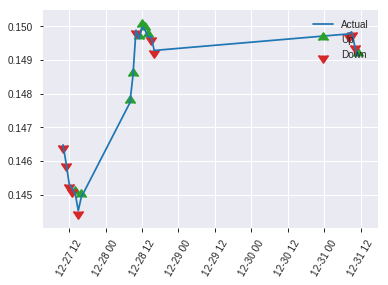


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20503767211368082
RMSE: 0.45281085688583134
LogLoss: 0.601892550106971
Mean Per-Class Error: 0.3195071010860484
AUC: 0.7401837928153717
pr_auc: 0.6668033571313914
Gini: 0.48036758563074344
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3810517275841415: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   71   0.5338   (71.0/133.0)
1      13   77   0.1444   (13.0/90.0)
Total  75   148  0.3767   (84.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.381052     0.647059  147
max f2                       0.10939      0.776014  206
max f0point5                 0.634152     0.666667  44
max accuracy                 0.634152     0.717489  44
max precision                0.919585     1         0
max recall                   0.025974     1         221
max specificity              0.919585     1         0
max absolute_mcc             0.634152     0.406258  44
max min_per_class_accuracy   0.500988     0.646617  105
max mean_per_class_accuracy  0.462289     0.680493  117

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 47.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.911039           1.65185   1.65185            0.666667         0.916194   0.666667                    0.916194            0.0222222       0.0222222                  65.1852   65.1852
    2        0.0224215                   0.898502           2.47778   1.98222            1                0.901804   0.8                         0.910438            0.0222222       0.0444444                  147.778   98.2222
    3        0.0313901                   0.885112           2.47778   2.12381            1                0.893017   0.857143                    0.905461            0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.879296           2.47778   2.20247            1                0.881744   0.888889                    0.90019             0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.869681           1.65185   2.06481            0.666667         0.874395   0.833333                    0.893742            0.0222222       0.111111                   65.1852   106.481
    6        0.103139                    0.804925           2.25253   2.15459            0.909091         0.832656   0.869565                    0.864527            0.111111        0.222222                   125.253   115.459
    7        0.152466                    0.679355           2.02727   2.1134             0.818182         0.753806   0.852941                    0.828705            0.1             0.322222                   102.727   111.34
    8        0.201794                    0.633951           1.57677   1.98222            0.636364         0.646383   0.8                         0.784138            0.0777778       0.4                        57.6768   98.2222
    9        0.300448                    0.598006           0.788384  1.59022            0.318182         0.611954   0.641791                    0.7276              0.0777778       0.477778                   -21.1616  59.0216
    10       0.399103                    0.552525           1.23889   1.50337            0.5              0.578899   0.606742                    0.690842            0.122222        0.6                        23.8889   50.3371
    11       0.502242                    0.474319           0.969565  1.39375            0.391304         0.518649   0.5625                      0.655481            0.1             0.7                        -3.04348  39.375
    12       0.600897                    0.436823           1.01364   1.33134            0.409091         0.455696   0.537313                    0.622681            0.1             0.8                        1.36364   33.1343
    13       0.699552                    0.350219           0.675758  1.23889            0.272727         0.396507   0.5                         0.590784            0.0666667       0.866667                   -32.4242  23.8889
    14       0.798206                    0.248021           0.450505  1.14145            0.181818         0.296035   0.460674                    0.554355            0.0444444       0.911111                   -54.9495  14.1448
    15       0.896861                    0.150002           0.337879  1.05306            0.136364         0.196835   0.425                       0.515028            0.0333333       0.944444                   -66.2121  5.30556
    16       1                           0.0244114          0.538647  1                  0.217391         0.0898091  0.403587                    0

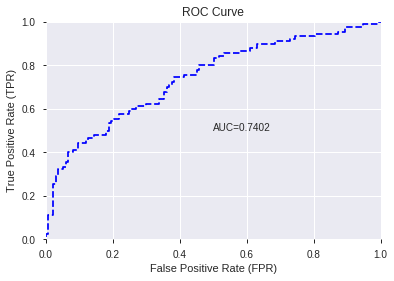

This function is available for GLM models only


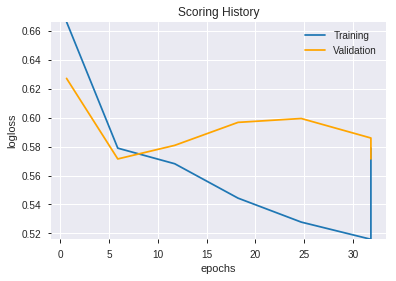

--2019-08-27 19:04:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.1.216
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.1.216|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


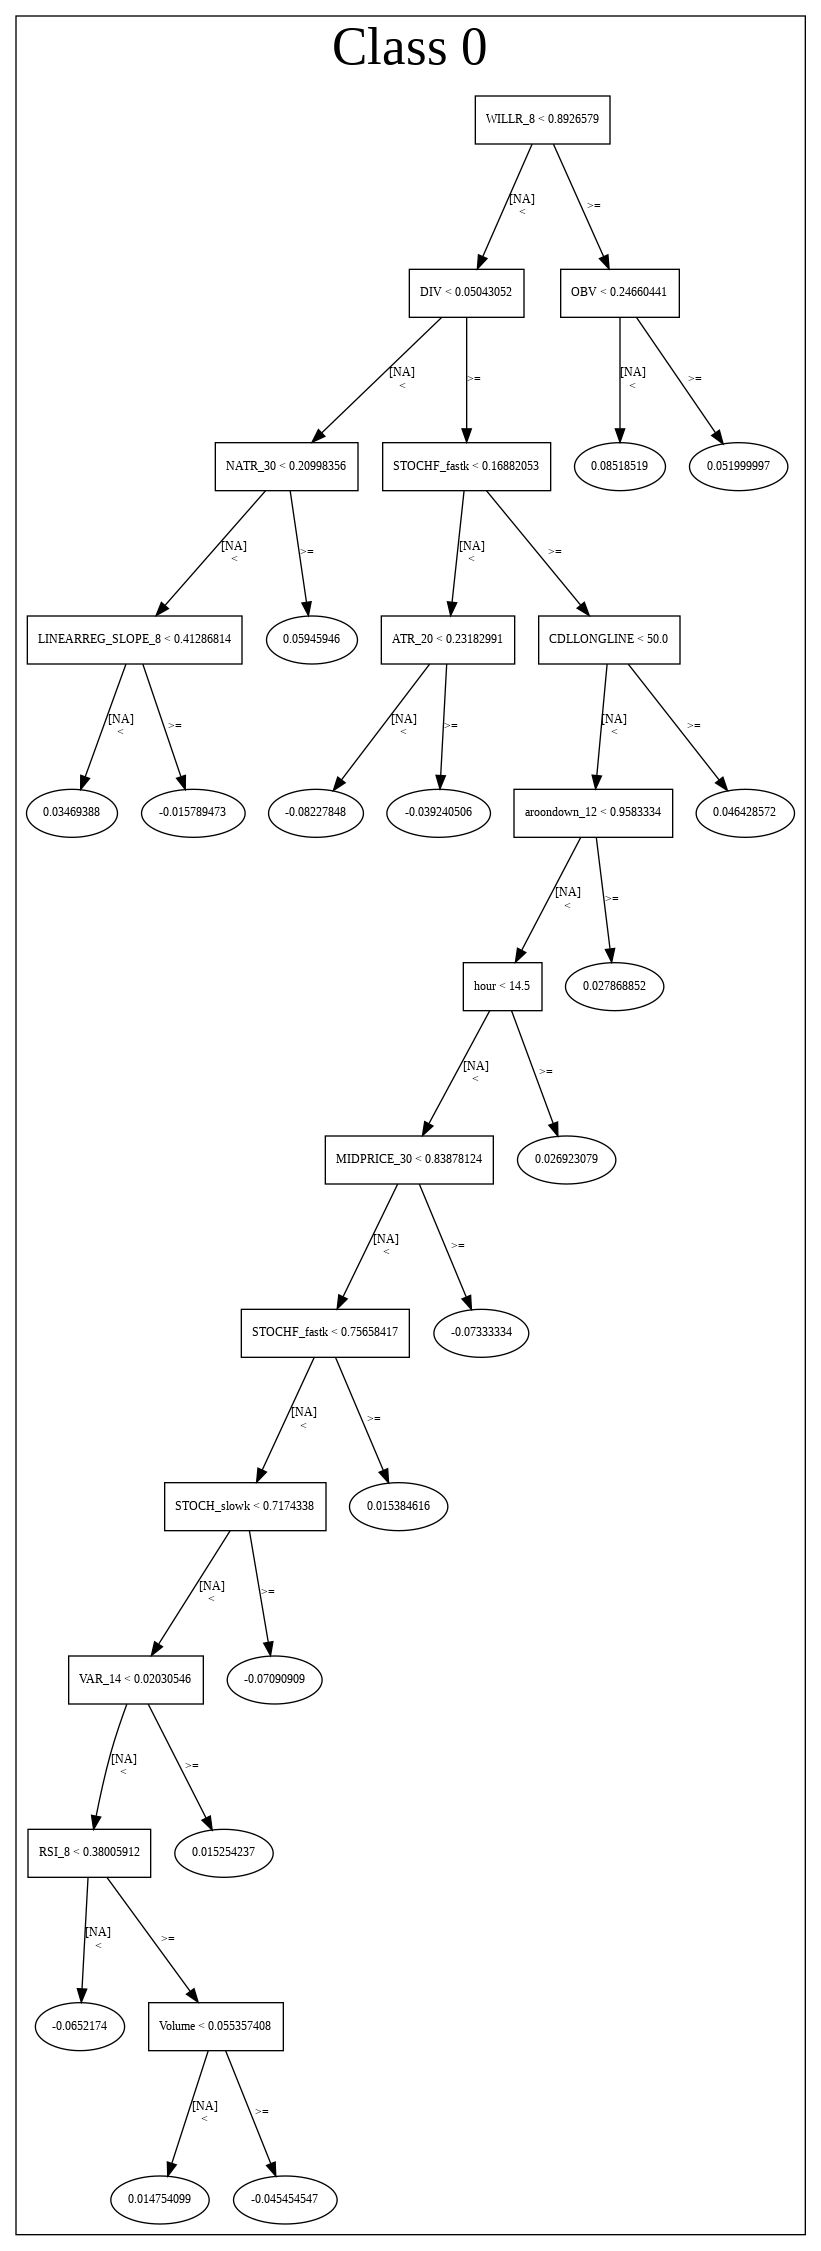

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_185719_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_185719_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'hour',
 'CDLLONGLINE',
 'SUB',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'HT_TRENDMODE',
 'SAREXT',
 'Volume',
 'TRANGE',
 'days_in_month',
 'CORREL_8',
 'CDLHAMMER',
 'CDLRICKSHAWMAN',
 'CDLSHOOTINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLTAKURI',
 'STOCHF_fastk',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING',
 'CDLSEPARATINGLINES',
 'VAR_8',
 'CDLSTALLEDPATTERN',
 'STOCHRSI_fastk',
 'CDLDRAGONFLYDOJI',
 'WILLR_8',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'day',
 'CDLEVENINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDLHIKKAKEMOD',
 'CORREL_14',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDL3BLACKCROWS',
 'CORREL_12',
 'CDLADVANCEBLOCK',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLPIERCING',
 'is_month_end',
 'CDL3INSIDE',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDL3LINESTRIKE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_190419_model_1  0.739348  0.600006              0.316082  0.450942  0.203349

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.482683           1.000000    0.129177
1             CDLHAMMER             0.202311           0.419139    0.054143
2    CDLCLOSINGMARUBOZU             0.194226           0.402388    0.051979
3                   DIV             0.184551           0.382344    0.049390
4                   SUB             0.179130           0.371114    0.047939
5           CDLLONGLINE             0.136960           0.283746    0.036654
6                  hour             0.126708           0.262508    0.033910
7          STOCHF_fastk             0.123574           0.256014    0.033071
8    CDLSEPARATINGLINES             0.121950           0.252650    0.032637
9                 VAR_8             0.099759           0.206675    0.026698
10             CORREL_8             0.087048           0.180341    0.023296
11          CDLPIERCING             0.081321           0.168476    0.021763
12       CDL3BLACKCROWS             0.081180           0.168185    0.021726
13      CDLSHOOTINGSTAR             0.078559           0.162755    0.021024
14        CDLHANGINGMAN             0.078181           0.161971    0.020923
15       CDL3LINESTRIKE             0.077348           0.160246    0.020700
16               SAREXT             0.072448           0.150094    0.019389
17    CDLDARKCLOUDCOVER             0.072236           0.149656    0.019332
18         CDLTHRUSTING             0.071157           0.147419    0.019043
19      CDLADVANCEBLOCK             0.068699           0.142327    0.018385
20   CDLEVENINGDOJISTAR             0.064309           0.133233    0.017211
21        CDLHIKKAKEMOD             0.064203           0.133013    0.017182
22                  day             0.063607           0.131778    0.017023
23               Volume             0.060135           0.124586    0.016094
24         CDLTASUKIGAP             0.059804           0.123900    0.016005
25               TRANGE             0.058869           0.121963    0.015755
26            CORREL_14             0.057276           0.118661    0.015328
27     CDLDRAGONFLYDOJI             0.055630           0.115252    0.014888
28            CDLTAKURI             0.055427           0.114832    0.014834
29            CORREL_12             0.053945           0.111760    0.014437
30   CDLIDENTICAL3CROWS             0.051641           0.106987    0.013820
31       CDLRICKSHAWMAN             0.050643           0.104919    0.013553
32    CDLINVERTEDHAMMER             0.047837           0.099106    0.012802
33              WILLR_8             0.047239           0.097866    0.012642
34       CDLMORNINGSTAR             0.046518           0.096374    0.012449
35         HT_TRENDMODE             0.040708           0.084336    0.010894
36    CDLLONGLEGGEDDOJI             0.032527           0.067387    0.008705
37              CDLDOJI             0.032479           0.067287    0.008692
38       CDLEVENINGSTAR             0.031557           0.065379    0.008445
39       is_month_start             0.027544           0.057064    0.007371
40  CDLGAPSIDESIDEWHITE             0.026052           0.053973    0.006972
41    CDLSTALLEDPATTERN             0.024595           0.050954    0.006582
42        days_in_month             0.021655           0.044865    0.005795
43       CDLMATCHINGLOW             0.014419           0.029873    0.003859
44    CDLGRAVESTONEDOJI             0.009761           0.020222    0.002612
45       STOCHRSI_fastk             0.005501           0.011396    0.001472
46         is_month_end             0.005313           0.011008    0.001422
47   CDLMORNINGDOJISTAR             0.004275           0.008856    0.001144
48      CDLLADDERBOTTOM             0.001721           0.003566    0.000461
49           CDL3INSIDE             0.001389           0.002877    0.000372

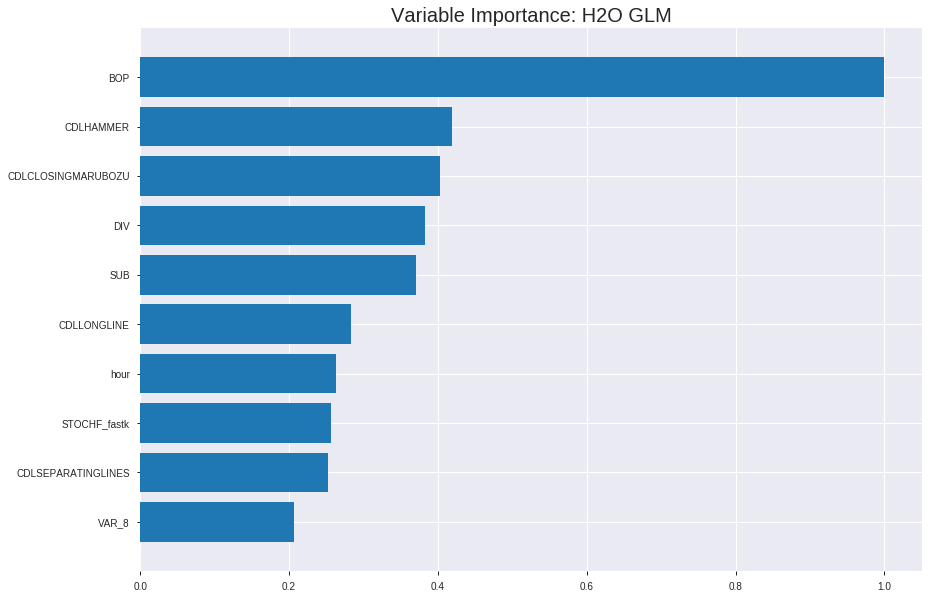

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_190419_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19625280721951532
RMSE: 0.44300429706664846
LogLoss: 0.5757249738159322
Null degrees of freedom: 1558
Residual degrees of freedom: 1508
Null deviance: 2158.5220527111505
Residual deviance: 1795.1104683580766
AIC: 1897.1104683580766
AUC: 0.7692024254654085
pr_auc: 0.7438951319855764
Gini: 0.538404850930817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32637689610346193: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      319  493   0.6071   (493.0/812.0)
1      63   684   0.0843   (63.0/747.0)
Total  382  1177  0.3566   (556.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.326377     0.711019  284
max f2                       0.163165     0.831822  349
max f0point5                 0.542359     0.701283  175
max accuracy                 0.533472     0.706863  180
max precision                0.977538     1         0
max recall                   0.0292297    1         395
max specificity              0.977538     1         0
max absolute_mcc             0.533472     0.412196  180
max min_per_class_accuracy   0.48965      0.698276  200
max mean_per_class_accuracy  0.533472     0.704451  180

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.912455           2.08701   2.08701            1                0.934623  1                           0.934623            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.880495           1.6957    1.89136            0.8125           0.893185  0.90625                     0.913904            0.0174029       0.038822                   69.5699   89.1357
    3        0.0301475                   0.861814           1.80875   1.86499            0.866667         0.870776  0.893617                    0.90014             0.0174029       0.0562249                  80.8746   86.4992
    4        0.0404105                   0.846124           1.6957    1.822              0.8125           0.854853  0.873016                    0.888638            0.0174029       0.0736278                  69.5699   82.1997
    5        0.0500321                   0.828966           1.80875   1.81945            0.866667         0.839287  0.871795                    0.879148            0.0174029       0.0910308                  80.8746   81.9449
    6        0.100064                    0.749391           1.76594   1.79269            0.846154         0.786108  0.858974                    0.832628            0.0883534       0.179384                   76.5936   79.2692
    7        0.150096                    0.694668           1.49837   1.69458            0.717949         0.721597  0.811966                    0.795618            0.0749665       0.254351                   49.837    69.4585
    8        0.200128                    0.663216           1.79269   1.71911            0.858974         0.679375  0.823718                    0.766557            0.0896921       0.344043                   79.2692   71.9111
    9        0.300192                    0.607114           1.31107   1.5831             0.628205         0.635842  0.758547                    0.722985            0.131191        0.475234                   31.1073   58.3099
    10       0.400257                    0.550443           1.31107   1.51509            0.628205         0.57782   0.725962                    0.686694            0.131191        0.606426                   31.1073   51.5092
    11       0.500321                    0.483141           1.03013   1.4181             0.49359          0.518844  0.679487                    0.653124            0.103079        0.709505                   3.01291   41.81
    12       0.599743                    0.420442           0.821341  1.31917            0.393548         0.4504    0.632086                    0.619517            0.08166         0.791165                   -17.8659  31.9172
    13       0.699808                    0.364992           0.829455  1.24915            0.397436         0.394196  0.598533                    0.587299            0.0829987       0.874163                   -17.0545  24.9148
    14       0.799872                    0.284363           0.62878   1.17154            0.301282         0.328913  0.561347                    0.554975            0.0629183       0.937082                   -37.122   17.154
    15       0.899936                    0.178603           0.374592  1.08293            0.179487         0.232698  0.518888                    0.519141            0.0374833       0.974565                   -62.5408  8.29271
    16       1                           0.0023695          0.254188  1                  0.121795         0.119523  0.479153                    0.479153            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1922482733956711
RMSE: 0.4384612564362684
LogLoss: 0.5753731838542709
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 615.2252417868635
Residual deviance: 513.2328799980097
AIC: 615.2328799980097
AUC: 0.7817784552845528
pr_auc: 0.7253970375639663
Gini: 0.5635569105691056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42390099904519585: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      146  100  0.4065   (100.0/246.0)
1      37   163  0.185    (37.0/200.0)
Total  183  263  0.3072   (137.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423901     0.704104  234
max f2                       0.246674     0.824786  328
max f0point5                 0.562694     0.718326  152
max accuracy                 0.562694     0.737668  152
max precision                0.949253     1         0
max recall                   0.00288967   1         399
max specificity              0.949253     1         0
max absolute_mcc             0.562694     0.466568  152
max min_per_class_accuracy   0.501754     0.705     186
max mean_per_class_accuracy  0.562694     0.728069  152

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0112108                   0.896343           2.23      2.23               1                0.928663  1                           0.928663            0.025           0.025                      123        123
    2        0.0201794                   0.864107           1.6725    1.98222            0.75             0.880919  0.888889                    0.907444            0.015           0.04                       67.25      98.2222
    3        0.0313901                   0.851212           1.338     1.75214            0.6              0.859792  0.785714                    0.890425            0.015           0.055                      33.8       75.2143
    4        0.0403587                   0.834105           1.6725    1.73444            0.75             0.846217  0.777778                    0.880601            0.015           0.07                       67.25      73.4444
    5        0.0515695                   0.818406           1.784     1.74522            0.8              0.826508  0.782609                    0.868842            0.02            0.09                       78.4       74.5217
    6        0.100897                    0.756664           1.92591   1.83356            0.863636         0.785388  0.822222                    0.828042            0.095           0.185                      92.5909    83.3556
    7        0.150224                    0.706844           1.82455   1.8306             0.818182         0.731329  0.820896                    0.796286            0.09            0.275                      82.4545    83.0597
    8        0.201794                    0.659433           1.64826   1.784              0.73913          0.682648  0.8                         0.767245            0.085           0.36                       64.8261    78.4
    9        0.300448                    0.599475           1.57114   1.7141             0.704545         0.62759   0.768657                    0.721388            0.155           0.515                      57.1136    71.4104
    10       0.401345                    0.552933           1.338     1.61955            0.6              0.577383  0.726257                    0.685186            0.135           0.65                       33.8       61.9553
    11       0.5                         0.481772           0.709545  1.44               0.318182         0.515047  0.64574                     0.651616            0.07            0.72                       -29.0455   44
    12       0.600897                    0.417048           0.991111  1.36463            0.444444         0.446692  0.61194                     0.617207            0.1             0.82                       -0.888889  36.4627
    13       0.699552                    0.352572           0.5575    1.2508             0.25             0.385931  0.560897                    0.584591            0.055           0.875                      -44.25     25.0801
    14       0.800448                    0.261641           0.693778  1.18059            0.311111         0.305295  0.529412                    0.549386            0.07            0.945                      -30.6222   18.0588
    15       0.899103                    0.173933           0.304091  1.08441            0.136364         0.222473  0.486284                    0.513515            0.03            0.975                      -69.5909   8.4414
    16       1                           0.00288967         0.247778  1                  0.111111         0.113111  0.44843                     0.473115     


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 19:04:19  0.000 sec   2            18        51            1.36915           1.36349
    2019-08-27 19:04:19  0.020 sec   4            11        51            1.36074           1.3548
    2019-08-27 19:04:19  0.032 sec   6            6.8       51            1.34857           1.3422
    2019-08-27 19:04:19  0.044 sec   8            4.2       51            1.3318            1.32486
    2019-08-27 19:04:19  0.058 sec   10           2.6       51            1.31031           1.30265
    2019-08-27 19:04:19  0.069 sec   12           1.6       51            1.28508           1.2766
    2019-08-27 19:04:19  0.077 sec   14           1         51            1.2582            1.2489
    2019-08-27 19:04:19  0.087 sec   16           0.63      51            1.2321            1.22211
    2019-08-27 19:04:19  0.097 sec   18           0.39      51            1.20886           1.19847
    2019-08-27 19:04:19  0.110 sec   20           0.24      51            1.18965           1.17932
    2019-08-27 19:04:19  0.120 sec   22           0.15      51            1.17477           1.16526
    2019-08-27 19:04:20  0.128 sec   24           0.093     51            1.16393           1.1562
    2019-08-27 19:04:20  0.135 sec   26           0.058     51            1.15642           1.15162
    2019-08-27 19:04:20  0.144 sec   28           0.036     51            1.15145           1.15075
    2019-08-27 19:04:20  0.154 sec   30           0.022     51            1.14826           1.15276
    2019-08-27 19:04:20  0.175 sec   32           0.014     51            1.14624           1.15695
    2019-08-27 19:04:20  0.185 sec   34           0.0086    51            1.14498           1.1627
    2019-08-27 19:04:20  0.196 sec   36           0.0054    51            1.14419           1.16962
    2019-08-27 19:04:20  0.204 sec   37           0.0033    51            1.14373           1.17633

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7174887892376681)

('F1', 0.6543778801843319)

('auc', 0.7393483709273183)

('logloss', 0.6000058186934354)

('mean_per_class_error', 0.31048454469507103)

('rmse', 0.450941850017365)

('mse', 0.2033485520970837)

glm prediction progress: |████████████████████████████████████████████████| 100%


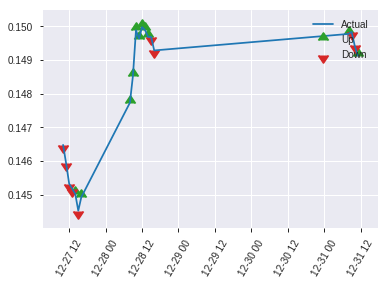


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2033485520970837
RMSE: 0.450941850017365
LogLoss: 0.6000058186934354
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 305.94391779285456
Residual deviance: 267.6025951372722
AIC: 369.6025951372722
AUC: 0.7393483709273183
pr_auc: 0.6539106995927559
Gini: 0.4786967418546366
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39665243710749504: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      77   56   0.4211   (56.0/133.0)
1      19   71   0.2111   (19.0/90.0)
Total  96   127  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396652     0.654378  126
max f2                       0.21155      0.791897  182
max f0point5                 0.582521     0.65508   70
max accuracy                 0.582521     0.717489  70
max precision                0.942916     1         0
max recall                   0.00621317   1         221
max specificity              0.942916     1         0
max absolute_mcc             0.582521     0.399182  70
max min_per_class_accuracy   0.47362      0.655556  102
max mean_per_class_accuracy  0.582521     0.689515  70

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 44.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.86371            2.47778   2.47778            1                0.917069   1                           0.917069            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.841296           1.23889   1.98222            0.5              0.848249   0.8                         0.889541            0.0111111       0.0444444                  23.8889   98.2222
    3        0.0313901                   0.830051           2.47778   2.12381            1                0.838895   0.857143                    0.87507             0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.817633           2.47778   2.20247            1                0.8232     0.888889                    0.863544            0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.812822           1.65185   2.06481            0.666667         0.815691   0.833333                    0.85158             0.0222222       0.111111                   65.1852   106.481
    6        0.103139                    0.768323           2.02727   2.04686            0.818182         0.790181   0.826087                    0.822215            0.1             0.211111                   102.727   104.686
    7        0.152466                    0.698293           1.80202   1.96765            0.727273         0.723333   0.794118                    0.790224            0.0888889       0.3                        80.202    96.7647
    8        0.201794                    0.654365           1.35152   1.81704            0.545455         0.679675   0.733333                    0.763201            0.0666667       0.366667                   35.1515   81.7037
    9        0.300448                    0.589813           1.35152   1.66418            0.545455         0.626771   0.671642                    0.718403            0.133333        0.5                        35.1515   66.4179
    10       0.399103                    0.525122           1.12626   1.53121            0.454545         0.558825   0.617978                    0.678957            0.111111        0.611111                   12.6263   53.1211
    11       0.502242                    0.447132           0.861836  1.39375            0.347826         0.485481   0.5625                      0.639225            0.0888889       0.7                        -13.8164  39.375
    12       0.600897                    0.382723           0.90101   1.31285            0.363636         0.407986   0.529851                    0.60126             0.0888889       0.788889                   -9.89899  31.2852
    13       0.699552                    0.304264           0.675758  1.22301            0.272727         0.346845   0.49359                     0.565381            0.0666667       0.855556                   -32.4242  22.3006
    14       0.798206                    0.221061           0.788384  1.16929            0.318182         0.264911   0.47191                     0.528244            0.0777778       0.933333                   -21.1616  16.9288
    15       0.896861                    0.137716           0.450505  1.09022            0.181818         0.181184   0.44                        0.490068            0.0444444       0.977778                   -54.9495  9.02222
    16       1                           0.00562687         0.215459  1                  0.0869565        0.0844671  0.403587                    

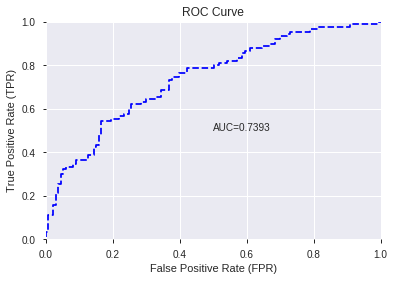

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


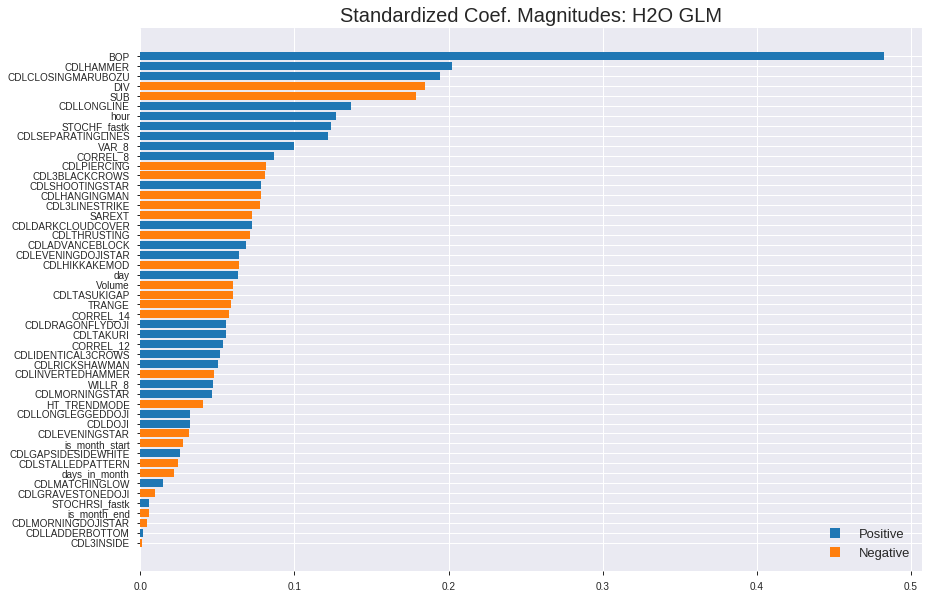

'log_likelihood'
--2019-08-27 19:04:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


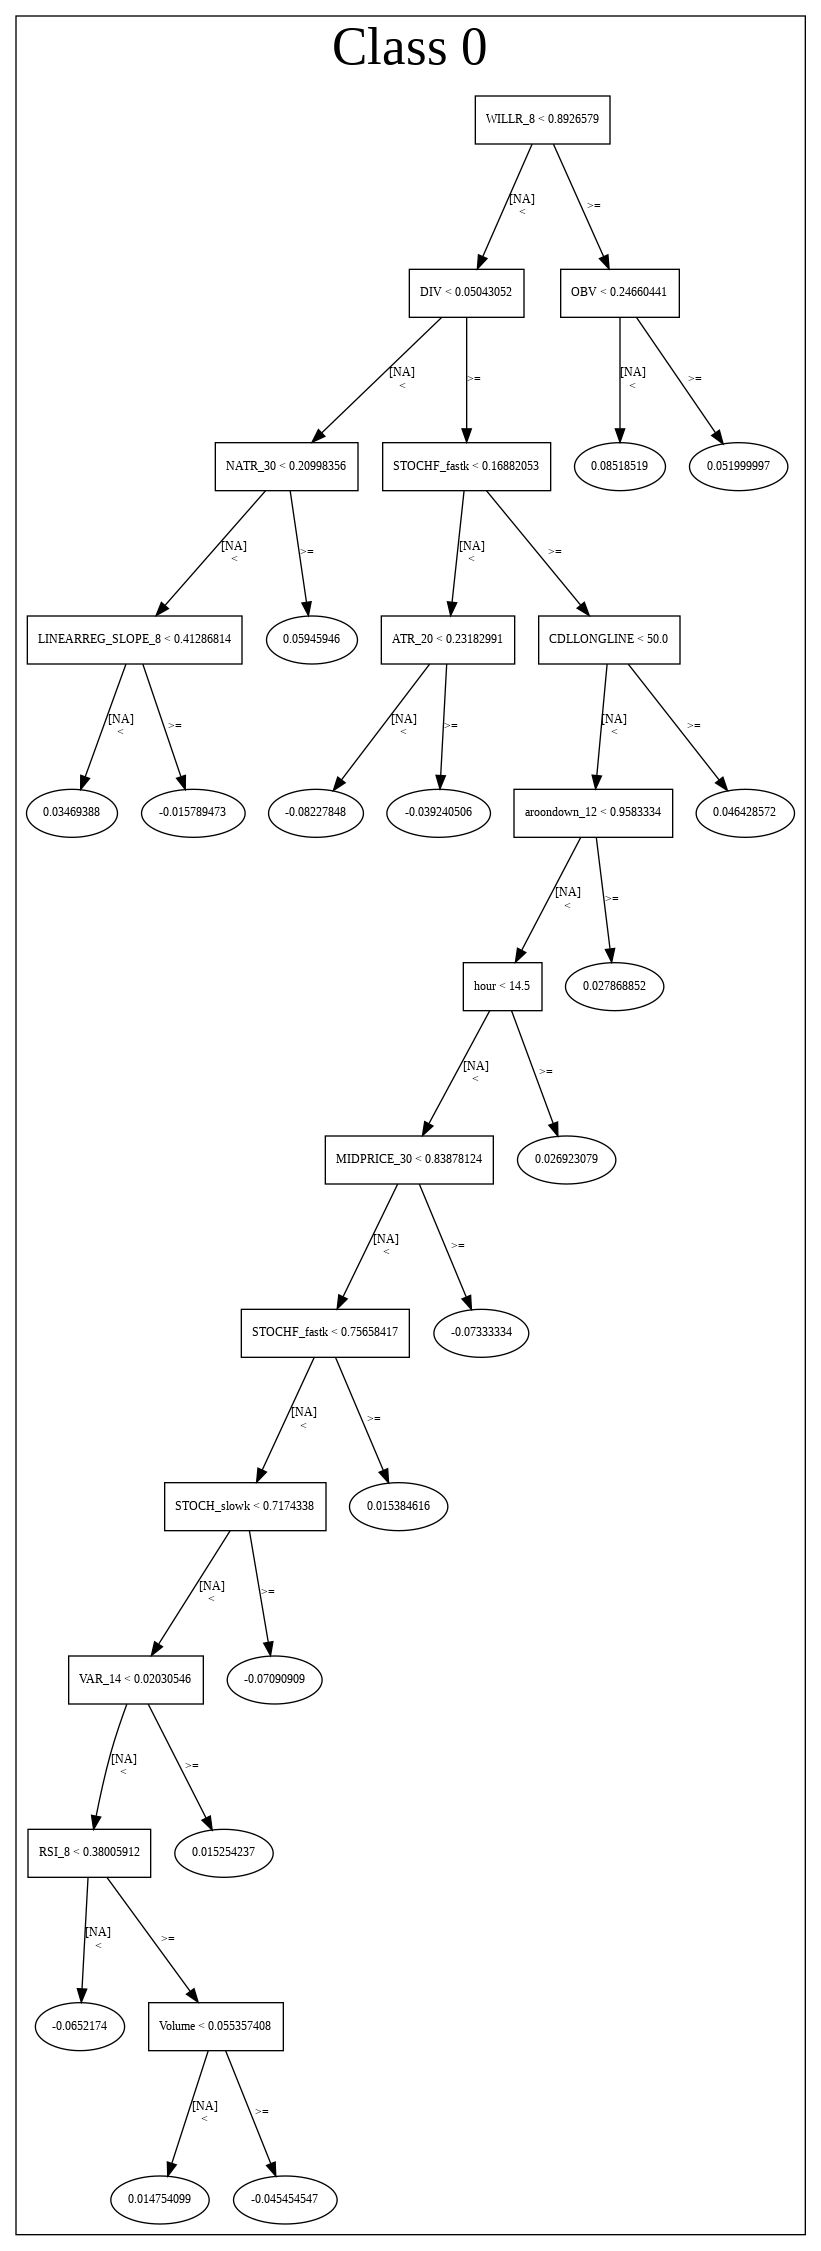

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_190419_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_190419_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CDLHAMMER',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'hour',
 'STOCHF_fastk',
 'CDLSEPARATINGLINES',
 'VAR_8',
 'CORREL_8',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CDL3LINESTRIKE',
 'SAREXT',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDLADVANCEBLOCK',
 'CDLEVENINGDOJISTAR',
 'CDLHIKKAKEMOD',
 'day',
 'Volume',
 'CDLTASUKIGAP',
 'TRANGE',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CORREL_12',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLINVERTEDHAMMER',
 'WILLR_8',
 'CDLMORNINGSTAR',
 'HT_TRENDMODE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'CDLEVENINGSTAR',
 'is_month_start',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'STOCHRSI_fastk',
 'is_month_end',
 'CDLMORNINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDL3INSIDE']

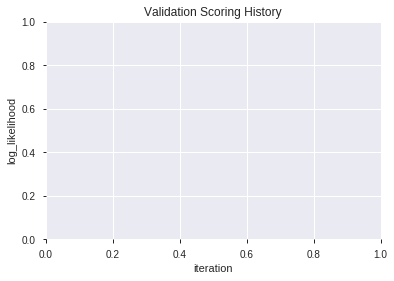

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_190438_model_5  0.752799  0.578827              0.305138  0.445576  0.198538
1  XGBoost_grid_1_AutoML_20190827_190438_model_3  0.748956  0.581443              0.318212  0.447427  0.200191
2               XGBoost_2_AutoML_20190827_190438  0.738764  0.592674              0.320175  0.452116  0.204409
3  XGBoost_grid_1_AutoML_20190827_190438_model_7  0.738596  0.596282              0.318212  0.454068  0.206178
4               XGBoost_3_AutoML_20190827_190438  0.737427  0.599204              0.325898  0.455730  0.207690
5  XGBoost_grid_1_AutoML_20190827_190438_model_6  0.735422  0.596837              0.320510  0.455485  0.207466
6  XGBoost_grid_1_AutoML_20190827_190438_model_4  0.732164  0.592451              0.341437  0.452206  0.204490
7  XGBoost_grid_1_AutoML_20190827_190438_model_2  0.730409  0.596702              0.331788  0.455225  0.207229
8               XGBoost_1_AutoML_20190827_190438  0.729741  0.602910              0.305472  0.456811  0.208676
9  XGBoost_grid_1_AutoML_20190827_190438_model_1  0.728780  0.614792              0.358438  0.463052  0.214417

variable  relative_importance  scaled_importance  percentage
0                   BOP          2740.214355           1.000000    0.121149
1                Volume          2217.795166           0.809351    0.098052
2                   DIV          2129.787109           0.777234    0.094161
3          STOCHF_fastk          2013.017578           0.734620    0.088999
4               WILLR_8          1910.755615           0.697302    0.084478
5                SAREXT          1717.950439           0.626940    0.075953
6                   day          1570.583984           0.573161    0.069438
7                  hour          1461.191284           0.533240    0.064602
8                TRANGE          1350.762817           0.492941    0.059719
9                 VAR_8          1267.157715           0.462430    0.056023
10       STOCHRSI_fastk          1108.678345           0.404595    0.049016
11                  SUB           859.284485           0.313583    0.037990
12        days_in_month           418.459167           0.152710    0.018501
13   CDLCLOSINGMARUBOZU           343.493439           0.125353    0.015186
14         HT_TRENDMODE           260.563690           0.095089    0.011520
15          CDLLONGLINE           191.698654           0.069958    0.008475
16              CDLDOJI           165.928055           0.060553    0.007336
17            CDLHAMMER           139.398788           0.050871    0.006163
18            CORREL_12            97.598640           0.035617    0.004315
19       CDLRICKSHAWMAN            84.457680           0.030822    0.003734
20             CORREL_8            74.564186           0.027211    0.003297
21         is_month_end            65.093758           0.023755    0.002878
22            CORREL_14            55.630386           0.020301    0.002460
23     CDLDRAGONFLYDOJI            48.891697           0.017842    0.002162
24    CDLLONGLEGGEDDOJI            45.957321           0.016771    0.002032
25       CDLMORNINGSTAR            35.134087           0.012822    0.001553
26           CDL3INSIDE            28.618467           0.010444    0.001265
27    CDLGRAVESTONEDOJI            28.412416           0.010369    0.001256
28    CDLINVERTEDHAMMER            24.708132           0.009017    0.001092
29      CDLSHOOTINGSTAR            24.116903           0.008801    0.001066
30       is_month_start            20.840961           0.007606    0.000921
31      CDLADVANCEBLOCK            19.354628           0.007063    0.000856
32        CDLHANGINGMAN            16.622747           0.006066    0.000735
33            CDLTAKURI            15.902294           0.005803    0.000703
34       CDLMATCHINGLOW            10.784119           0.003936    0.000477
35  CDLGAPSIDESIDEWHITE            10.536432           0.003845    0.000466
36   CDLMORNINGDOJISTAR             9.618014           0.003510    0.000425
37   CDLSEPARATINGLINES             8.661278           0.003161    0.000383
38       CDLEVENINGSTAR             6.521928           0.002380    0.000288
39       CDL3LINESTRIKE             6.219205           0.002270    0.000275
40    CDLSTALLEDPATTERN             3.622191           0.001322    0.000160
41          CDLPIERCING             3.541187           0.001292    0.000157
42       CDL3BLACKCROWS             2.873901           0.001049    0.000127
43      CDLLADDERBOTTOM             2.138533           0.000780    0.000095
44         CDLTHRUSTING             1.353905           0.000494    0.000060

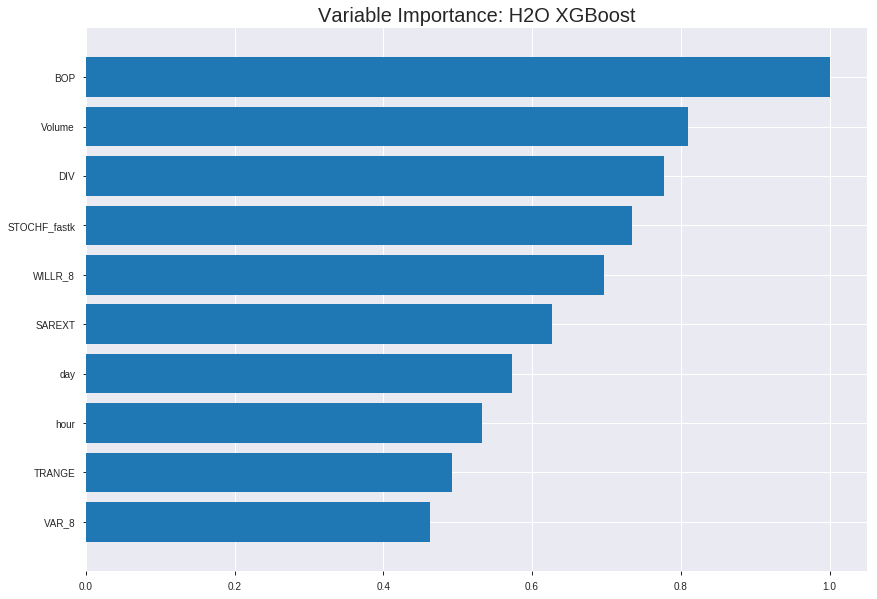

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_190438_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18748219564641394
RMSE: 0.4329921427074791
LogLoss: 0.5437757397551877
Mean Per-Class Error: 0.3527443105756358
AUC: 0.7419579797020595
pr_auc: 0.840962664281312
Gini: 0.4839159594041189
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      219  593   0.7303   (593.0/812.0)
1      0    747   0        (0.0/747.0)
Total  219  1340  0.3804   (593.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.5          0.71586   196
max f2                       0.5          0.862985  196
max f0point5                 0.528814     0.676091  194
max accuracy                 0.528814     0.661963  194
max precision                0.958684     1         0
max recall                   0.5          1         196
max specificity              0.958684     1         0
max absolute_mcc             0.528814     0.422609  194
max min_per_class_accuracy   0.528814     0.294511  194
max mean_per_class_accuracy  0.528814     0.647256  194

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 49.97 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------
    1        0.010263                    0.939995           2.08701  2.08701            1                0.947973  1                           0.947973            0.021419        0.021419                   108.701  108.701
    2        0.020526                    0.928007           2.08701  2.08701            1                0.932032  1                           0.940002            0.021419        0.042838                   108.701  108.701
    3        0.0301475                   0.918657           2.08701  2.08701            1                0.924071  1                           0.934918            0.0200803       0.0629183                  108.701  108.701
    4        0.0404105                   0.911347           2.08701  2.08701            1                0.915254  1                           0.929924            0.021419        0.0843373                  108.701  108.701
    5        0.0500321                   0.899779           2.08701  2.08701            1                0.906214  1                           0.925364            0.0200803       0.104418                   108.701  108.701
    6        0.100064                    0.828855           2.08701  2.08701            1                0.864165  1                           0.894765            0.104418        0.208835                   108.701  108.701
    7        0.859525                    0.5                1.04174  1.16343            0.499155         0.51344   0.557463                    0.557833            0.791165        1                          4.17447  16.3433
    8        0.899936                    0.175986           0        1.11119            0                0.250837  0.532431                    0.544048            0               1                          -100     11.119
    9        1                           0.0285454          0        1                  0                0.100684  0.479153                    0.499683            0               1                          -100     0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.220017919670143
RMSE: 0.4690606780259277
LogLoss: 0.6295474071111171
Mean Per-Class Error: 0.3795934959349594
AUC: 0.6829268292682927
pr_auc: 0.6350382837251696
Gini: 0.36585365853658547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34884387254714966: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   172  0.6992   (172.0/246.0)
1      12   188  0.06     (12.0/200.0)
Total  86   360  0.4126   (184.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.348844     0.671429  137
max f2                       0.151651     0.813953  181
max f0point5                 0.440891     0.573454  115
max accuracy                 0.572041     0.632287  87
max precision                0.950319     1         0
max recall                   0.0597526    1         213
max specificity              0.950319     1         0
max absolute_mcc             0.348844     0.303572  137
max min_per_class_accuracy   0.5          0.382114  100
max mean_per_class_accuracy  0.348844     0.620407  137

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 48.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.913735           1.338     1.338              0.6              0.930008   0.6                         0.930008            0.015           0.015                      33.8      33.8
    2        0.0201794                   0.897229           2.23      1.73444            1                0.903706   0.777778                    0.918318            0.02            0.035                      123       73.4444
    3        0.0313901                   0.88185            1.784     1.75214            0.8              0.891336   0.785714                    0.908682            0.02            0.055                      78.4      75.2143
    4        0.0403587                   0.860705           1.6725    1.73444            0.75             0.871651   0.777778                    0.900453            0.015           0.07                       67.25     73.4444
    5        0.0515695                   0.839142           2.23      1.84217            1                0.846831   0.826087                    0.888796            0.025           0.095                      123       84.2174
    6        0.100897                    0.751837           1.72318   1.784              0.772727         0.8009     0.8                         0.845825            0.085           0.18                       72.3182   78.4
    7        0.150224                    0.694022           1.31773   1.6309             0.590909         0.718227   0.731343                    0.803927            0.065           0.245                      31.7727   63.0896
    8        0.201794                    0.565423           1.35739   1.561              0.608696         0.625205   0.7                         0.758254            0.07            0.315                      35.7391   56.1
    9        0.724215                    0.5                1.03365   1.18059            0.463519         0.50181    0.529412                    0.573265            0.54            0.855                      3.36481   18.0588
    10       0.800448                    0.350039           0.983824  1.16185            0.441176         0.431889   0.521008                    0.5598              0.075           0.93                       -1.61765  16.1849
    11       0.899103                    0.156737           0.405455  1.07885            0.181818         0.243138   0.483791                    0.525054            0.04            0.97                       -59.4545  7.88529
    12       1                           0.0331047          0.297333  1                  0.133333         0.0991303  0.44843                     0.48208             0.03            1                          -70.2667  0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:04:46  4.141 sec   0                  0.5              0.693147            0.5             0                  1                0.520847                         0.5                0.693147              0.5               0                    1                  0.55157
    2019-08-27 19:04:46  4.530 sec   5                  0.440647         0.580448            0.978864        0.974657           2.08701          0.0628608                        0.47754            0.648842              0.744787          0.690205             1.338              0.318386
    2019-08-27 19:04:47  4.895 sec   10                 0.390696         0.493307            0.994917        0.991232           2.08701          0.0320718                        0.463625           0.62132               0.754187          0.687945             1.784              0.313901
    2019-08-27 19:04:47  5.247 sec   15                 0.350794         0.427392            0.997143        0.994001           2.08701          0.0230917                        0.449983           0.594278              0.776951          0.713765             2.23               0.275785
    2019-08-27 19:04:47  5.575 sec   20                 0.316919         0.373786            0.998872        0.997381           2.08701          0.0141116                        0.44234            0.578827              0.782663          0.71104              1.338              0.266816
    2019-08-27 19:04:48  5.941 sec   25                 0.28849          0.33004             0.999153        0.997707           2.08701          0.0115459                        0.439013           0.57159               0.779868          0.714171             2.23               0.257848
    2019-08-27 19:04:48  6.296 sec   30                 0.265284         0.295593            0.999652        0.99828            2.08701          0.00898012                       0.435115           0.563075              0.784461          0.715825             1.784              0.269058
    2019-08-27 19:04:49  6.657 sec   35                 0.244697         0.265868            0.999841        0.998488           2.08701          0.00641437                       0.433753           0.559758              0.784878          0.708231             1.784              0.275785
    2019-08-27 19:04:49  7.010 sec   40                 0.228081         0.242515            0.999955        0.997273           2.08701          0.00256575                       0.433479           0.558584              0.785122          0.70683              1.338              0.307175
    2019-08-27 19:04:49  7.383 sec   45                 0.213091         0.221837            0.999974        0.998633           2.08701          0.00192431                       0.434441           0.560659              0.782043          0.704991             1.338              0.311659
    2019-08-27 19:04:50  7.740 sec   50                 0.199915         0.204364            0.999996        0.998657           2.08701          0.00128287                       0.435858           0.563559              0.779868          0.706845             1.338              0.309417
    2019-08-27 19:04:50  8.096 sec   55                 0.187983         0.188572            0.999987        0.998647           2.08701          0.000641437                      0.436008           0.56555               0.780091          0.

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ----------------------
BOP                2740.21435546875       1.0                    0.12114927507198486
Volume             2217.795166015625      0.8093509770830472     0.0980522841524138
DIV                2129.787109375         0.7772337609736636     0.0941613067034317
STOCHF_fastk       2013.017578125         0.7346204774482493     0.08899873829589082
WILLR_8            1910.755615234375      0.6973015127159696     0.08447757277213816
---                ---                    ---                    ---
CDLSTALLEDPATTERN  3.6221907138824463     0.0013218640018630304  0.000160142865569459
CDLPIERCING        3.541187047958374      0.0012923029327581955  0.0001565615634770554
CDL3BLACKCROWS     2.873901128768921      0.0010487869764762626  0.00012705978190503806
CDLLADDERBOTTOM    2.1385326385498047     0.0007804253102615326  9.454796058601354e-05
CDLTHRUSTING       1.3539049625396729     0.0004940872453418227  5.9858311595475755e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.6696428571428571)

('auc', 0.7527986633249791)

('logloss', 0.5788268166106729)

('mean_per_class_error', 0.3051378446115288)

('rmse', 0.44557591991463324)

('mse', 0.19853790040777164)

xgboost prediction progress: |████████████████████████████████████████████| 100%


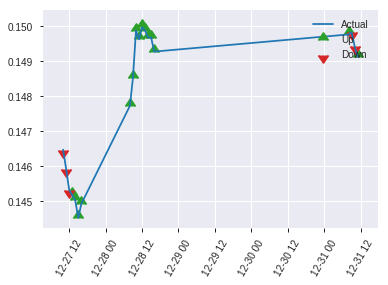


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19853790040777164
RMSE: 0.44557591991463324
LogLoss: 0.5788268166106729
Mean Per-Class Error: 0.3051378446115288
AUC: 0.7527986633249791
pr_auc: 0.6725400297798126
Gini: 0.5055973266499583
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33040472865104675: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      74   59   0.4436   (59.0/133.0)
1      15   75   0.1667   (15.0/90.0)
Total  89   134  0.3318   (74.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.330405     0.669643  133
max f2                       0.222208     0.791985  163
max f0point5                 0.661834     0.686275  53
max accuracy                 0.661834     0.730942  53
max precision                0.940896     1         0
max recall                   0.06242      1         211
max specificity              0.940896     1         0
max absolute_mcc             0.661834     0.431126  53
max min_per_class_accuracy   0.44644      0.666667  102
max mean_per_class_accuracy  0.330405     0.694862  133

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 44.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.92471            2.47778   2.47778            1                0.935419  1                           0.935419            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.909645           2.47778   2.47778            1                0.918575  1                           0.928681            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.89367            1.23889   2.12381            0.5              0.903733  0.857143                    0.921553            0.0111111       0.0666667                  23.8889   112.381
    4        0.0403587                   0.883868           1.23889   1.92716            0.5              0.886796  0.777778                    0.913829            0.0111111       0.0777778                  23.8889   92.716
    5        0.0538117                   0.882724           2.47778   2.06481            1                0.883288  0.833333                    0.906194            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.83346            1.80202   1.93913            0.727273         0.861752  0.782609                    0.884939            0.0888889       0.2                        80.202    93.913
    7        0.152466                    0.763778           2.25253   2.04052            0.909091         0.796505  0.823529                    0.856328            0.111111        0.311111                   125.253   104.052
    8        0.201794                    0.714364           1.80202   1.98222            0.727273         0.742227  0.8                         0.828437            0.0888889       0.4                        80.202    98.2222
    9        0.300448                    0.599215           0.90101   1.6272             0.363636         0.647147  0.656716                    0.768909            0.0888889       0.488889                   -9.89899  62.7197
    10       0.399103                    0.513652           1.01364   1.47553            0.409091         0.565821  0.595506                    0.718707            0.1             0.588889                   1.36364   47.5531
    11       0.502242                    0.415087           0.861836  1.3495             0.347826         0.461343  0.544643                    0.665856            0.0888889       0.677778                   -13.8164  34.9504
    12       0.600897                    0.329594           1.57677   1.38682            0.636364         0.377618  0.559701                    0.618533            0.155556        0.833333                   57.6768   38.6816
    13       0.699552                    0.241071           0.450505  1.25477            0.181818         0.291849  0.50641                     0.572462            0.0444444       0.877778                   -54.9495  25.4772
    14       0.798206                    0.16901            0.675758  1.18321            0.272727         0.211167  0.477528                    0.527808            0.0666667       0.944444                   -32.4242  18.3208
    15       0.896861                    0.0924404          0.337879  1.09022            0.136364         0.130342  0.44                        0.484086            0.0333333       0.977778                   -66.2121  9.02222
    16       1                           0.0306305          0.215459  1                  0.0869565        0.06248   0.403587                    0.440602           

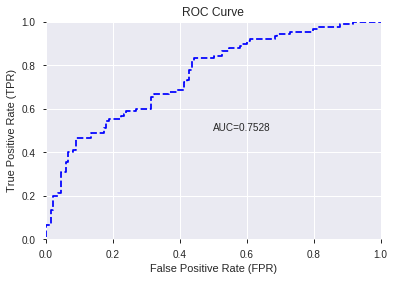

This function is available for GLM models only


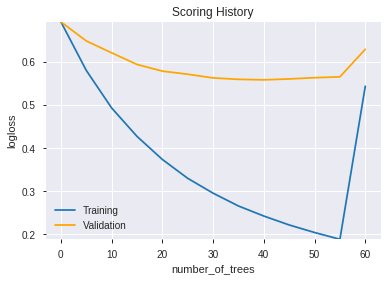

--2019-08-27 19:04:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

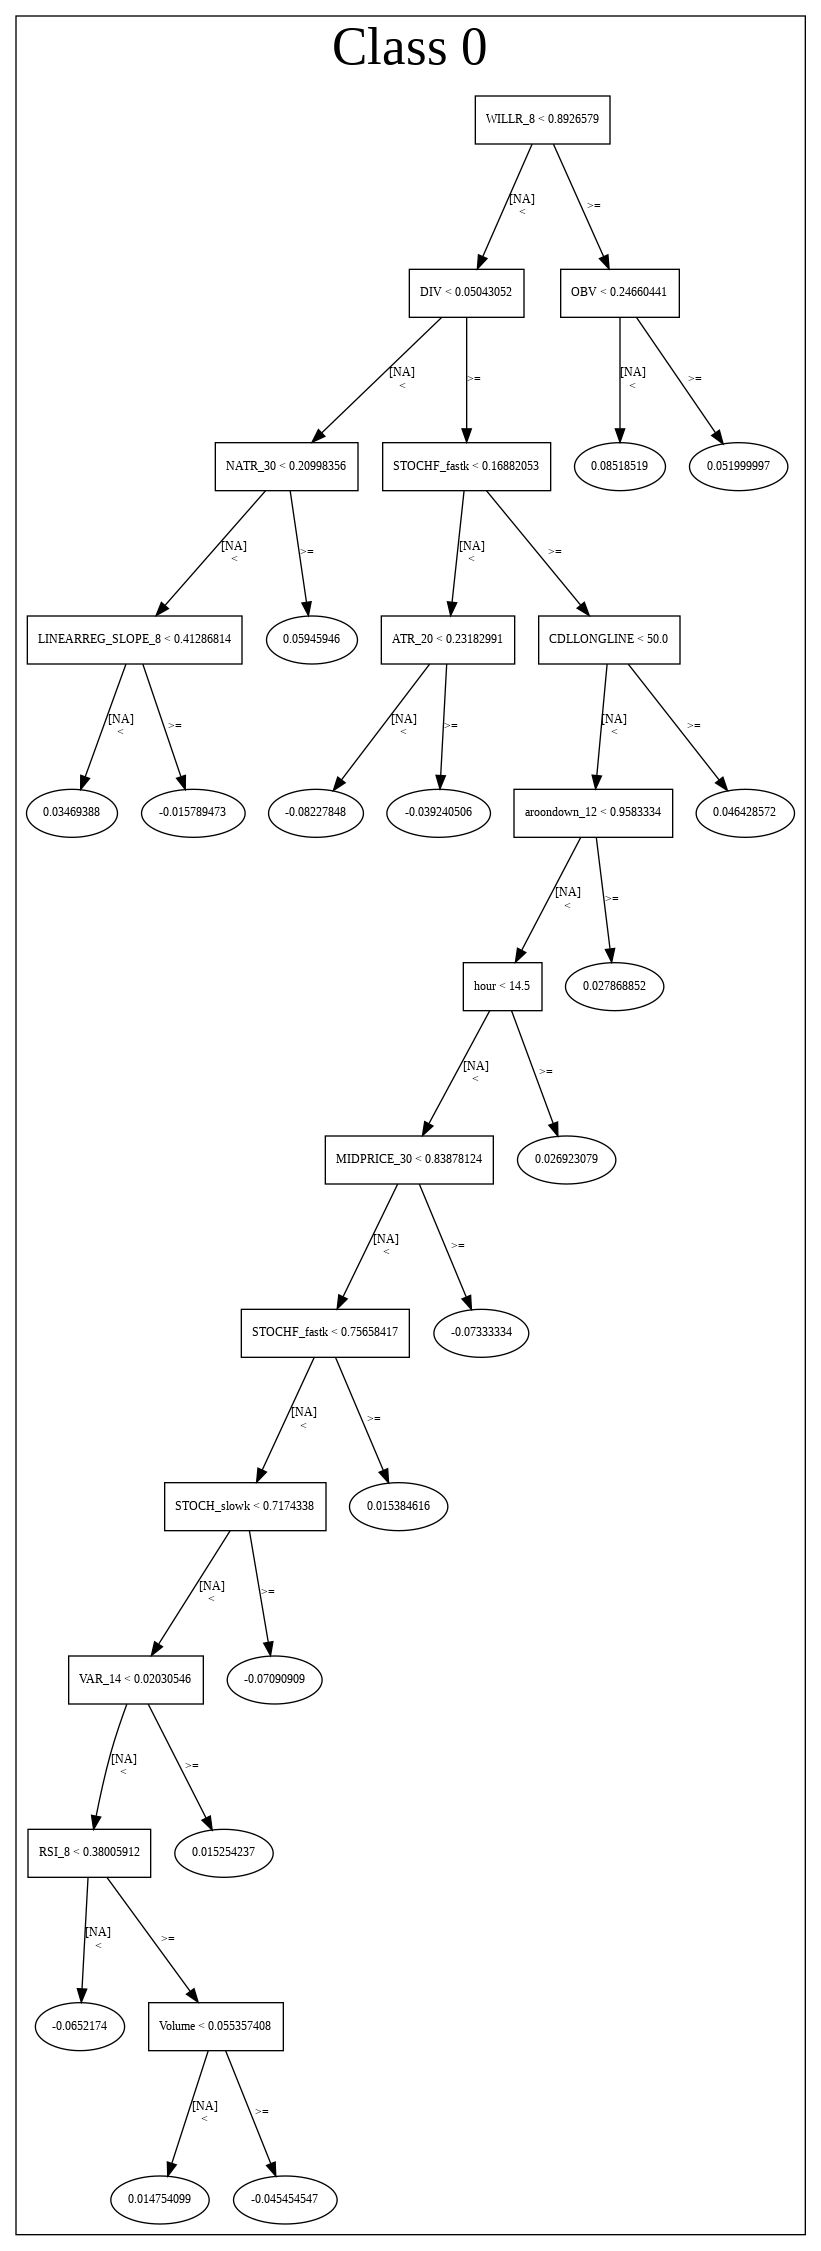

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_190438_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_190438_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'Volume',
 'DIV',
 'STOCHF_fastk',
 'WILLR_8',
 'SAREXT',
 'day',
 'hour',
 'TRANGE',
 'VAR_8',
 'STOCHRSI_fastk',
 'SUB',
 'days_in_month',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'CDLLONGLINE',
 'CDLDOJI',
 'CDLHAMMER',
 'CORREL_12',
 'CDLRICKSHAWMAN',
 'CORREL_8',
 'is_month_end',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLMORNINGSTAR',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLINVERTEDHAMMER',
 'CDLSHOOTINGSTAR',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'CDLSEPARATINGLINES',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLLADDERBOTTOM',
 'CDLTHRUSTING']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 896 916 936] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


30

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'CCI_12',
 'CMO_12',
 'RSI_12',
 'WILLR_12',
 'CCI_14',
 'CMO_14',
 'RSI_14',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'WILLR_30',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLDOJI',
 'CDLENGULFING',
 'CDLHAMMER',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_190511_model_8  0.742774  0.593277              0.349457  0.448892  0.201504
1               DeepLearning_1_AutoML_20190827_190511  0.728989  0.616793              0.334879  0.458120  0.209874
2  DeepLearning_grid_1_AutoML_20190827_190511_model_6  0.725230  0.650484              0.367753  0.465215  0.216425
3  DeepLearning_grid_1_AutoML_20190827_190511_model_9  0.723642  0.602452              0.342398  0.453896  0.206022
4  DeepLearning_grid_1_AutoML_20190827_190511_model_7  0.718212  0.657158              0.358605  0.466325  0.217459
5  DeepLearning_grid_1_AutoML_20190827_190511_model_1  0.716374  0.790060              0.354678  0.489374  0.239487
6  DeepLearning_grid_1_AutoML_20190827_190511_model_5  0.714787  0.625931              0.371846  0.464049  0.215341
7  DeepLearning_grid_1_AutoML_20190827_190511_model_4  0.710610  0.703827              0.321136  0.479044  0.229483
8  DeepLearning_grid_1_AutoML_20190827_190511_model_2  0.708521  0.682440              0.369883  0.473187  0.223906
9  DeepLearning_grid_1_AutoML_20190827_190511_model_3  0.692899  0.811896              0.377235  0.489115  0.239233

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.064717
1   CDLCLOSINGMARUBOZU             0.809923           0.809923    0.052416
2                  DIV             0.723875           0.723875    0.046847
3                  SUB             0.693408           0.693408    0.044876
4          CDLLONGLINE             0.660271           0.660271    0.042731
5       STOCHRSI_fastk             0.652082           0.652082    0.042201
6              WILLR_8             0.612456           0.612456    0.039637
7            CDLHAMMER             0.603643           0.603643    0.039066
8               TRANGE             0.591626           0.591626    0.038289
9         STOCHF_fastk             0.584275           0.584275    0.037813
10         CDLBELTHOLD             0.510277           0.510277    0.033024
11   CDLLONGLEGGEDDOJI             0.492664           0.492664    0.031884
12               CCI_8             0.486244           0.486244    0.031468
13              CCI_14             0.480192           0.480192    0.031077
14              ULTOSC             0.479455           0.479455    0.031029
15              CCI_12             0.476517           0.476517    0.030839
16             CDLDOJI             0.474779           0.474779    0.030726
17            WILLR_30             0.474422           0.474422    0.030703
18        CDLENGULFING             0.473005           0.473005    0.030612
19            WILLR_12             0.433181           0.433181    0.028034
20            WILLR_20             0.420517           0.420517    0.027215
21              CMO_14             0.410271           0.410271    0.026552
22            WILLR_24             0.407270           0.407270    0.026357
23            WILLR_14             0.387070           0.387070    0.025050
24              RSI_14             0.381602           0.381602    0.024696
25              CMO_12             0.378692           0.378692    0.024508
26              RSI_12             0.352972           0.352972    0.022843
27               CMO_8             0.352173           0.352173    0.022792
28               RSI_8             0.349349           0.349349    0.022609
29         CDLMARUBOZU             0.299578           0.299578    0.019388

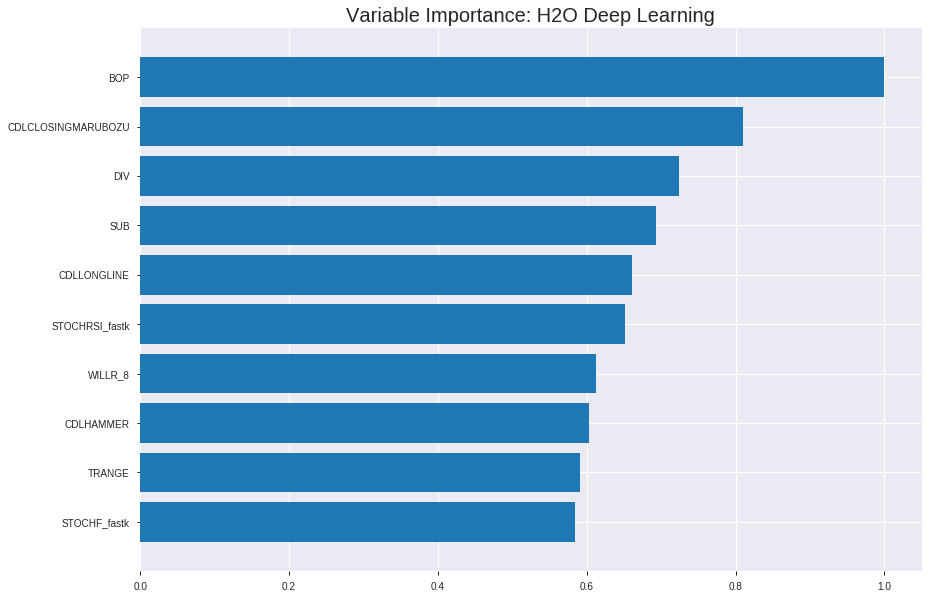

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_190511_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19406398132318275
RMSE: 0.44052693597915527
LogLoss: 0.570862975638842
Mean Per-Class Error: 0.2851051166900772
AUC: 0.7876646157701414
pr_auc: 0.7825061202582643
Gini: 0.5753292315402827
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42488558170033514: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      386  426   0.5246   (426.0/812.0)
1      83   664   0.1111   (83.0/747.0)
Total  469  1090  0.3265   (509.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424886     0.722918  246
max f2                       0.238984     0.835804  336
max f0point5                 0.633682     0.7076    123
max accuracy                 0.555553     0.715843  172
max precision                0.978421     1         0
max recall                   0.0720989    1         391
max specificity              0.978421     1         0
max absolute_mcc             0.527533     0.430182  191
max min_per_class_accuracy   0.542844     0.70936   181
max mean_per_class_accuracy  0.527533     0.714895  191

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.87493            2.08701   2.08701            1                0.914302  1                           0.914302            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.842085           2.08701   2.08701            1                0.856714  1                           0.885508            0.021419        0.042838                   108.701   108.701
    3        0.0301475                   0.819323           2.08701   2.08701            1                0.83023   1                           0.867866            0.0200803       0.0629183                  108.701   108.701
    4        0.0404105                   0.8051             2.08701   2.08701            1                0.812147  1                           0.853715            0.021419        0.0843373                  108.701   108.701
    5        0.0500321                   0.79286            1.80875   2.0335             0.866667         0.798922  0.974359                    0.843178            0.0174029       0.10174                    80.8746   103.35
    6        0.100064                    0.728871           1.87296   1.95323            0.897436         0.764569  0.935897                    0.803874            0.0937082       0.195448                   87.2962   95.3232
    7        0.150096                    0.696553           1.65891   1.85512            0.794872         0.712881  0.888889                    0.773543            0.0829987       0.278447                   65.8909   85.5124
    8        0.200128                    0.676399           1.52513   1.77262            0.730769         0.686304  0.849359                    0.751733            0.0763052       0.354752                   52.5126   77.2625
    9        0.300192                    0.636113           1.39134   1.64553            0.666667         0.658537  0.788462                    0.720668            0.139224        0.493976                   39.1343   64.5531
    10       0.400257                    0.585412           1.15053   1.52178            0.551282         0.612308  0.729167                    0.693578            0.115127        0.609103                   15.0534   52.1782
    11       0.500321                    0.539628           1.04351   1.42613            0.5              0.559316  0.683333                    0.666725            0.104418        0.713521                   4.35074   42.6127
    12       0.599743                    0.49219            0.942523  1.34596            0.451613         0.516784  0.64492                     0.641869            0.0937082       0.807229                   -5.74772  34.5957
    13       0.699808                    0.423019           0.816076  1.27019            0.391026         0.45969   0.608616                    0.615819            0.08166         0.888889                   -18.3924  27.019
    14       0.799872                    0.336221           0.46824   1.16987            0.224359         0.380819  0.560545                    0.586421            0.0468541       0.935743                   -53.176   16.9866
    15       0.899936                    0.232492           0.454862  1.09036            0.217949         0.288072  0.522452                    0.553247            0.0455154       0.981258                   -54.5138  9.03648
    16       1                           0.00404673         0.187296  1                  0.0897436        0.161997  0.479153                    0.514097           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19454576439136423
RMSE: 0.44107342290299495
LogLoss: 0.5726671130997261
Mean Per-Class Error: 0.2723983739837399
AUC: 0.7881910569105691
pr_auc: 0.7233539896646641
Gini: 0.5763821138211382
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5074785237197202: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      158  88   0.3577   (88.0/246.0)
1      38   162  0.19     (38.0/200.0)
Total  196  250  0.2825   (126.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.507479     0.72      214
max f2                       0.273218     0.819039  321
max f0point5                 0.608133     0.719178  145
max accuracy                 0.608133     0.737668  145
max precision                0.96683      1         0
max recall                   0.128789     1         381
max specificity              0.96683      1         0
max absolute_mcc             0.608133     0.466664  145
max min_per_class_accuracy   0.547558     0.715     183
max mean_per_class_accuracy  0.608133     0.727602  145

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 50.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.866463           1.784     1.784              0.8              0.918752  0.8                         0.918752            0.02            0.02                       78.4      78.4
    2        0.0201794                   0.836167           1.6725    1.73444            0.75             0.848283  0.777778                    0.887432            0.015           0.035                      67.25     73.4444
    3        0.0313901                   0.811314           1.338     1.59286            0.6              0.822022  0.714286                    0.864071            0.015           0.05                       33.8      59.2857
    4        0.0403587                   0.801191           1.6725    1.61056            0.75             0.806603  0.722222                    0.851301            0.015           0.065                      67.25     61.0556
    5        0.0515695                   0.794419           2.23      1.74522            1                0.797775  0.782609                    0.839665            0.025           0.09                       123       74.5217
    6        0.100897                    0.757534           2.02727   1.88311            0.909091         0.778249  0.844444                    0.809639            0.1             0.19                       102.727   88.3111
    7        0.150224                    0.708372           1.72318   1.8306             0.772727         0.728636  0.820896                    0.783041            0.085           0.275                      72.3182   83.0597
    8        0.201794                    0.690277           1.93913   1.85833            0.869565         0.697686  0.833333                    0.761228            0.1             0.375                      93.913    85.8333
    9        0.300448                    0.646111           1.36841   1.69746            0.613636         0.6701    0.761194                    0.731305            0.135           0.51                       36.8409   69.7463
    10       0.401345                    0.592347           1.28844   1.59464            0.577778         0.621271  0.715084                    0.703643            0.13            0.64                       28.8444   59.4637
    11       0.5                         0.534577           1.01364   1.48               0.454545         0.564165  0.663677                    0.676123            0.1             0.74                       1.36364   48
    12       0.600897                    0.479275           0.892     1.38127            0.4              0.51109   0.619403                    0.648412            0.09            0.83                       -10.8     38.1269
    13       0.699552                    0.39633            0.608182  1.27224            0.272727         0.44407   0.570513                    0.619595            0.06            0.89                       -39.1818  27.2244
    14       0.800448                    0.293726           0.545111  1.18059            0.244444         0.338228  0.529412                    0.584128            0.055           0.945                      -45.4889  18.0588
    15       0.899103                    0.215808           0.304091  1.08441            0.136364         0.253077  0.486284                    0.547803            0.03            0.975                      -69.5909  8.4414
    16       1                           0.0227098          0.247778  1                  0.111111         0.143246  0.44843                     0.506985            0.025 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:09:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:09:42  50.341 sec        737 obs/sec       0.667736  1             1041       0.524201         0.844296            -0.101059      0.688494        0.669682           2.08701          0.425914                         0.538455           0.887503              -0.172204        0.685996          0.618923             1.784              0.421525
    2019-08-27 19:09:50  58.361 sec        1184 obs/sec      6.5991    10            10288      0.453721         0.598448            0.175116       0.75682         0.73961            2.08701          0.35728                          0.444036           0.579325              0.202847         0.781413          0.729386             1.784              0.343049
    2019-08-27 19:09:57  1 min  5.925 sec  1329 obs/sec      13.2142   20            20601      0.450075         0.591129            0.188319       0.765733        0.747562           1.95658          0.322643                         0.444453           0.581047              0.201349         0.785132          0.739287             2.23               0.307175
    2019-08-27 19:10:05  1 min 13.598 sec  1424 obs/sec      20.4913   31            31946      0.462111         0.616024            0.144328       0.772773        0.755355           2.08701          0.325208                         0.458779           0.610702              0.149036         0.782724          0.720138             1.338              0.273543
    2019-08-27 19:10:13  1 min 21.380 sec  1497 obs/sec      28.3149   43            44143      0.446635         0.582443            0.200681       0.774578        0.760501           2.08701          0.297627                         0.445975           0.585024              0.195872         0.78065           0.724458             1.338              0.35426
    2019-08-27 19:10:20  1 min 28.962 sec  1555 obs/sec      36.22     55            56467      0.440527         0.570863            0.222392       0.787665        0.782506           2.08701          0.326491                         0.441073           0.572667              0.21345          0.788191          0.723354             1.784              0.282511
    2019-08-27 19:10:28  1 min 36.899 sec  1604 obs/sec      44.7601   68            69781      0.448288         0.585744            0.194752       0.79387         0.787882           2.08701          0.314304                         0.453374           0.597844              0.168967         0.786555          0.740665             1.338              0.266816
    2019-08-27 19:10:29  1 min 37.972 sec  1603 obs/sec      44.7601   68            69781      0.440527         0.570863            0.222392       0.787665        0.782506           2.08701          0.326491                         0.441073           0.572667              0.21345          0.788191          0.723354             1.784              0.282511

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.06471742281513373
CDLCLOSINGMARUBOZU  0.8099225163459778     0.8099225163459778   0.0524160979378597
DIV                 0.7238746285438538     0.7238746285438538   0.046847300400620455
SUB                 0.6934082508087158     0.6934082508087158   0.044875594951089955
CDLLONGLINE         0.6602713465690613     0.6602713465690613   0.04273105990862763
---                 ---                    ---                  ---
CMO_12              0.3786923289299011     0.3786923289299011   0.02450799156820411
RSI_12              0.3529716432094574     0.3529716432094574   0.02284341507533898
CMO_8               0.3521733283996582     0.3521733283996582   0.02279175019825362
RSI_8               0.34934866428375244    0.34934866428375244  0.022608945216353815
CDLMARUBOZU         0.29957807064056396    0.29957807064056396  0.01938792066378738


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6995515695067265)

('F1', 0.6567164179104478)

('auc', 0.7427736006683375)

('logloss', 0.5932765035439905)

('mean_per_class_error', 0.3165413533834587)

('rmse', 0.4488922638400174)

('mse', 0.20150426453541578)

deeplearning prediction progress: |███████████████████████████████████████| 100%


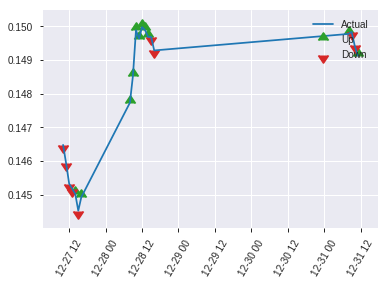


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.20150426453541578
RMSE: 0.4488922638400174
LogLoss: 0.5932765035439905
Mean Per-Class Error: 0.3165413533834587
AUC: 0.7427736006683375
pr_auc: 0.6639176273896987
Gini: 0.48554720133667506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2211949341715906: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      43   90   0.6767   (90.0/133.0)
1      2    88   0.0222   (2.0/90.0)
Total  45   178  0.4126   (92.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.221195     0.656716  177
max f2                       0.221195     0.817844  177
max f0point5                 0.567659     0.628141  76
max accuracy                 0.567659     0.699552  76
max precision                0.859286     1         0
max recall                   0.00545761   1         222
max specificity              0.859286     1         0
max absolute_mcc             0.543685     0.370652  84
max min_per_class_accuracy   0.483949     0.655556  103
max mean_per_class_accuracy  0.543685     0.683459  84

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 44.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.826014           2.47778   2.47778            1                0.84194    1                           0.84194             0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.812042           2.47778   2.47778            1                0.819897   1                           0.833123            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.804529           2.47778   2.47778            1                0.804874   1                           0.825052            0.0222222       0.0777778                  147.778   147.778
    4        0.0403587                   0.789679           2.47778   2.47778            1                0.797803   1                           0.818997            0.0222222       0.1                        147.778   147.778
    5        0.0538117                   0.780466           2.47778   2.47778            1                0.785054   1                           0.810511            0.0333333       0.133333                   147.778   147.778
    6        0.103139                    0.742484           1.80202   2.15459            0.727273         0.766608   0.869565                    0.789514            0.0888889       0.222222                   80.202    115.459
    7        0.152466                    0.683526           0.90101   1.74902            0.363636         0.7039     0.705882                    0.761815            0.0444444       0.266667                   -9.89899  74.902
    8        0.201794                    0.649217           1.35152   1.65185            0.545455         0.659711   0.666667                    0.736857            0.0666667       0.333333                   35.1515   65.1852
    9        0.300448                    0.60065            1.46414   1.59022            0.590909         0.623888   0.641791                    0.699762            0.144444        0.477778                   46.4141   59.0216
    10       0.399103                    0.52669            1.35152   1.53121            0.545455         0.564143   0.617978                    0.666239            0.133333        0.611111                   35.1515   53.1211
    11       0.502242                    0.462711           0.646377  1.3495             0.26087          0.492267   0.544643                    0.630512            0.0666667       0.677778                   -35.3623  34.9504
    12       0.600897                    0.365798           1.35152   1.34983            0.545455         0.413876   0.544776                    0.594945            0.133333        0.811111                   35.1515   34.9834
    13       0.699552                    0.293656           0.675758  1.25477            0.272727         0.329846   0.50641                     0.557559            0.0666667       0.877778                   -32.4242  25.4772
    14       0.798206                    0.217163           1.01364   1.22497            0.409091         0.260161   0.494382                    0.520802            0.1             0.977778                   1.36364   22.4969
    15       0.896861                    0.145606           0.112626  1.10261            0.0454545        0.182466   0.445                       0.483585            0.0111111       0.988889                   -88.7374  10.2611
    16       1                           0.00545761         0.107729  1                  0.0434783        0.0951251  0.403587                    

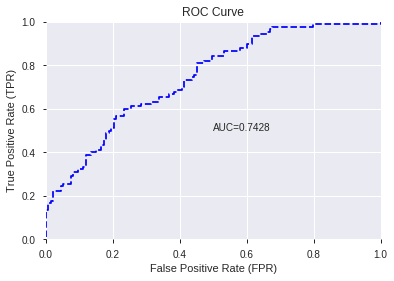

This function is available for GLM models only


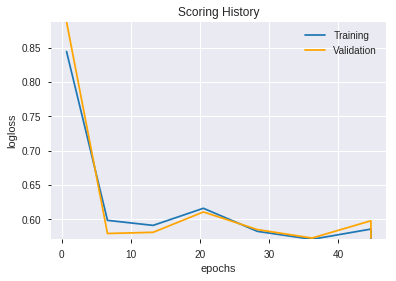

--2019-08-27 19:11:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


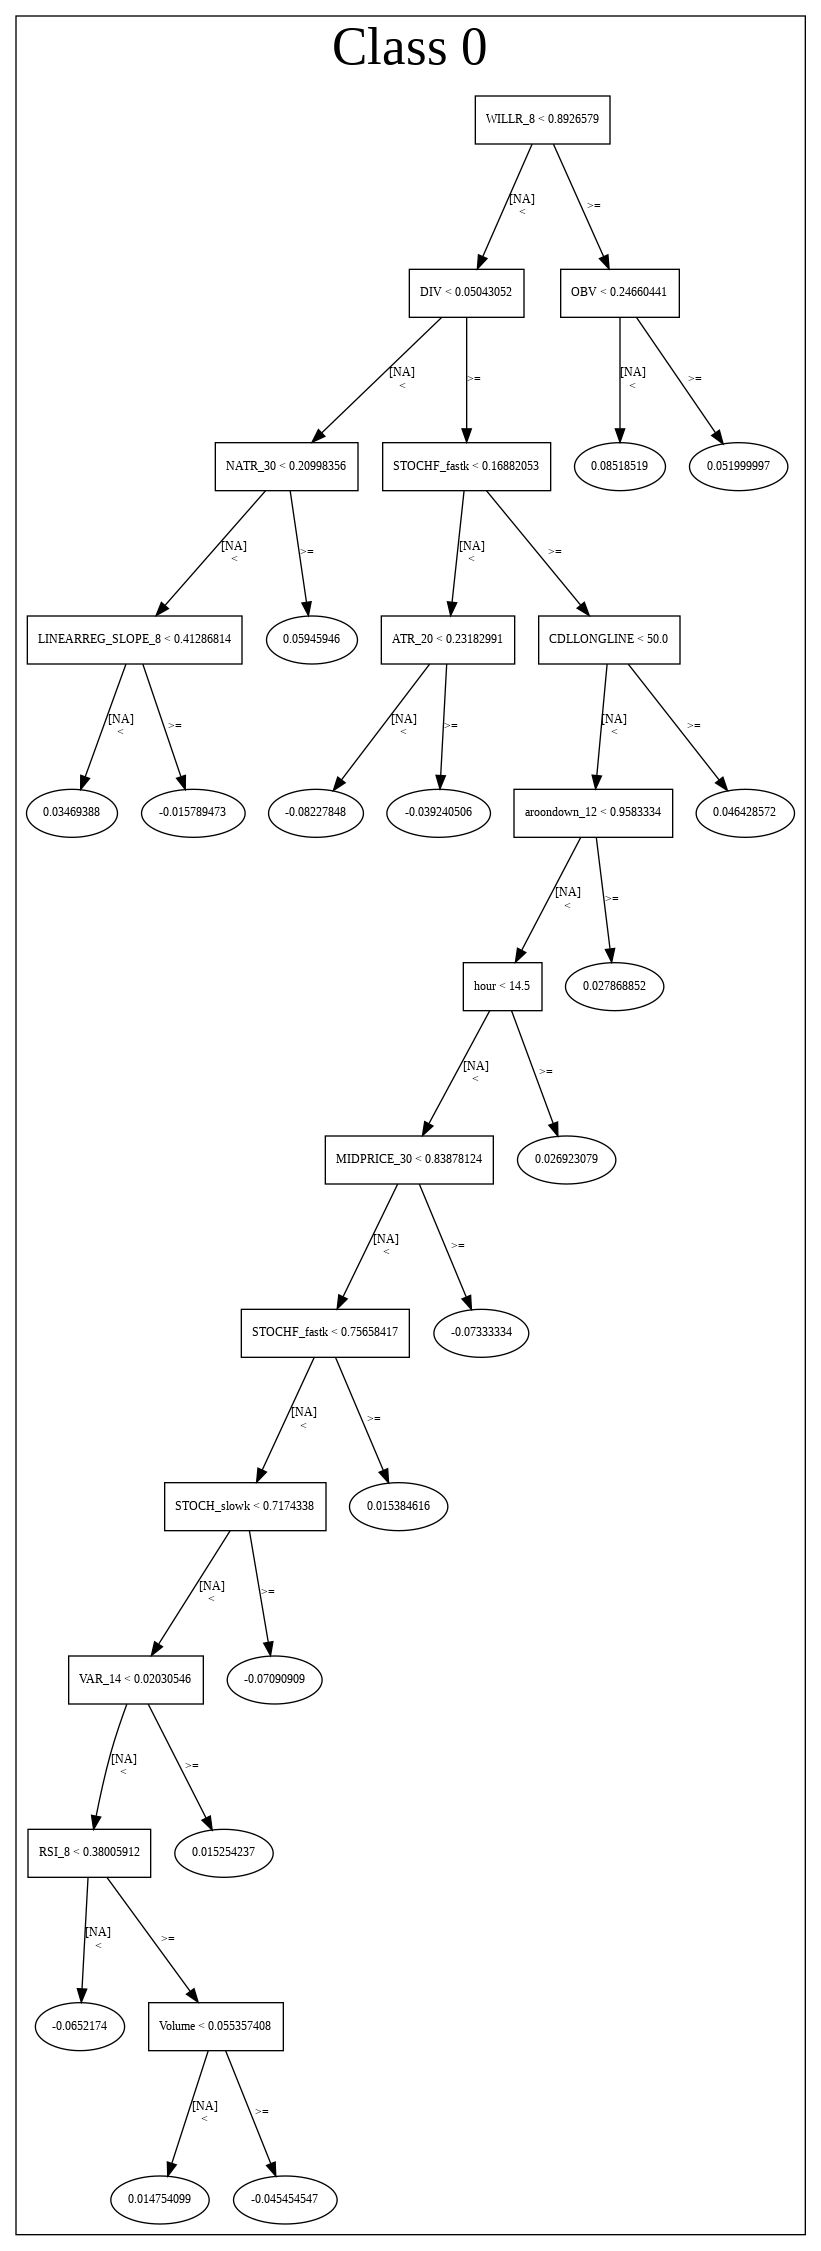

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_190511_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_190511_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'DIV',
 'SUB',
 'CDLLONGLINE',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CDLHAMMER',
 'TRANGE',
 'STOCHF_fastk',
 'CDLBELTHOLD',
 'CDLLONGLEGGEDDOJI',
 'CCI_8',
 'CCI_14',
 'ULTOSC',
 'CCI_12',
 'CDLDOJI',
 'WILLR_30',
 'CDLENGULFING',
 'WILLR_12',
 'WILLR_20',
 'CMO_14',
 'WILLR_24',
 'WILLR_14',
 'RSI_14',
 'CMO_12',
 'RSI_12',
 'CMO_8',
 'RSI_8',
 'CDLMARUBOZU']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_191144_model_1  0.726984  0.610694              0.303801  0.453676  0.205822

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.704355           1.000000    0.208655
1                  DIV             0.293505           0.416701    0.086947
2            CDLHAMMER             0.262502           0.372685    0.077763
3             WILLR_30             0.208256           0.295670    0.061693
4          CDLBELTHOLD             0.204185           0.289890    0.060487
5                  SUB             0.188421           0.267508    0.055817
6          CDLLONGLINE             0.185513           0.263380    0.054956
7   CDLCLOSINGMARUBOZU             0.178178           0.252966    0.052783
8         STOCHF_fastk             0.136146           0.193292    0.040331
9               CCI_12             0.128369           0.182250    0.038027
10            WILLR_20             0.104157           0.147876    0.030855
11              ULTOSC             0.094716           0.134473    0.028058
12               RSI_8             0.084492           0.119956    0.025029
13               CMO_8             0.082122           0.116592    0.024328
14              CMO_14             0.080293           0.113995    0.023786
15              RSI_14             0.078099           0.110880    0.023136
16   CDLLONGLEGGEDDOJI             0.066564           0.094503    0.019719
17             CDLDOJI             0.066552           0.094487    0.019715
18             WILLR_8             0.039237           0.055707    0.011623
19            WILLR_12             0.037656           0.053461    0.011155
20            WILLR_24             0.031472           0.044682    0.009323
21              CCI_14             0.031123           0.044187    0.009220
22        CDLENGULFING             0.021851           0.031022    0.006473
23               CCI_8             0.018932           0.026879    0.005608
24            WILLR_14             0.014832           0.021058    0.004394
25         CDLMARUBOZU             0.013784           0.019570    0.004083
26              RSI_12             0.008825           0.012529    0.002614
27      STOCHRSI_fastk             0.006555           0.009306    0.001942
28              CMO_12             0.004309           0.006118    0.001277
29              TRANGE             0.000685           0.000972    0.000203

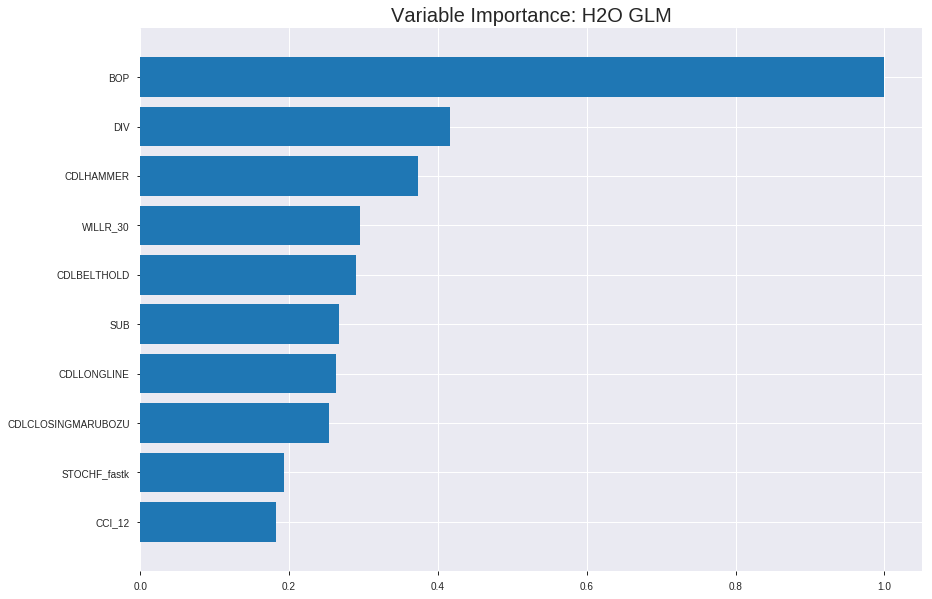

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_191144_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19930883302453442
RMSE: 0.4464401785508719
LogLoss: 0.5838616033623276
Null degrees of freedom: 1558
Residual degrees of freedom: 1528
Null deviance: 2158.5220527111505
Residual deviance: 1820.4804792837376
AIC: 1882.4804792837376
AUC: 0.7595060043128178
pr_auc: 0.7456021150737744
Gini: 0.5190120086256356
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4266450228491721: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      490  322  0.3966   (322.0/812.0)
1      167  580  0.2236   (167.0/747.0)
Total  657  902  0.3137   (489.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426645     0.703457  225
max f2                       0.0805307    0.825221  386
max f0point5                 0.54716      0.694975  166
max accuracy                 0.54716      0.701732  166
max precision                0.93456      1         0
max recall                   0.045943     1         395
max specificity              0.93456      1         0
max absolute_mcc             0.54716      0.40207   166
max min_per_class_accuracy   0.495122     0.694779  190
max mean_per_class_accuracy  0.468011     0.700759  202

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.890022           2.08701   2.08701            1                0.904603  1                           0.904603            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.876048           1.95658   2.0218             0.9375           0.881158  0.96875                     0.89288             0.0200803       0.0414993                  95.6576   102.18
    3        0.0301475                   0.859338           1.39134   1.82059            0.666667         0.867683  0.87234                     0.884839            0.0133869       0.0548862                  39.1343   82.0587
    4        0.0404105                   0.844423           2.08701   1.88825            1                0.851453  0.904762                    0.87636             0.021419        0.0763052                  108.701   88.8251
    5        0.0500321                   0.822585           2.08701   1.92648            1                0.834262  0.923077                    0.868264            0.0200803       0.0963855                  108.701   92.6475
    6        0.100064                    0.748127           1.73918   1.83283            0.833333         0.781066  0.878205                    0.824665            0.0870147       0.1834                     73.9179   83.2827
    7        0.150096                    0.710577           1.65891   1.77485            0.794872         0.727074  0.850427                    0.792135            0.0829987       0.266399                   65.8909   77.4854
    8        0.200128                    0.680492           1.49837   1.70573            0.717949         0.694401  0.817308                    0.767701            0.0749665       0.341365                   49.837    70.5733
    9        0.300192                    0.622434           1.25756   1.55634            0.602564         0.649706  0.745726                    0.72837             0.125837        0.467202                   25.756    55.6342
    10       0.400257                    0.563951           1.32445   1.49837            0.634615         0.593445  0.717949                    0.694638            0.13253         0.599732                   32.4452   49.837
    11       0.500321                    0.489442           1.05689   1.41007            0.50641          0.52879   0.675641                    0.661469            0.105756        0.705489                   5.68857   41.0073
    12       0.599743                    0.410537           0.834806  1.31471            0.4              0.448921  0.629947                    0.626233            0.0829987       0.788487                   -16.5194  31.4708
    13       0.699808                    0.349256           0.70905   1.22811            0.339744         0.379558  0.588451                    0.590962            0.0709505       0.859438                   -29.095   22.8106
    14       0.799872                    0.277251           0.655537  1.15648            0.314103         0.316303  0.55413                     0.556602            0.0655957       0.925033                   -34.4463  15.6477
    15       0.899936                    0.166703           0.428106  1.07549            0.205128         0.225721  0.515324                    0.519811            0.042838        0.967871                   -57.1894  7.54894
    16       1                           0.00101838         0.321079  1                  0.153846         0.113493  0.479153                    0.479153           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1910237367122121
RMSE: 0.4370626233301266
LogLoss: 0.5646376448903273
Null degrees of freedom: 445
Residual degrees of freedom: 415
Null deviance: 615.2252417868635
Residual deviance: 503.656779242172
AIC: 565.656779242172
AUC: 0.7838922764227643
pr_auc: 0.736811481961359
Gini: 0.5677845528455285
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35139274118974895: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      115  131  0.5325   (131.0/246.0)
1      21   179  0.105    (21.0/200.0)
Total  136  310  0.3408   (152.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.351393     0.701961  275
max f2                       0.263539     0.827586  319
max f0point5                 0.588768     0.714286  143
max accuracy                 0.588768     0.730942  143
max precision                0.907294     1         0
max recall                   0.0662653    1         391
max specificity              0.907294     1         0
max absolute_mcc             0.588768     0.453541  143
max min_per_class_accuracy   0.519071     0.71      191
max mean_per_class_accuracy  0.555366     0.723679  171

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.881586           2.23      2.23               1                0.8938    1                           0.8938              0.025           0.025                      123       123
    2        0.0201794                   0.875192           2.23      2.23               1                0.879072  1                           0.887254            0.02            0.045                      123       123
    3        0.0313901                   0.86287            1.338     1.91143            0.6              0.870034  0.857143                    0.881104            0.015           0.06                       33.8      91.1429
    4        0.0403587                   0.831691           2.23      1.98222            1                0.853082  0.888889                    0.874877            0.02            0.08                       123       98.2222
    5        0.0515695                   0.816332           2.23      2.03609            1                0.823175  0.913043                    0.863638            0.025           0.105                      123       103.609
    6        0.100897                    0.760569           1.62182   1.83356            0.727273         0.795977  0.822222                    0.830559            0.08            0.185                      62.1818   83.3556
    7        0.150224                    0.719377           1.72318   1.79731            0.772727         0.739871  0.80597                     0.800781            0.085           0.27                       72.3182   79.7313
    8        0.201794                    0.672207           1.84217   1.80878            0.826087         0.695465  0.811111                    0.773867            0.095           0.365                      84.2174   80.8778
    9        0.300448                    0.620941           1.46977   1.69746            0.659091         0.646089  0.761194                    0.73191             0.145           0.51                       46.9773   69.7463
    10       0.401345                    0.57038            1.28844   1.59464            0.577778         0.594417  0.715084                    0.697345            0.13            0.64                       28.8444   59.4637
    11       0.5                         0.50264            0.962955  1.47               0.431818         0.537567  0.659193                    0.665819            0.095           0.735                      -3.70455  47
    12       0.600897                    0.412798           0.693778  1.33966            0.311111         0.452399  0.600746                    0.629983            0.07            0.805                      -30.6222  33.9664
    13       0.699552                    0.348813           0.912273  1.27939            0.409091         0.379608  0.573718                    0.594674            0.09            0.895                      -8.77273  27.9391
    14       0.800448                    0.270068           0.545111  1.18683            0.244444         0.311248  0.532213                    0.558948            0.055           0.95                       -45.4889  18.6835
    15       0.899103                    0.161313           0.202727  1.07885            0.0909091        0.217396  0.483791                    0.521471            0.02            0.97                       -79.7273  7.88529
    16       1                           0.0165532          0.297333  1                  0.133333         0.10242   0.44843                     0.47919             0.03      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 19:11:44  0.000 sec   2            .18E2     31            1.3651351648576757  1.361843771129266
     2019-08-27 19:11:44  0.005 sec   4            .11E2     31            1.3560328750190356  1.3532667729620251
     2019-08-27 19:11:44  0.010 sec   6            .68E1     31            1.3440388404943897  1.3415601874554557
     2019-08-27 19:11:44  0.019 sec   8            .42E1     31            1.3290718674164541  1.326254679155774
     2019-08-27 19:11:44  0.025 sec   10           .26E1     31            1.3112673556988856  1.3070221459844495
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 19:11:44  0.097 sec   36           .54E-2    31            1.1666415134577592  1.1299001269763498
     2019-08-27 19:11:44  0.102 sec   38           .33E-2    31            1.1658856243077724  1.1310379013545746
     2019-08-27 19:11:44  0.109 sec   39           .21E-2    31            1.165356263995539   1.1325134781024535
     2019-08-27 19:11:44  0.115 sec   40           .13E-2    31            1.1650401463129125  1.1338074500357658
     2019-08-27 19:11:44  0.119 sec   41           .8E-3     31            1.1648381512788135  1.1350501893082923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7085201793721974)

('F1', 0.6413043478260869)

('auc', 0.726984126984127)

('logloss', 0.610694399187308)

('mean_per_class_error', 0.3036340852130326)

('rmse', 0.45367573538547895)

('mse', 0.20582167287755512)

glm prediction progress: |████████████████████████████████████████████████| 100%


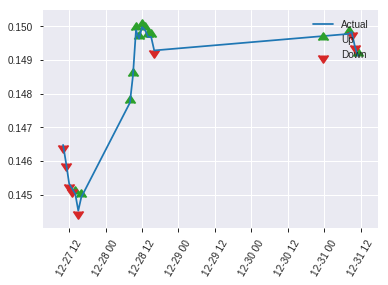


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.20582167287755512
RMSE: 0.45367573538547895
LogLoss: 0.610694399187308
Null degrees of freedom: 222
Residual degrees of freedom: 192
Null deviance: 305.94391779285456
Residual deviance: 272.36970203753935
AIC: 334.36970203753935
AUC: 0.726984126984127
pr_auc: 0.6455350243644441
Gini: 0.4539682539682539
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4818103512209405: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      98   35   0.2632   (35.0/133.0)
1      31   59   0.3444   (31.0/90.0)
Total  129  94   0.296    (66.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.48181      0.641304  93
max f2                       0.155849     0.789474  190
max f0point5                 0.51481      0.639269  86
max accuracy                 0.51481      0.70852   86
max precision                0.935459     1         0
max recall                   0.00271985   1         222
max specificity              0.935459     1         0
max absolute_mcc             0.503874     0.393456  88
max min_per_class_accuracy   0.466775     0.666667  98
max mean_per_class_accuracy  0.503874     0.696366  88

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 42.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.868898           2.47778   2.47778            1                0.892883   1                           0.892883            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.853731           2.47778   2.47778            1                0.85947    1                           0.879518            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.834852           1.23889   2.12381            0.5              0.845073   0.857143                    0.869676            0.0111111       0.0666667                  23.8889   112.381
    4        0.0403587                   0.817085           2.47778   2.20247            1                0.826654   0.888889                    0.860116            0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.797426           2.47778   2.2713             1                0.80685    0.916667                    0.846799            0.0333333       0.122222                   147.778   127.13
    6        0.103139                    0.733022           1.80202   2.04686            0.727273         0.766569   0.826087                    0.808428            0.0888889       0.211111                   80.202    104.686
    7        0.152466                    0.68459            1.35152   1.8219             0.545455         0.715712   0.735294                    0.778432            0.0666667       0.277778                   35.1515   82.1895
    8        0.201794                    0.643029           1.12626   1.65185            0.454545         0.664228   0.666667                    0.750515            0.0555556       0.333333                   12.6263   65.1852
    9        0.300448                    0.579367           1.23889   1.51625            0.5              0.611445   0.61194                     0.70485             0.122222        0.455556                   23.8889   51.6252
    10       0.399103                    0.498036           1.80202   1.58689            0.727273         0.545079   0.640449                    0.665356            0.177778        0.633333                   80.202    58.6891
    11       0.502242                    0.41614            0.646377  1.39375            0.26087          0.457683   0.5625                      0.622709            0.0666667       0.7                        -35.3623  39.375
    12       0.600897                    0.339667           0.788384  1.29436            0.318182         0.372018   0.522388                    0.581551            0.0777778       0.777778                   -21.1616  29.4362
    13       0.699552                    0.275977           0.675758  1.20712            0.272727         0.305294   0.487179                    0.542592            0.0666667       0.844444                   -32.4242  20.7123
    14       0.798206                    0.191989           0.675758  1.14145            0.272727         0.230158   0.460674                    0.503976            0.0666667       0.911111                   -32.4242  14.1448
    15       0.896861                    0.113548           0.675758  1.09022            0.272727         0.155413   0.44                        0.465634            0.0666667       0.977778                   -32.4242  9.02222
    16       1                           0.00271985         0.215459  1                  0.0869565        0.0756191  0.403587                    0

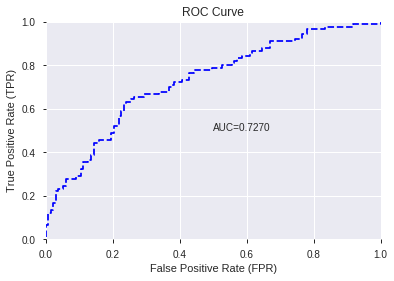

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


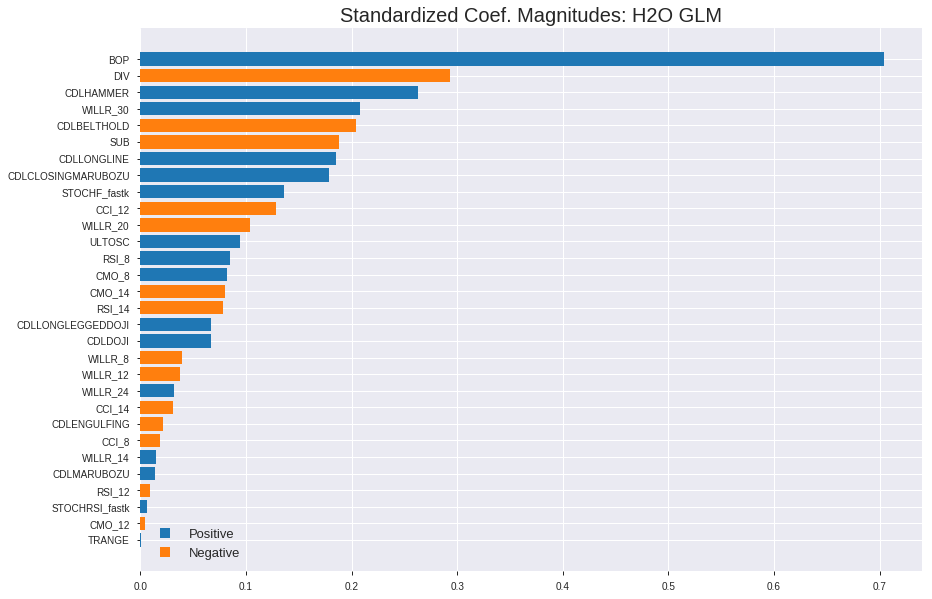

'log_likelihood'
--2019-08-27 19:11:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


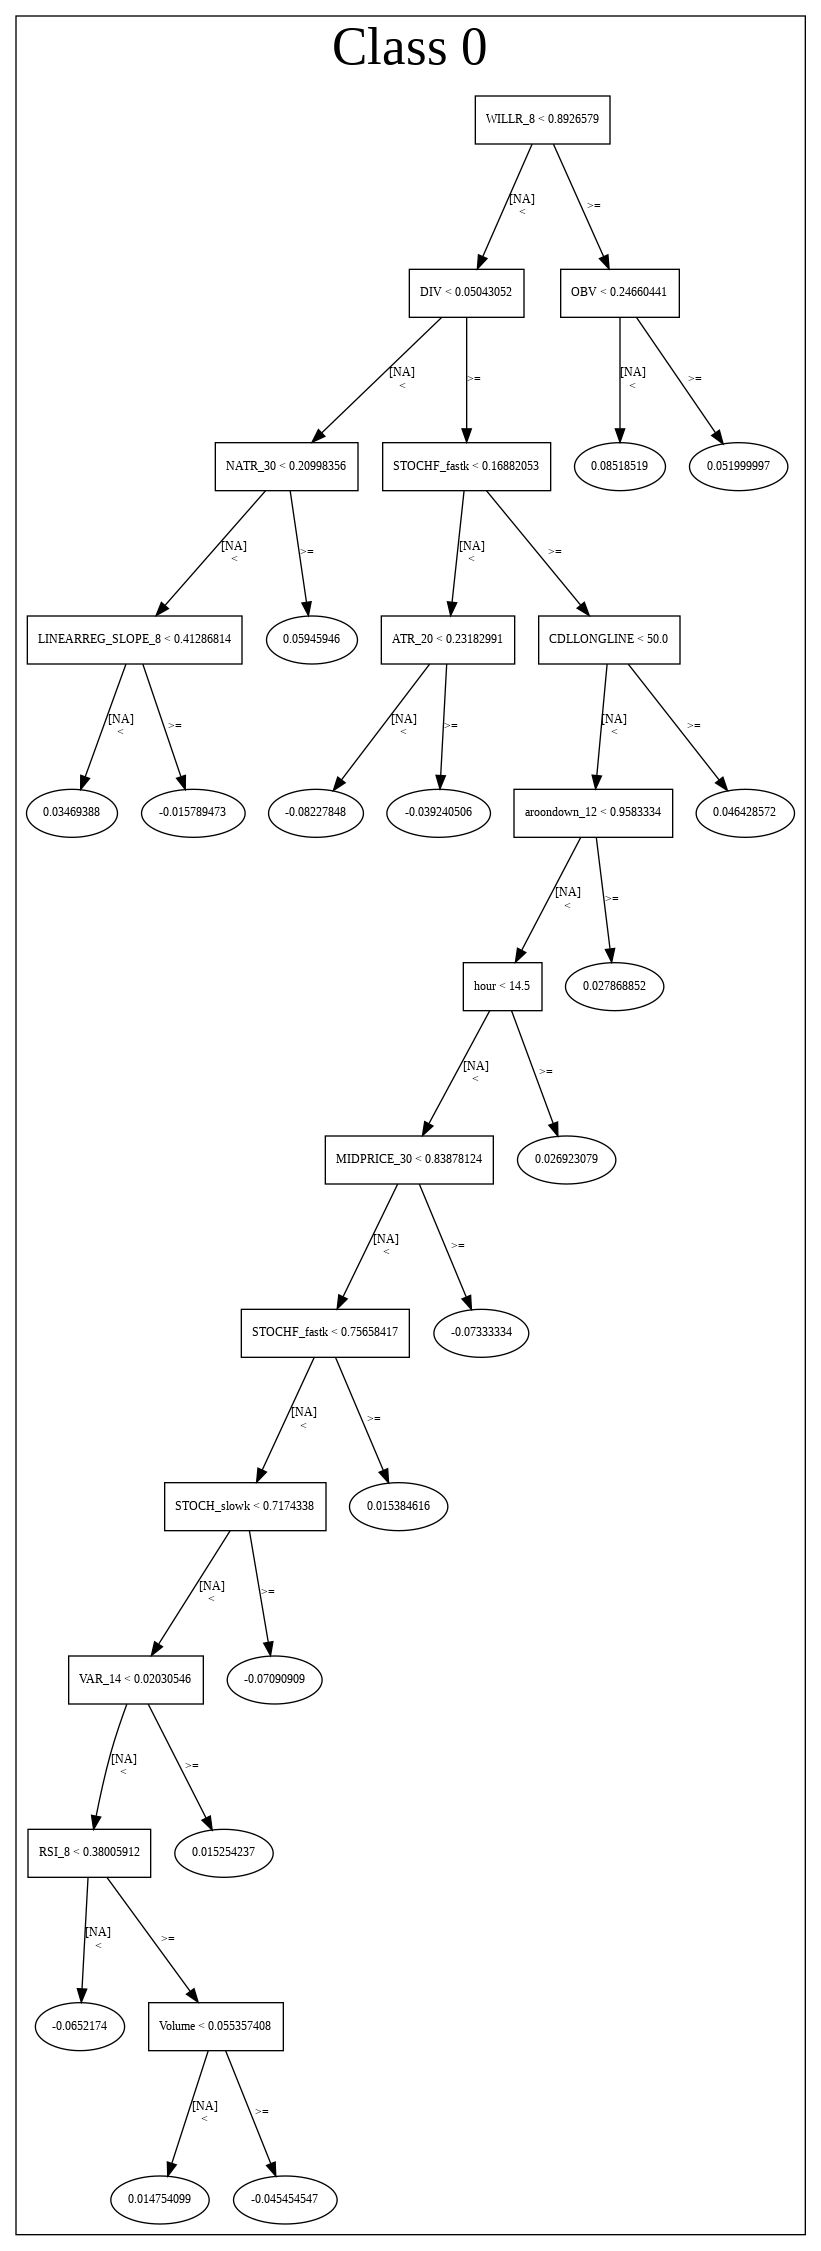

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_191144_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_191144_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'DIV',
 'CDLHAMMER',
 'WILLR_30',
 'CDLBELTHOLD',
 'SUB',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'CCI_12',
 'WILLR_20',
 'ULTOSC',
 'RSI_8',
 'CMO_8',
 'CMO_14',
 'RSI_14',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI',
 'WILLR_8',
 'WILLR_12',
 'WILLR_24',
 'CCI_14',
 'CDLENGULFING',
 'CCI_8',
 'WILLR_14',
 'CDLMARUBOZU',
 'RSI_12',
 'STOCHRSI_fastk',
 'CMO_12',
 'TRANGE']

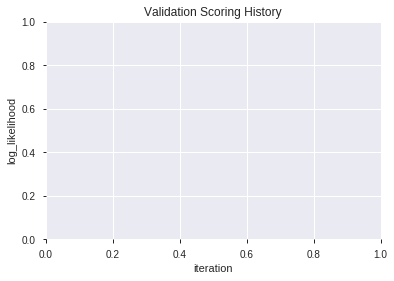

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_191208_model_3  0.764077  0.564221              0.303509  0.437621  0.191512
1               XGBoost_2_AutoML_20190827_191208  0.755472  0.573917              0.270802  0.441849  0.195231
2               XGBoost_3_AutoML_20190827_191208  0.754302  0.572023              0.300710  0.441190  0.194649
3               XGBoost_1_AutoML_20190827_191208  0.753300  0.576179              0.286007  0.443656  0.196831
4  XGBoost_grid_1_AutoML_20190827_191208_model_6  0.751963  0.573317              0.305138  0.440781  0.194288
5  XGBoost_grid_1_AutoML_20190827_191208_model_2  0.751880  0.573320              0.287636  0.441030  0.194508
6  XGBoost_grid_1_AutoML_20190827_191208_model_4  0.751629  0.575712              0.291896  0.442419  0.195735
7  XGBoost_grid_1_AutoML_20190827_191208_model_7  0.744277  0.584408              0.299248  0.446910  0.199729
8  XGBoost_grid_1_AutoML_20190827_191208_model_1  0.742774  0.586373              0.312824  0.446068  0.198977
9  XGBoost_grid_1_AutoML_20190827_191208_model_5  0.734085  0.603778              0.333083  0.454486  0.206558

variable  relative_importance  scaled_importance  percentage
0                  BOP          1022.628479           1.000000    0.166886
1                  DIV           618.321167           0.604639    0.100906
2         STOCHF_fastk           526.346436           0.514700    0.085896
3                  SUB           321.192688           0.314085    0.052416
4                CCI_8           265.017578           0.259153    0.043249
5              WILLR_8           256.570160           0.250893    0.041870
6             WILLR_12           220.613312           0.215732    0.036002
7               CCI_12           219.285645           0.214433    0.035786
8               TRANGE           215.029907           0.210272    0.035091
9             WILLR_14           211.435547           0.206757    0.034505
10            WILLR_30           208.318436           0.203709    0.033996
11      STOCHRSI_fastk           201.138062           0.196687    0.032824
12              CCI_14           187.238052           0.183095    0.030556
13              ULTOSC           175.253159           0.171375    0.028600
14         CDLLONGLINE           172.603714           0.168784    0.028168
15            WILLR_20           171.750504           0.167950    0.028028
16  CDLCLOSINGMARUBOZU           170.128372           0.166364    0.027764
17              CMO_12           157.270462           0.153790    0.025665
18            WILLR_24           156.038101           0.152585    0.025464
19              CMO_14           147.567535           0.144302    0.024082
20               CMO_8           131.791412           0.128875    0.021507
21           CDLHAMMER           109.930840           0.107498    0.017940
22               RSI_8            77.193031           0.075485    0.012597
23              RSI_12            42.129169           0.041197    0.006875
24         CDLBELTHOLD            40.651134           0.039752    0.006634
25             CDLDOJI            34.867203           0.034096    0.005690
26              RSI_14            32.342937           0.031627    0.005278
27        CDLENGULFING            21.596657           0.021119    0.003524
28         CDLMARUBOZU             8.122752           0.007943    0.001326
29   CDLLONGLEGGEDDOJI             5.350113           0.005232    0.000873

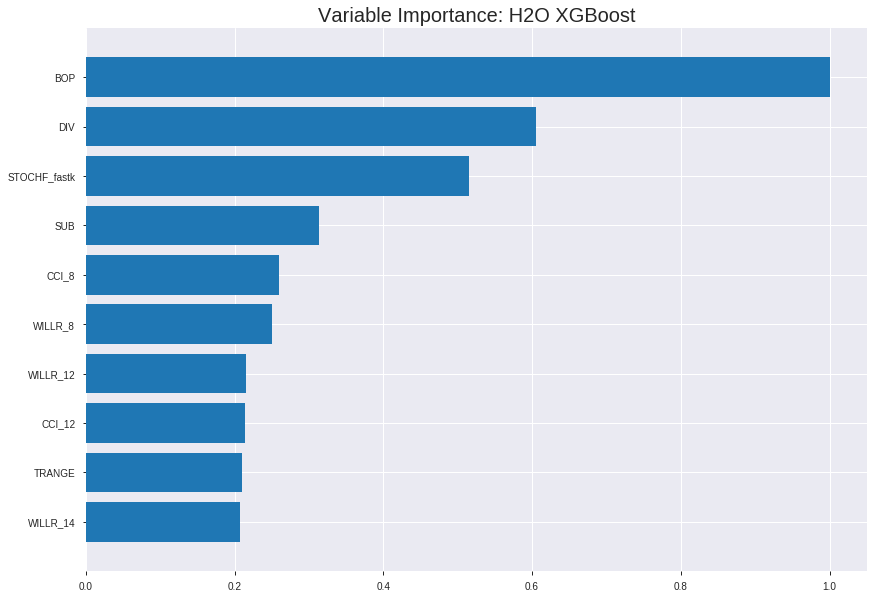

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_191208_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14923861177952313
RMSE: 0.38631413613731913
LogLoss: 0.46714441240228044
Mean Per-Class Error: 0.1965934344933098
AUC: 0.8872122315204991
pr_auc: 0.8804623716380235
Gini: 0.7744244630409982
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4547921419143677: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      621  191  0.2352   (191.0/812.0)
1      118  629  0.158    (118.0/747.0)
Total  739  820  0.1982   (309.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454792     0.802808  218
max f2                       0.282382     0.87551   299
max f0point5                 0.523959     0.80631   184
max accuracy                 0.49562      0.803079  198
max precision                0.954457     1         0
max recall                   0.128978     1         371
max specificity              0.954457     1         0
max absolute_mcc             0.454792     0.607105  218
max min_per_class_accuracy   0.485504     0.796798  204
max mean_per_class_accuracy  0.454792     0.803407  218

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 48.07 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.916729           2.08701    2.08701            1                0.927063  1                           0.927063            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.897776           2.08701    2.08701            1                0.907369  1                           0.917216            0.021419        0.042838                   108.701   108.701
    3        0.0301475                   0.885959           2.08701    2.08701            1                0.891508  1                           0.909011            0.0200803       0.0629183                  108.701   108.701
    4        0.0404105                   0.871072           2.08701    2.08701            1                0.877123  1                           0.900913            0.021419        0.0843373                  108.701   108.701
    5        0.0500321                   0.860289           2.08701    2.08701            1                0.866272  1                           0.894251            0.0200803       0.104418                   108.701   108.701
    6        0.100064                    0.794927           1.95323    2.02012            0.935897         0.826627  0.967949                    0.860439            0.0977242       0.202142                   95.3232   102.012
    7        0.150096                    0.749234           2.00674    2.01566            0.961538         0.771122  0.965812                    0.830667            0.100402        0.302544                   100.674   101.566
    8        0.200128                    0.711224           1.92648    1.99337            0.923077         0.729519  0.955128                    0.80538             0.0963855       0.398929                   92.6475   99.3367
    9        0.300192                    0.625398           1.61877    1.8685             0.775641         0.668443  0.895299                    0.759734            0.161981        0.56091                    61.8774   86.8503
    10       0.400257                    0.54894            1.35121    1.73918            0.647436         0.590343  0.833333                    0.717386            0.135207        0.696118                   35.1208   73.9179
    11       0.500321                    0.475205           1.17729    1.6268             0.564103         0.510203  0.779487                    0.67595             0.117805        0.813922                   17.729    62.6801
    12       0.599743                    0.405749           0.794412   1.48881            0.380645         0.440104  0.713369                    0.636852            0.0789826       0.892905                   -20.5588  48.8812
    13       0.699808                    0.327812           0.561889   1.35627            0.269231         0.366774  0.649863                    0.598234            0.0562249       0.94913                    -43.8111  35.6273
    14       0.799872                    0.243956           0.361214   1.23179            0.173077         0.285883  0.590217                    0.559159            0.0361446       0.985274                   -63.8786  23.1791
    15       0.899936                    0.174762           0.0936481  1.10524            0.0448718        0.208336  0.529579                    0.520151            0.00937082      0.994645                   -90.6352  10.524
    16       1                           0.0540556          0.0535132  1                  0.025641         0.125949  0.479153                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19051564180972624
RMSE: 0.4364809753124714
LogLoss: 0.5631297991608635
Mean Per-Class Error: 0.28026422764227643
AUC: 0.7786890243902439
pr_auc: 0.7262709816793441
Gini: 0.5573780487804878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4442616403102875: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      161  85   0.3455   (85.0/246.0)
1      43   157  0.215    (43.0/200.0)
Total  204  242  0.287    (128.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444262     0.710407  216
max f2                       0.238631     0.820312  315
max f0point5                 0.636905     0.690407  108
max accuracy                 0.514704     0.715247  177
max precision                0.923938     1         0
max recall                   0.0569937    1         397
max specificity              0.923938     1         0
max absolute_mcc             0.444262     0.438723  216
max min_per_class_accuracy   0.492486     0.707317  190
max mean_per_class_accuracy  0.444262     0.719736  216

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.905195           2.23      2.23               1                0.91517   1                           0.91517             0.025           0.025                      123       123
    2        0.0201794                   0.882361           1.6725    1.98222            0.75             0.894729  0.888889                    0.906085            0.015           0.04                       67.25     98.2222
    3        0.0313901                   0.867919           2.23      2.07071            1                0.876031  0.928571                    0.895352            0.025           0.065                      123       107.071
    4        0.0403587                   0.860049           2.23      2.10611            1                0.862367  0.944444                    0.888022            0.02            0.085                      123       110.611
    5        0.0515695                   0.84709            1.784     2.03609            0.8              0.855395  0.913043                    0.880929            0.02            0.105                      78.4      103.609
    6        0.100897                    0.794475           1.62182   1.83356            0.727273         0.817868  0.822222                    0.850099            0.08            0.185                      62.1818   83.3556
    7        0.150224                    0.740965           1.72318   1.79731            0.772727         0.767724  0.80597                     0.82305             0.085           0.27                       72.3182   79.7313
    8        0.201794                    0.701234           1.45435   1.70967            0.652174         0.721004  0.766667                    0.796972            0.075           0.345                      45.4348   70.9667
    9        0.300448                    0.613624           1.62182   1.68082            0.727273         0.658098  0.753731                    0.751372            0.16            0.505                      62.1818   68.0821
    10       0.401345                    0.540244           1.09022   1.53235            0.488889         0.57514   0.687151                    0.707067            0.11            0.615                      9.02222   53.2346
    11       0.5                         0.474964           1.21636   1.47               0.545455         0.509597  0.659193                    0.668105            0.12            0.735                      21.6364   47
    12       0.600897                    0.396486           0.693778  1.33966            0.311111         0.435663  0.600746                    0.629075            0.07            0.805                      -30.6222  33.9664
    13       0.699552                    0.312489           0.962955  1.28654            0.431818         0.35635   0.576923                    0.590614            0.095           0.9                        -3.70455  28.6538
    14       0.800448                    0.228511           0.446     1.18059            0.2              0.268087  0.529412                    0.549959            0.045           0.945                      -55.4     18.0588
    15       0.899103                    0.164404           0.354773  1.08998            0.159091         0.193905  0.488778                    0.510891            0.035           0.98                       -64.5227  8.99751
    16       1                           0.0555359          0.198222  1                  0.0888889        0.113014  0.44843                     0.470746            0.02  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:12:14  1.929 sec   0                  0.5              0.693147            0.5             0                  1                0.520847                         0.5                0.693147              0.5               0                    1                  0.55157
    2019-08-27 19:12:14  2.018 sec   5                  0.478434         0.650693            0.79572         0.783804           2.08701          0.304041                         0.480421           0.654517              0.759035          0.712847             2.23               0.309417
    2019-08-27 19:12:15  2.082 sec   10                 0.458623         0.612336            0.82472         0.815812           2.08701          0.280308                         0.46359            0.621716              0.782378          0.722177             2.23               0.266816
    2019-08-27 19:12:15  2.152 sec   15                 0.444551         0.58486             0.830554        0.821727           2.08701          0.261065                         0.452936           0.600538              0.784441          0.72759              2.23               0.269058
    2019-08-27 19:12:15  2.215 sec   20                 0.434397         0.564591            0.837875        0.830268           2.08701          0.252726                         0.447177           0.588435              0.782754          0.729379             2.23               0.282511
    2019-08-27 19:12:15  2.277 sec   25                 0.425863         0.547459            0.8448          0.836564           2.08701          0.242463                         0.444603           0.582466              0.776037          0.722071             2.23               0.286996
    2019-08-27 19:12:15  2.343 sec   30                 0.418066         0.531782            0.853218        0.847348           2.08701          0.237332                         0.442542           0.577578              0.775244          0.718615             2.23               0.280269
    2019-08-27 19:12:15  2.406 sec   35                 0.412689         0.520826            0.859414        0.853823           2.08701          0.225786                         0.440281           0.572784              0.777876          0.721293             2.23               0.278027
    2019-08-27 19:12:15  2.477 sec   40                 0.407795         0.510534            0.862324        0.858042           2.08701          0.224503                         0.438782           0.569529              0.77875           0.718551             1.784              0.282511
    2019-08-27 19:12:15  2.542 sec   45                 0.404064         0.502723            0.866162        0.861601           2.08701          0.225144                         0.436604           0.564539              0.782663          0.725263             1.784              0.286996
    2019-08-27 19:12:15  2.608 sec   50                 0.400541         0.495553            0.870592        0.864678           2.08701          0.21873                          0.436402           0.563699              0.781301          0.724097             1.784              0.275785
    2019-08-27 19:12:15  2.683 sec   55                 0.397169         0.488597            0.874373        0.867995           2.08701          0.217447                         0.435596           0.561873              0.781758          0.

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
BOP                1022.6284790039062     1.0                   0.16688557100391224
DIV                618.3211669921875      0.6046391037285258    0.10090554207702876
STOCHF_fastk       526.346435546875       0.5146995671972328    0.08589593116717668
SUB                321.19268798828125     0.3140854128188761    0.052416323462277634
CCI_8              265.017578125          0.25915333238434846   0.04324895185252865
---                ---                    ---                   ---
CDLDOJI            34.86720275878906      0.03409566961478674   0.005690075292424425
RSI_14             32.34293746948242      0.03162726066556071   0.005278133455461673
CDLENGULFING       21.596656799316406     0.02111877113020819   0.0035244181789657308
CDLMARUBOZU        8.12275218963623       0.00794301386711645   0.0013255744047057218
CDLLONGLEGGEDDOJI  5.3501129150390625     0.005231726892889149  0.0008730997298563291


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.6753246753246753)

('auc', 0.7640768588137009)

('logloss', 0.5642208413692215)

('mean_per_class_error', 0.2943191311612364)

('rmse', 0.43762127491257763)

('mse', 0.19151238025610984)

xgboost prediction progress: |████████████████████████████████████████████| 100%


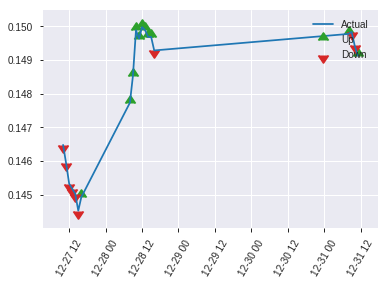


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19151238025610984
RMSE: 0.43762127491257763
LogLoss: 0.5642208413692215
Mean Per-Class Error: 0.2943191311612364
AUC: 0.7640768588137009
pr_auc: 0.7033577500019016
Gini: 0.5281537176274018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29621973633766174: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      70   63   0.4737   (63.0/133.0)
1      12   78   0.1333   (12.0/90.0)
Total  82   141  0.3363   (75.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29622      0.675325  140
max f2                       0.152951     0.786618  192
max f0point5                 0.70162      0.691057  38
max accuracy                 0.70162      0.726457  38
max precision                0.912383     1         0
max recall                   0.0669722    1         221
max specificity              0.912383     1         0
max absolute_mcc             0.70162      0.439359  38
max min_per_class_accuracy   0.426208     0.684211  103
max mean_per_class_accuracy  0.49993      0.705681  88

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 42.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.885252           2.47778   2.47778            1                0.901946  1                           0.901946            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.853585           2.47778   2.47778            1                0.863133  1                           0.88642             0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.848249           2.47778   2.47778            1                0.850148  1                           0.876057            0.0222222       0.0777778                  147.778   147.778
    4        0.0403587                   0.829978           2.47778   2.47778            1                0.839456  1                           0.867923            0.0222222       0.1                        147.778   147.778
    5        0.0538117                   0.811852           1.65185   2.2713             0.666667         0.818854  0.916667                    0.855656            0.0222222       0.122222                   65.1852   127.13
    6        0.103139                    0.779285           2.02727   2.15459            0.818182         0.7899    0.869565                    0.824208            0.1             0.222222                   102.727   115.459
    7        0.152466                    0.71486            2.25253   2.18627            0.909091         0.740722  0.882353                    0.797197            0.111111        0.333333                   125.253   118.627
    8        0.201794                    0.678229           1.35152   1.98222            0.545455         0.697702  0.8                         0.772876            0.0666667       0.4                        35.1515   98.2222
    9        0.300448                    0.579072           0.90101   1.6272             0.363636         0.619986  0.656716                    0.722674            0.0888889       0.488889                   -9.89899  62.7197
    10       0.399103                    0.497666           1.57677   1.61473            0.636364         0.539725  0.651685                    0.67745             0.155556        0.644444                   57.6768   61.4732
    11       0.502242                    0.407064           0.754106  1.438              0.304348         0.45085   0.580357                    0.630916            0.0777778       0.722222                   -24.5894  43.7996
    12       0.600897                    0.322497           0.90101   1.34983            0.363636         0.364987  0.544776                    0.587256            0.0888889       0.811111                   -9.89899  34.9834
    13       0.699552                    0.257658           0.788384  1.27066            0.318182         0.285031  0.512821                    0.544635            0.0777778       0.888889                   -21.1616  27.0655
    14       0.798206                    0.194784           0.337879  1.15537            0.136364         0.22209   0.466292                    0.50477             0.0333333       0.922222                   -66.2121  15.5368
    15       0.896861                    0.141833           0.450505  1.07783            0.181818         0.160858  0.435                       0.466939            0.0444444       0.966667                   -54.9495  7.78333
    16       1                           0.0616974          0.323188  1                  0.130435         0.102631  0.403587                    0.429365          

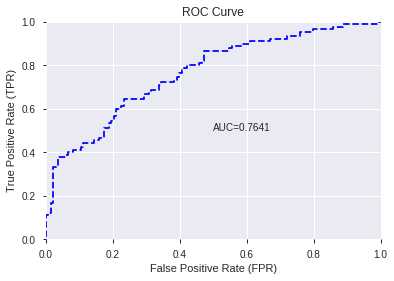

This function is available for GLM models only


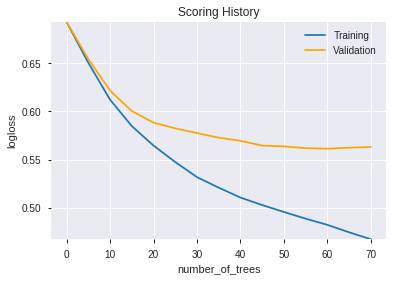

--2019-08-27 19:12:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

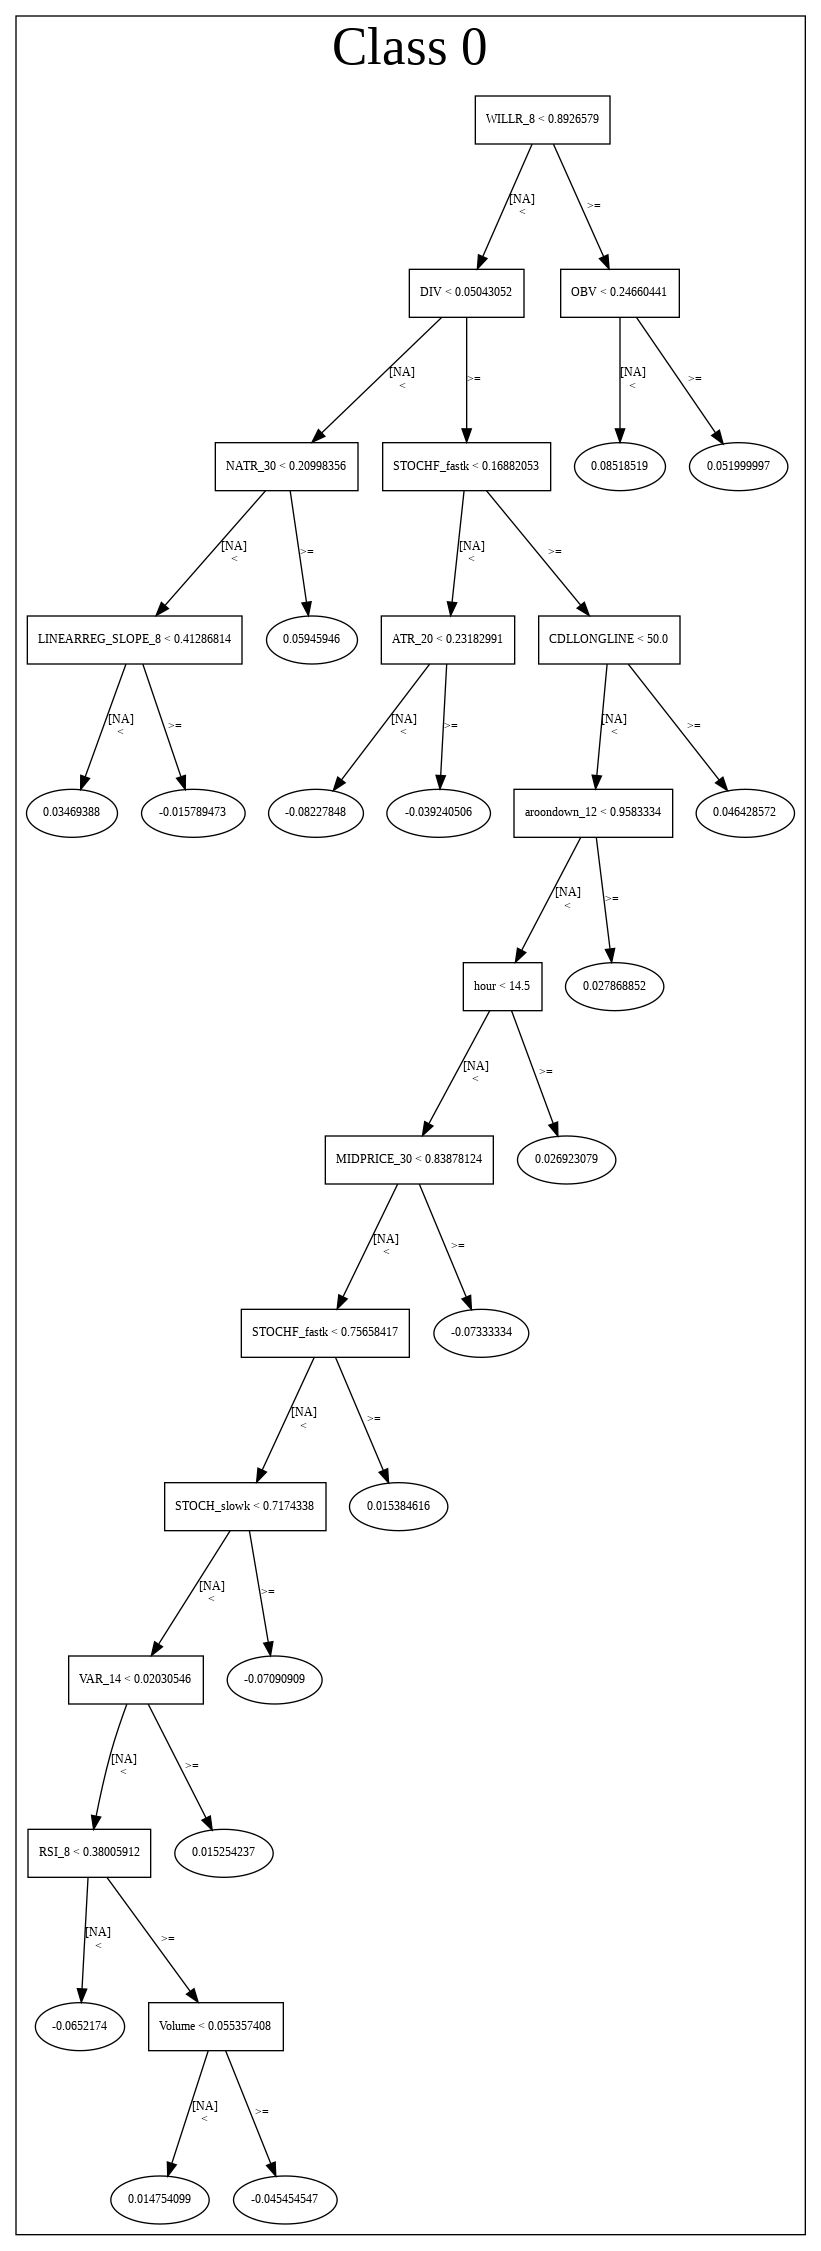

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_191208_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_191208_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'DIV',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'WILLR_8',
 'WILLR_12',
 'CCI_12',
 'TRANGE',
 'WILLR_14',
 'WILLR_30',
 'STOCHRSI_fastk',
 'CCI_14',
 'ULTOSC',
 'CDLLONGLINE',
 'WILLR_20',
 'CDLCLOSINGMARUBOZU',
 'CMO_12',
 'WILLR_24',
 'CMO_14',
 'CMO_8',
 'CDLHAMMER',
 'RSI_8',
 'RSI_12',
 'CDLBELTHOLD',
 'CDLDOJI',
 'RSI_14',
 'CDLENGULFING',
 'CDLMARUBOZU',
 'CDLLONGLEGGEDDOJI']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

101

['WMA_20',
 'MA_20_2',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_20_3_3',
 'BBANDS_upperband_20_3_5',
 'BBANDS_upperband_20_6_4',
 'BBANDS_middleband_20_6_4',
 'BBANDS_upperband_20_6_5',
 'BBANDS_middleband_20_7_3',
 'MA_24_5',
 'BBANDS_upperband_24_5_4',
 'BBANDS_upperband_24_5_5',
 'BBANDS_lowerband_24_6_4',
 'BOP',
 'ADX_8',
 'ADXR_8',
 'AROONOSC_8',
 'CCI_8',
 'DX_8',
 'MACDFIX_signal_8',
 'MACDFIX_hist_8',
 'MINUS_DM_8',
 'ROCP_8',
 'ROCR_8',
 'WILLR_8',
 'aroondown_12',
 'MFI_12',
 'ROC_12',
 'WILLR_12',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MACDFIX_signal_14',
 'MFI_14',
 'PLUS_DI_14',
 'PLUS_DM_14',
 'ROC_14',
 'ROCP_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'MFI_20',
 'MINUS_DI_20',
 'MOM_20',
 'PLUS_DI_20',
 'ROCP_20',
 'WILLR_20',
 'ADX_24',
 'aroondown_24',
 'AROONOSC_24',
 'DX_24',
 'MACDFIX_signal_24',
 'MINUS_DI_24',
 'PLUS_DM_24',
 'ROC_24',
 'ROCP_24',
 'WILLR_24',
 'aroondown_30',
 

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_191359_model_9  0.736424  0.600345              0.281412  0.453666  0.205813
1  DeepLearning_grid_1_AutoML_20190827_191359_model_8  0.734754  0.726378              0.288764  0.473293  0.224007
2  DeepLearning_grid_1_AutoML_20190827_191359_model_6  0.731328  0.626562              0.300710  0.457161  0.208996
3  DeepLearning_grid_1_AutoML_20190827_191359_model_3  0.726566  0.772385              0.296449  0.477764  0.228258
4  DeepLearning_grid_1_AutoML_20190827_191359_model_5  0.726399  0.616775              0.317878  0.455724  0.207684
5  DeepLearning_grid_1_AutoML_20190827_191359_model_4  0.719465  0.738246              0.307101  0.484722  0.234955
6  DeepLearning_grid_1_AutoML_20190827_191359_model_7  0.705180  0.717501              0.329156  0.475366  0.225973
7  DeepLearning_grid_1_AutoML_20190827_191359_model_2  0.701253  0.718630              0.315748  0.475052  0.225675
8               DeepLearning_1_AutoML_20190827_191359  0.696157  0.686222              0.377402  0.478088  0.228568
9  DeepLearning_grid_1_AutoML_20190827_191359_model_1  0.695489  1.109354              0.327527  0.514327  0.264532

variable  relative_importance  scaled_importance  percentage
0                      TRANGE             1.000000           1.000000    0.031485
1                         BOP             0.791155           0.791155    0.024910
2                 CDLLONGLINE             0.705813           0.705813    0.022223
3          CDLCLOSINGMARUBOZU             0.692444           0.692444    0.021802
4           CDLLONGLEGGEDDOJI             0.485571           0.485571    0.015288
..                        ...                  ...                ...         ...
96                   WILLR_20             0.266026           0.266026    0.008376
97                     MOM_30             0.264916           0.264916    0.008341
98                     ROCP_8             0.264230           0.264230    0.008319
99                   WILLR_24             0.260906           0.260906    0.008215
100  BBANDS_middleband_20_7_3             0.260808           0.260808    0.008212

[101 rows x 4 columns]

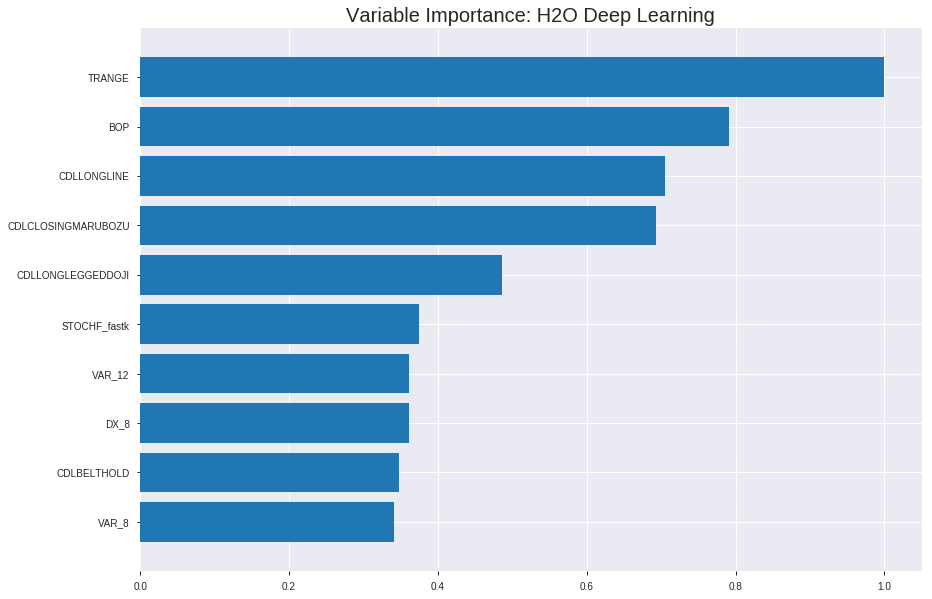

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_191359_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1977759119760136
RMSE: 0.44472003774960894
LogLoss: 0.5797570178818136
Mean Per-Class Error: 0.2960553214500037
AUC: 0.7689979952651328
pr_auc: 0.7524297775985188
Gini: 0.5379959905302656
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44640609460741426: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      523  289  0.3559   (289.0/812.0)
1      179  568  0.2396   (179.0/747.0)
Total  702  857  0.3002   (468.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446406     0.708229  223
max f2                       0.243293     0.835613  343
max f0point5                 0.509929     0.697602  182
max accuracy                 0.466579     0.703015  209
max precision                0.890934     1         0
max recall                   0.127058     1         391
max specificity              0.890934     1         0
max absolute_mcc             0.453226     0.408231  218
max min_per_class_accuracy   0.466579     0.700739  209
max mean_per_class_accuracy  0.453226     0.703945  218

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 48.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.875742           2.08701   2.08701            1                0.880922  1                           0.880922            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.864967           1.95658   2.0218             0.9375           0.87127   0.96875                     0.876096            0.0200803       0.0414993                  95.6576   102.18
    3        0.0301475                   0.852278           1.80875   1.9538             0.866667         0.857496  0.93617                     0.87016             0.0174029       0.0589023                  80.8746   95.3801
    4        0.0404105                   0.837297           1.6957    1.88825            0.8125           0.843258  0.904762                    0.863328            0.0174029       0.0763052                  69.5699   88.8251
    5        0.0500321                   0.817493           1.94788   1.89972            0.933333         0.827384  0.910256                    0.856416            0.0187416       0.0950469                  94.788    89.9719
    6        0.100064                    0.759227           1.76594   1.83283            0.846154         0.787072  0.878205                    0.821744            0.0883534       0.1834                     76.5936   83.2827
    7        0.150096                    0.706184           1.63215   1.76594            0.782051         0.730914  0.846154                    0.791467            0.08166         0.26506                    63.2153   76.5936
    8        0.200128                    0.650091           1.57864   1.71911            0.75641          0.674814  0.823718                    0.762304            0.0789826       0.344043                   57.8639   71.9111
    9        0.300192                    0.565654           1.37796   1.6054             0.660256         0.606626  0.769231                    0.710411            0.137885        0.481928                   37.7965   60.5396
    10       0.400257                    0.508212           1.21743   1.5084             0.583333         0.534781  0.722756                    0.666504            0.121821        0.603748                   21.7425   50.8403
    11       0.500321                    0.461502           1.07026   1.42078            0.512821         0.48407   0.680769                    0.630017            0.107095        0.710843                   7.0264    42.0775
    12       0.599743                    0.429739           0.794412  1.31694            0.380645         0.445976  0.631016                    0.599507            0.0789826       0.789826                   -20.5588  31.694
    13       0.699808                    0.386243           0.78932   1.2415             0.378205         0.40923   0.594867                    0.5723              0.0789826       0.868809                   -21.068   24.1496
    14       0.799872                    0.319415           0.615402  1.16317            0.294872         0.355663  0.557338                    0.545199            0.0615797       0.930388                   -38.4598  16.3172
    15       0.899936                    0.23698            0.508375  1.09036            0.24359          0.280665  0.522452                    0.515785            0.0508701       0.981258                   -49.1625  9.03648
    16       1                           0.0583875          0.187296  1                  0.0897436        0.184239  0.479153                    0.482609           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.19682550697370865
RMSE: 0.4436502079045029
LogLoss: 0.5789038715669859
Mean Per-Class Error: 0.2944512195121951
AUC: 0.7674796747967481
pr_auc: 0.7275132352533491
Gini: 0.5349593495934961
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44396124302018003: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      162  84   0.3415   (84.0/246.0)
1      50   150  0.25     (50.0/200.0)
Total  212  234  0.3004   (134.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.443961     0.691244  211
max f2                       0.219112     0.815574  375
max f0point5                 0.572134     0.714286  106
max accuracy                 0.572134     0.717489  106
max precision                0.877783     1         0
max recall                   0.201404     1         382
max specificity              0.877783     1         0
max absolute_mcc             0.572134     0.440355  106
max min_per_class_accuracy   0.456531     0.7       194
max mean_per_class_accuracy  0.471177     0.705549  175

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 47.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.863757           2.23      2.23               1                0.869288  1                           0.869288            0.025           0.025                      123       123
    2        0.0201794                   0.853221           1.6725    1.98222            0.75             0.860716  0.888889                    0.865478            0.015           0.04                       67.25     98.2222
    3        0.0313901                   0.845729           2.23      2.07071            1                0.850548  0.928571                    0.860146            0.025           0.065                      123       107.071
    4        0.0403587                   0.839481           1.6725    1.98222            0.75             0.841501  0.888889                    0.856003            0.015           0.08                       67.25     98.2222
    5        0.0515695                   0.831244           2.23      2.03609            1                0.835521  0.913043                    0.85155             0.025           0.105                      123       103.609
    6        0.100897                    0.737915           1.62182   1.83356            0.727273         0.777217  0.822222                    0.81521             0.08            0.185                      62.1818   83.3556
    7        0.150224                    0.699959           1.92591   1.86388            0.863636         0.717871  0.835821                    0.783248            0.095           0.28                       92.5909   86.3881
    8        0.201794                    0.638418           1.5513    1.784              0.695652         0.673362  0.8                         0.755166            0.08            0.36                       55.1304   78.4
    9        0.300448                    0.533195           1.52045   1.69746            0.681818         0.5845    0.761194                    0.699127            0.15            0.51                       52.0455   69.7463
    10       0.401345                    0.484012           1.04067   1.53235            0.466667         0.505782  0.687151                    0.65052             0.105           0.615                      4.06667   53.2346
    11       0.5                         0.448161           1.115     1.45               0.5              0.464935  0.650224                    0.613902            0.11            0.725                      11.5      45
    12       0.600897                    0.424918           0.594667  1.30638            0.266667         0.436708  0.585821                    0.58415             0.06            0.785                      -40.5333  30.6381
    13       0.699552                    0.394338           0.709545  1.22221            0.318182         0.410795  0.548077                    0.559702            0.07            0.855                      -29.0455  22.2212
    14       0.800448                    0.316309           0.842444  1.17434            0.377778         0.356719  0.526611                    0.534116            0.085           0.94                       -15.7556  17.4342
    15       0.899103                    0.250902           0.304091  1.07885            0.136364         0.27844   0.483791                    0.506062            0.03            0.97                       -69.5909  7.88529
    16       1                           0.1254             0.297333  1                  0.133333         0.204629  0.44843                     0.475648            0.03     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:21:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 19:21:03  2 min 26.388 sec  464 obs/sec       0.614496  1             958        0.533291         0.939766            -0.139577      0.65323         0.639994           1.95658          0.438101                         0.529767           0.917024              -0.134682        0.649248          0.580688             1.784              0.461883
    2019-08-27 19:21:13  2 min 36.731 sec  753 obs/sec       5.56575   9             8677       0.471472         0.635061            0.109308       0.726422        0.703887           2.08701          0.361129                         0.472121           0.636878              0.0988214        0.738841          0.677308             2.23               0.331839
    2019-08-27 19:21:22  2 min 45.787 sec  883 obs/sec       11.1071   18            17316      0.451667         0.593241            0.182568       0.750856        0.730572           1.82614          0.364978                         0.448037           0.586528              0.188417         0.763232          0.715325             2.23               0.352018
    2019-08-27 19:21:32  2 min 55.602 sec  975 obs/sec       17.848    29            27825      0.45202          0.594968            0.18129        0.756592        0.740835           2.08701          0.337396                         0.449762           0.592096              0.182157         0.765091          0.715216             2.23               0.334081
    2019-08-27 19:21:41  3 min  5.373 sec  1059 obs/sec      25.1751   41            39248      0.44472          0.579757            0.207519       0.768998        0.75243            2.08701          0.300192                         0.44365            0.578904              0.204233         0.76748           0.727513             2.23               0.300448
    2019-08-27 19:21:54  3 min 18.170 sec  1154 obs/sec      36.2745   59            56552      0.440627         0.570017            0.22204        0.775253        0.762454           2.08701          0.314304                         0.447029           0.584078              0.192064         0.764207          0.722947             2.23               0.313901
    2019-08-27 19:22:03  3 min 27.144 sec  1208 obs/sec      44.2572   72            68997      0.433953         0.556048            0.245427       0.789275        0.777926           2.08701          0.297627                         0.444471           0.581444              0.201285         0.77065           0.727136             2.23               0.289238
    2019-08-27 19:22:12  3 min 35.967 sec  1254 obs/sec      52.3368   85            81593      0.428039         0.545088            0.265854       0.803384        0.791507           2.08701          0.285439                         0.444284           0.579395              0.201959         0.761829          0.720434             2.23               0.327354
    2019-08-27 19:22:13

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
TRANGE                    1.0                    1.0                  0.03148506605290676
BOP                       0.7911546230316162     0.7911546230316162   0.02490955556421299
CDLLONGLINE               0.7058126330375671     0.7058126330375671   0.022222557372163845
CDLCLOSINGMARUBOZU        0.6924443244934082     0.6924443244934082   0.02180165529463536
CDLLONGLEGGEDDOJI         0.4855712354183197     0.4855712354183197   0.015288242420537336
---                       ---                    ---                  ---
WILLR_20                  0.26602622866630554    0.26602622866630554  0.008375853381364309
MOM_30                    0.26491567492485046    0.26491567492485046  0.008340887523459293
ROCP_8                    0.2642301619052887     0.2642301619052887   0.008319304100758262
WILLR_24                  0.26090577244758606    0.26090577244758606  0.00821463547909691
BBANDS_middleband_20_7_3  0.260807603597641      0.260807603597641    0.008211544626372051


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7309417040358744)

('F1', 0.6666666666666666)

('auc', 0.7364243943191312)

('logloss', 0.6003446419792595)

('mean_per_class_error', 0.28141186299081034)

('rmse', 0.4536657357301083)

('mse', 0.2058125997755405)

deeplearning prediction progress: |███████████████████████████████████████| 100%


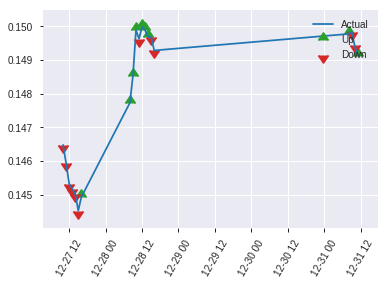


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2058125997755405
RMSE: 0.4536657357301083
LogLoss: 0.6003446419792595
Mean Per-Class Error: 0.28141186299081034
AUC: 0.7364243943191312
pr_auc: 0.6340175649144065
Gini: 0.4728487886382624
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4561704428720636: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      101  32   0.2406   (32.0/133.0)
1      29   61   0.3222   (29.0/90.0)
Total  130  93   0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45617      0.666667  92
max f2                       0.196794     0.785047  174
max f0point5                 0.472579     0.669014  83
max accuracy                 0.472579     0.730942  83
max precision                0.888999     1         0
max recall                   0.0798101    1         222
max specificity              0.888999     1         0
max absolute_mcc             0.472579     0.43571   83
max min_per_class_accuracy   0.443188     0.7       100
max mean_per_class_accuracy  0.45617      0.718588  92

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 41.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.887696           2.47778   2.47778            1                0.888579  1                           0.888579            0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.857032           2.47778   2.47778            1                0.87242   1                           0.882116            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.850733           0         1.76984            0                0.852838  0.714286                    0.873751            0               0.0555556                  -100      76.9841
    4        0.0403587                   0.846405           2.47778   1.92716            1                0.850347  0.777778                    0.86855             0.0222222       0.0777778                  147.778   92.716
    5        0.0538117                   0.833375           2.47778   2.06481            1                0.840505  0.833333                    0.861539            0.0333333       0.111111                   147.778   106.481
    6        0.103139                    0.741935           1.35152   1.72367            0.545455         0.794019  0.695652                    0.829247            0.0666667       0.177778                   35.1515   72.3671
    7        0.152466                    0.66376            1.12626   1.53039            0.454545         0.694737  0.617647                    0.785729            0.0555556       0.233333                   12.6263   53.0392
    8        0.201794                    0.614358           1.35152   1.48667            0.545455         0.636427  0.6                         0.749233            0.0666667       0.3                        35.1515   48.6667
    9        0.300448                    0.515474           2.1399    1.70116            0.863636         0.550592  0.686567                    0.684007            0.211111        0.511111                   113.99    70.1161
    10       0.399103                    0.462494           1.35152   1.61473            0.545455         0.491359  0.651685                    0.636387            0.133333        0.644444                   35.1515   61.4732
    11       0.502242                    0.41586            0.646377  1.41587            0.26087          0.438351  0.571429                    0.595718            0.0666667       0.711111                   -35.3623  41.5873
    12       0.600897                    0.345384           0.788384  1.31285            0.318182         0.378908  0.529851                    0.560123            0.0777778       0.788889                   -21.1616  31.2852
    13       0.699552                    0.263725           0.450505  1.19124            0.181818         0.300797  0.480769                    0.523551            0.0444444       0.833333                   -54.9495  19.1239
    14       0.798206                    0.190159           1.01364   1.16929            0.409091         0.222528  0.47191                     0.486346            0.1             0.933333                   1.36364   16.9288
    15       0.896861                    0.154308           0.337879  1.07783            0.136364         0.176743  0.435                       0.45229             0.0333333       0.966667                   -66.2121  7.78333
    16       1                           0.0798101          0.323188  1                  0.130435         0.128974  0.403587                    0.418943          

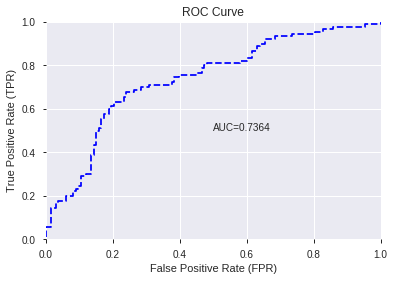

This function is available for GLM models only


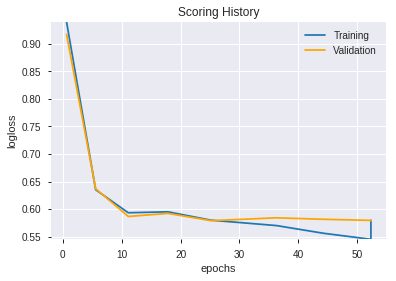

--2019-08-27 19:22:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.97.192
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.97.192|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


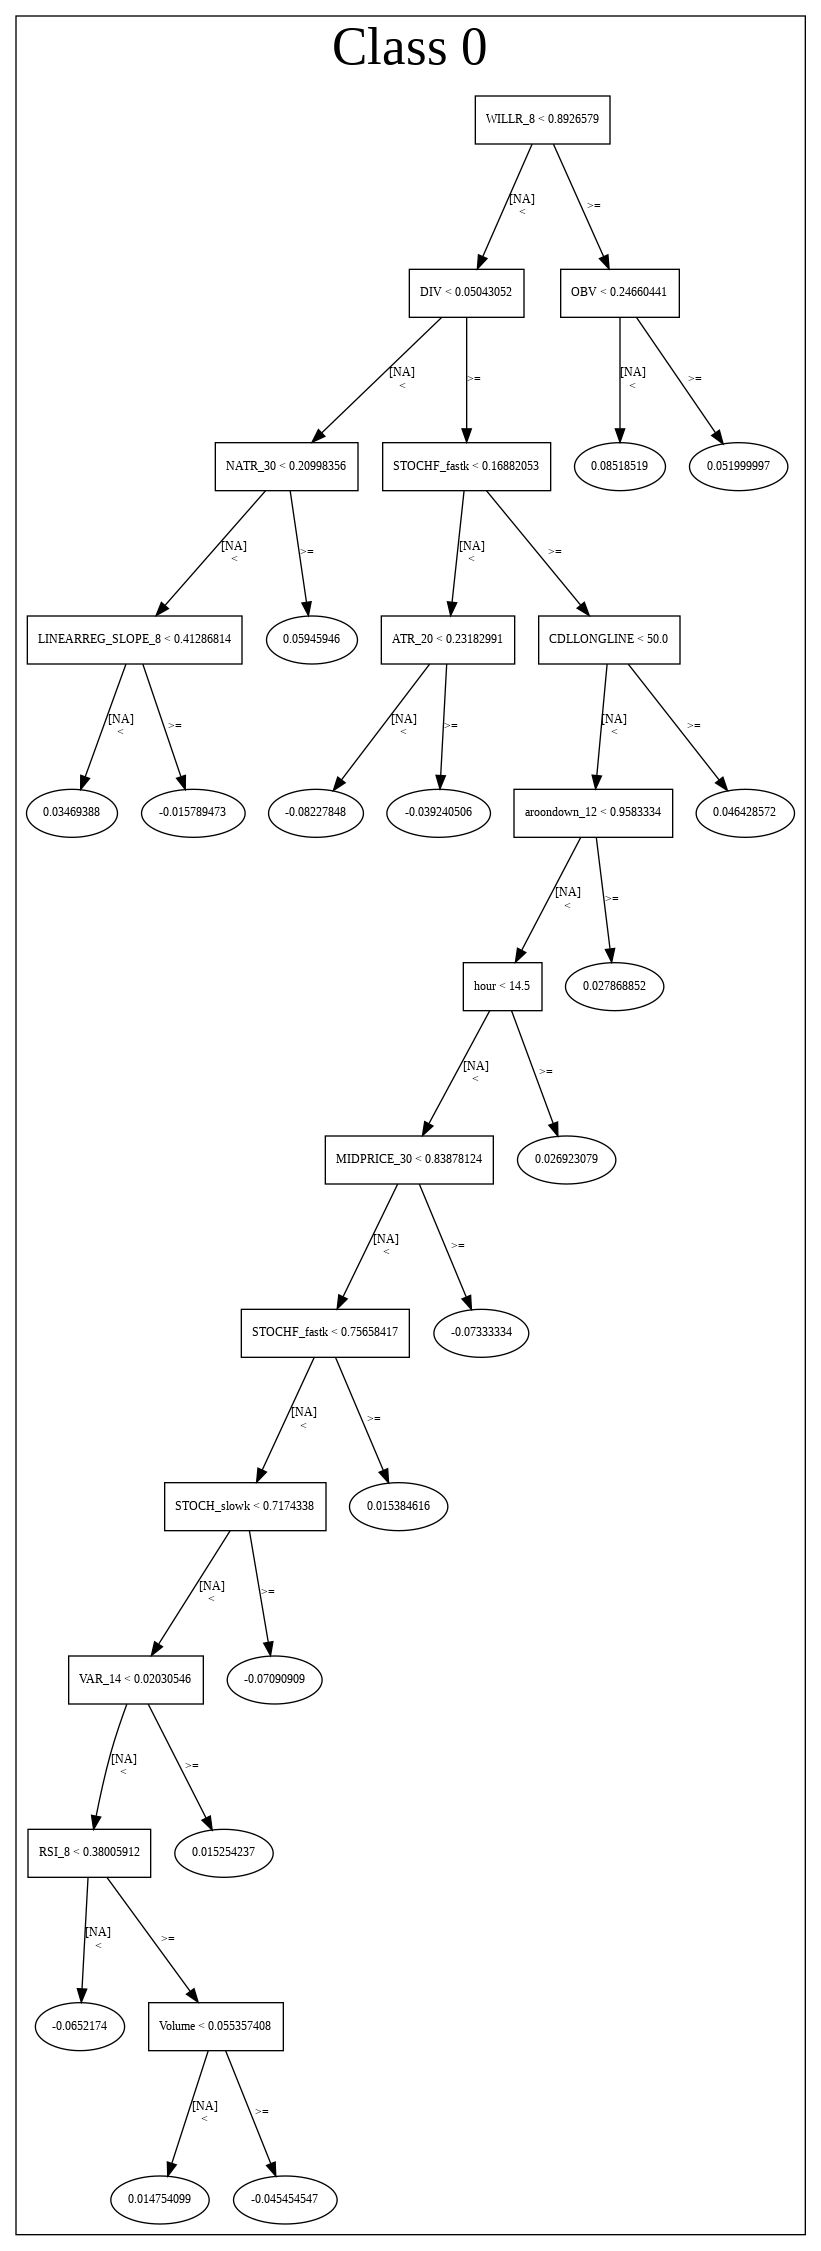

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_191359_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_191359_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['TRANGE',
 'BOP',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLEGGEDDOJI',
 'STOCHF_fastk',
 'VAR_12',
 'DX_8',
 'CDLBELTHOLD',
 'VAR_8',
 'STOCH_slowd',
 'ADXR_8',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'AROONOSC_30',
 'aroonup_14',
 'STOCHRSI_fastd',
 'WILLR_8',
 'MINUS_DI_24',
 'AROONOSC_8',
 'NATR_12',
 'AROONOSC_14',
 'NATR_8',
 'ADX_24',
 'DX_24',
 'MINUS_DI_20',
 'CCI_14',
 'DX_30',
 'aroondown_12',
 'CDLSHORTLINE',
 'ATR_12',
 'MFI_14',
 'ROCP_24',
 'WILLR_12',
 'ATR_24',
 'BBANDS_upperband_20_2_5',
 'ADX_8',
 'ADOSC',
 'NATR_14',
 'MACDFIX_signal_8',
 'aroonup_30',
 'AROONOSC_24',
 'MINUS_DM_30',
 'ATR_14',
 'PLUS_DI_14',
 'CCI_8',
 'BETA_14',
 'STDDEV_8',
 'MEDPRICE',
 'HT_PHASOR_inphase',
 'BBANDS_upperband_20_6_4',
 'MACDFIX_signal_14',
 'MINUS_DM_8',
 'MACDFIX_signal_24',
 'ATR_8',
 'ROCR100_14',
 'BBANDS_lowerband_24_6_4',
 'LINEARREG_ANGLE_14',
 'MFI_20',
 'LINEARREG_ANGLE_12',
 'NATR_30',
 'ROCP_30',
 'PLUS_DI_20',
 'STOCHF_fastd',
 'BBANDS_lowerband_20_3_3',
 

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_192321_model_1  0.751546  0.595151               0.27782  0.446991  0.199801

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.670831           1.000000    0.082149
1                     TRANGE             0.596454           0.889128    0.073041
2                CDLBELTHOLD             0.230457           0.343539    0.028221
3                    WILLR_8             0.229636           0.342316    0.028121
4               STOCHF_fastk             0.221473           0.330147    0.027121
..                       ...                  ...                ...         ...
96                     ADOSC             0.010294           0.015345    0.001261
97                    ATR_24             0.007217           0.010758    0.000884
98                PLUS_DI_20             0.007184           0.010709    0.000880
99   BBANDS_upperband_20_3_5             0.004056           0.006046    0.000497
100                   ATR_12             0.001146           0.001709    0.000140

[101 rows x 4 columns]

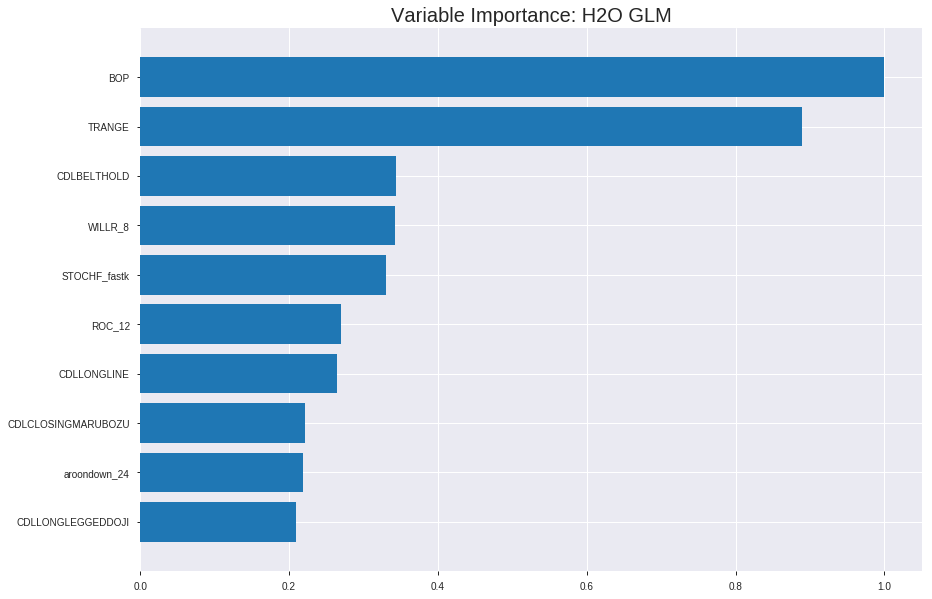

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_192321_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19737835633866416
RMSE: 0.4442728399741134
LogLoss: 0.5798640943527037
Null degrees of freedom: 1558
Residual degrees of freedom: 1457
Null deviance: 2158.5220527111505
Residual deviance: 1808.0162461917303
AIC: 2012.0162461917303
AUC: 0.7663577132833468
pr_auc: 0.7565838029375739
Gini: 0.5327154265666936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3575847545051705: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      380  432   0.532    (432.0/812.0)
1      105  642   0.1406   (105.0/747.0)
Total  485  1074  0.3445   (537.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.357585     0.705107  260
max f2                       0.214979     0.828129  327
max f0point5                 0.542363     0.697807  171
max accuracy                 0.542363     0.706222  171
max precision                0.951233     1         0
max recall                   0.00899282   1         398
max specificity              0.951233     1         0
max absolute_mcc             0.534367     0.410725  175
max min_per_class_accuracy   0.512177     0.699507  187
max mean_per_class_accuracy  0.534367     0.704746  175

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.892204           1.95658   1.95658            0.9375           0.907055  0.9375                      0.907055            0.0200803       0.0200803                  95.6576   95.6576
    2        0.020526                    0.865777           2.08701   2.0218             1                0.877858  0.96875                     0.892457            0.021419        0.0414993                  108.701   102.18
    3        0.0301475                   0.8416             1.94788   1.99821            0.933333         0.852442  0.957447                    0.879686            0.0187416       0.060241                   94.788    99.8206
    4        0.0404105                   0.824676           1.82614   1.95451            0.875            0.83235   0.936508                    0.867664            0.0187416       0.0789826                  82.6138   95.4506
    5        0.0500321                   0.813699           2.08701   1.97999            1                0.818202  0.948718                    0.858152            0.0200803       0.0990629                  108.701   97.9988
    6        0.100064                    0.740855           1.73918   1.85958            0.833333         0.772013  0.891026                    0.815083            0.0870147       0.186078                   73.9179   85.9584
    7        0.150096                    0.707067           1.71242   1.81053            0.820513         0.722496  0.867521                    0.784221            0.085676        0.271754                   71.2422   81.053
    8        0.200128                    0.674337           1.55188   1.74587            0.74359          0.690585  0.836538                    0.760812            0.0776439       0.349398                   55.1883   74.5868
    9        0.300192                    0.618557           1.36459   1.61877            0.653846         0.646192  0.775641                    0.722605            0.136546        0.485944                   36.4587   61.8774
    10       0.400257                    0.566273           1.08364   1.48499            0.519231         0.593645  0.711538                    0.690365            0.108434        0.594378                   8.36423   48.4991
    11       0.500321                    0.505183           1.12378   1.41275            0.538462         0.536556  0.676923                    0.659603            0.11245         0.706827                   12.3777   41.2748
    12       0.599743                    0.419087           0.754018  1.30355            0.36129          0.462172  0.624599                    0.626874            0.0749665       0.781794                   -24.5982  30.3547
    13       0.699808                    0.348783           0.829455  1.23576            0.397436         0.38351   0.592117                    0.592076            0.0829987       0.864793                   -17.0545  23.5758
    14       0.799872                    0.272455           0.668915  1.16485            0.320513         0.313849  0.55814                     0.55727             0.0669344       0.931727                   -33.1085  16.4845
    15       0.899936                    0.168489           0.387971  1.07846            0.185897         0.221477  0.51675                     0.519933            0.038822        0.970549                   -61.2029  7.84645
    16       1                           7.54203e-05        0.294323  1                  0.141026         0.112401  0.479153                    0.479153           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.19471238562928975
RMSE: 0.4412622639987355
LogLoss: 0.5723414269653361
Null degrees of freedom: 445
Residual degrees of freedom: 344
Null deviance: 615.2252417868635
Residual deviance: 510.52855285307976
AIC: 714.5285528530798
AUC: 0.7729674796747967
pr_auc: 0.73481636505047
Gini: 0.5459349593495935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5200273076285589: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      188  58   0.2358   (58.0/246.0)
1      60   140  0.3      (60.0/200.0)
Total  248  198  0.2646   (118.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520027     0.703518  175
max f2                       0.2129       0.820513  328
max f0point5                 0.520027     0.705645  175
max accuracy                 0.520027     0.735426  175
max precision                0.908979     1         0
max recall                   0.0469665    1         395
max specificity              0.908979     1         0
max absolute_mcc             0.520027     0.464681  175
max min_per_class_accuracy   0.507389     0.71      184
max mean_per_class_accuracy  0.520027     0.732114  175

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 46.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.858814           2.23      2.23               1                0.886099  1                           0.886099            0.025           0.025                      123       123
    2        0.0201794                   0.85159            2.23      2.23               1                0.856623  1                           0.872999            0.02            0.045                      123       123
    3        0.0313901                   0.842167           2.23      2.23               1                0.848249  1                           0.864159            0.025           0.07                       123       123
    4        0.0403587                   0.82663            2.23      2.23               1                0.833569  1                           0.857361            0.02            0.09                       123       123
    5        0.0515695                   0.811678           1.338     2.03609            0.6              0.818284  0.913043                    0.848866            0.015           0.105                      33.8      103.609
    6        0.100897                    0.739111           1.82455   1.93267            0.818182         0.773709  0.866667                    0.812123            0.09            0.195                      82.4545   93.2667
    7        0.150224                    0.69748            1.41909   1.76403            0.636364         0.716164  0.791045                    0.780614            0.07            0.265                      41.9091   76.403
    8        0.201794                    0.658571           1.64826   1.73444            0.73913          0.676636  0.777778                    0.754042            0.085           0.35                       64.8261   73.4444
    9        0.300448                    0.603428           1.52045   1.66418            0.681818         0.626226  0.746269                    0.712072            0.15            0.5                        52.0455   66.4179
    10       0.401345                    0.543603           1.28844   1.56972            0.577778         0.572126  0.703911                    0.67689             0.13            0.63                       28.8444   56.9721
    11       0.5                         0.490339           1.115     1.48               0.5              0.517086  0.663677                    0.645359            0.11            0.74                       11.5      48
    12       0.600897                    0.440459           0.545111  1.32302            0.244444         0.462937  0.593284                    0.614729            0.055           0.795                      -45.4889  32.3022
    13       0.699552                    0.363174           0.861591  1.25795            0.386364         0.400636  0.564103                    0.584536            0.085           0.88                       -13.8409  25.7949
    14       0.800448                    0.243473           0.594667  1.17434            0.266667         0.305012  0.526611                    0.549302            0.06            0.94                       -40.5333  17.4342
    15       0.899103                    0.158586           0.405455  1.08998            0.181818         0.195358  0.488778                    0.510465            0.04            0.98                       -59.4545  8.99751
    16       1                           0.000323254        0.198222  1                  0.0888889        0.107288  0.44843                     0.469786            0.02            1  


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-08-27 19:23:21  0.000 sec   2            .18E2     101           1.3680114314761542  1.3664122115701716
     2019-08-27 19:23:21  0.019 sec   4            .13E2     102           1.3633608525947074  1.362201894108145
     2019-08-27 19:23:21  0.037 sec   6            .93E1     102           1.3576655541835434  1.356803556638373
     2019-08-27 19:23:21  0.061 sec   8            .68E1     102           1.3508011665985515  1.3499360770440005
     2019-08-27 19:23:21  0.083 sec   10           .49E1     102           1.3426254588071926  1.3413890025302175
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-08-27 19:23:22  0.555 sec   52           .63E-2    102           1.157693920827272   1.1447475846368593
     2019-08-27 19:23:22  0.587 sec   54           .46E-2    102           1.1559298703970413  1.1453555643389708
     2019-08-27 19:23:22  0.616 sec   56           .33E-2    102           1.1542282463445444  1.146105527894336
     2019-08-27 19:23:22  0.647 sec   58           .24E-2    102           1.1526597208256815  1.1470179908690257
     2019-08-27 19:23:22  0.678 sec   60           .18E-2    102           1.1511517766621873  1.1481373224184275


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.726457399103139)

('F1', 0.6737967914438502)

('auc', 0.7515455304928989)

('logloss', 0.5951505940656172)

('mean_per_class_error', 0.2778195488721804)

('rmse', 0.4469911504333763)

('mse', 0.1998010885657532)

glm prediction progress: |████████████████████████████████████████████████| 100%


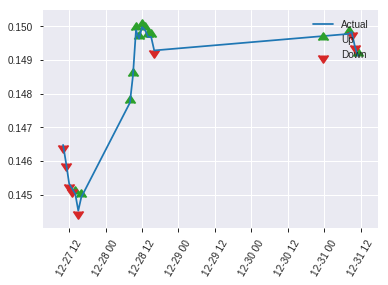


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.1998010885657532
RMSE: 0.4469911504333763
LogLoss: 0.5951505940656172
Null degrees of freedom: 222
Residual degrees of freedom: 121
Null deviance: 305.94391779285456
Residual deviance: 265.43716495326527
AIC: 469.43716495326527
AUC: 0.7515455304928989
pr_auc: 0.6413247867627603
Gini: 0.5030910609857977
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5205592348702041: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      99   34   0.2556   (34.0/133.0)
1      27   63   0.3      (27.0/90.0)
Total  126  97   0.2735   (61.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.520559     0.673797  96
max f2                       0.17582      0.784672  187
max f0point5                 0.54825      0.661435  88
max accuracy                 0.54825      0.726457  88
max precision                0.879435     1         0
max recall                   0.00778718   1         221
max specificity              0.879435     1         0
max absolute_mcc             0.520559     0.439756  96
max min_per_class_accuracy   0.520559     0.7       96
max mean_per_class_accuracy  0.520559     0.72218   96

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 45.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.873011           1.65185   1.65185            0.666667         0.875632   0.666667                    0.875632            0.0222222       0.0222222                  65.1852   65.1852
    2        0.0224215                   0.854489           2.47778   1.98222            1                0.863524   0.8                         0.870789            0.0222222       0.0444444                  147.778   98.2222
    3        0.0313901                   0.835783           2.47778   2.12381            1                0.847668   0.857143                    0.864183            0.0222222       0.0666667                  147.778   112.381
    4        0.0403587                   0.818967           2.47778   2.20247            1                0.83228    0.888889                    0.857093            0.0222222       0.0888889                  147.778   120.247
    5        0.0538117                   0.804136           0.825926  1.85833            0.333333         0.810983   0.75                        0.845566            0.0111111       0.1                        -17.4074  85.8333
    6        0.103139                    0.715433           1.57677   1.72367            0.636364         0.746296   0.695652                    0.798089            0.0777778       0.177778                   57.6768   72.3671
    7        0.152466                    0.688499           1.80202   1.74902            0.727273         0.697089   0.705882                    0.765413            0.0888889       0.266667                   80.202    74.902
    8        0.201794                    0.654284           1.57677   1.70691            0.636364         0.672556   0.688889                    0.742714            0.0777778       0.344444                   57.6768   70.6914
    9        0.300448                    0.60697            1.57677   1.66418            0.636364         0.630645   0.671642                    0.705915            0.155556        0.5                        57.6768   66.4179
    10       0.399103                    0.547426           1.57677   1.64257            0.636364         0.580341   0.662921                    0.674874            0.155556        0.655556                   57.6768   64.2572
    11       0.502242                    0.451637           0.861836  1.48224            0.347826         0.498247   0.598214                    0.638603            0.0888889       0.744444                   -13.8164  48.2242
    12       0.600897                    0.382387           0.675758  1.34983            0.272727         0.416718   0.544776                    0.602174            0.0666667       0.811111                   -32.4242  34.9834
    13       0.699552                    0.326414           0.563131  1.23889            0.227273         0.356119   0.5                         0.567474            0.0555556       0.866667                   -43.6869  23.8889
    14       0.798206                    0.213105           0.675758  1.16929            0.272727         0.274691   0.47191                     0.531287            0.0666667       0.933333                   -32.4242  16.9288
    15       0.896861                    0.134986           0.225253  1.06544            0.0909091        0.174877   0.43                        0.492082            0.0222222       0.955556                   -77.4747  6.54444
    16       1                           0.00647394         0.430918  1                  0.173913         0.0859931  0.403587                    

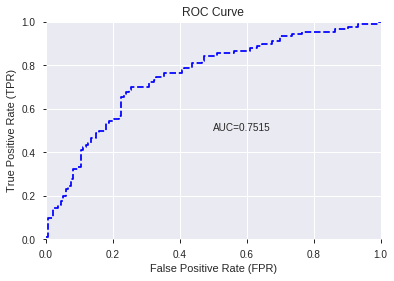

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


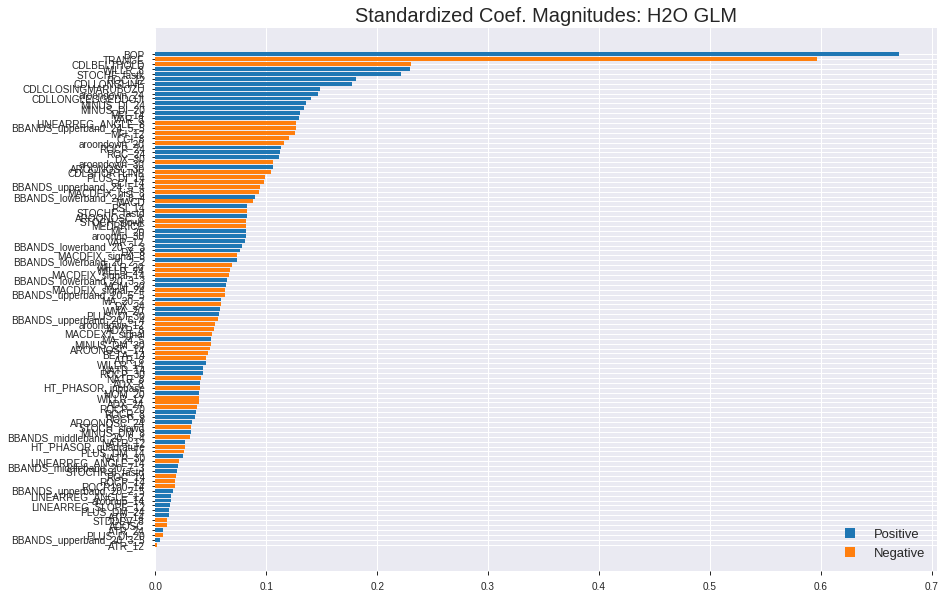

'log_likelihood'
--2019-08-27 19:23:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


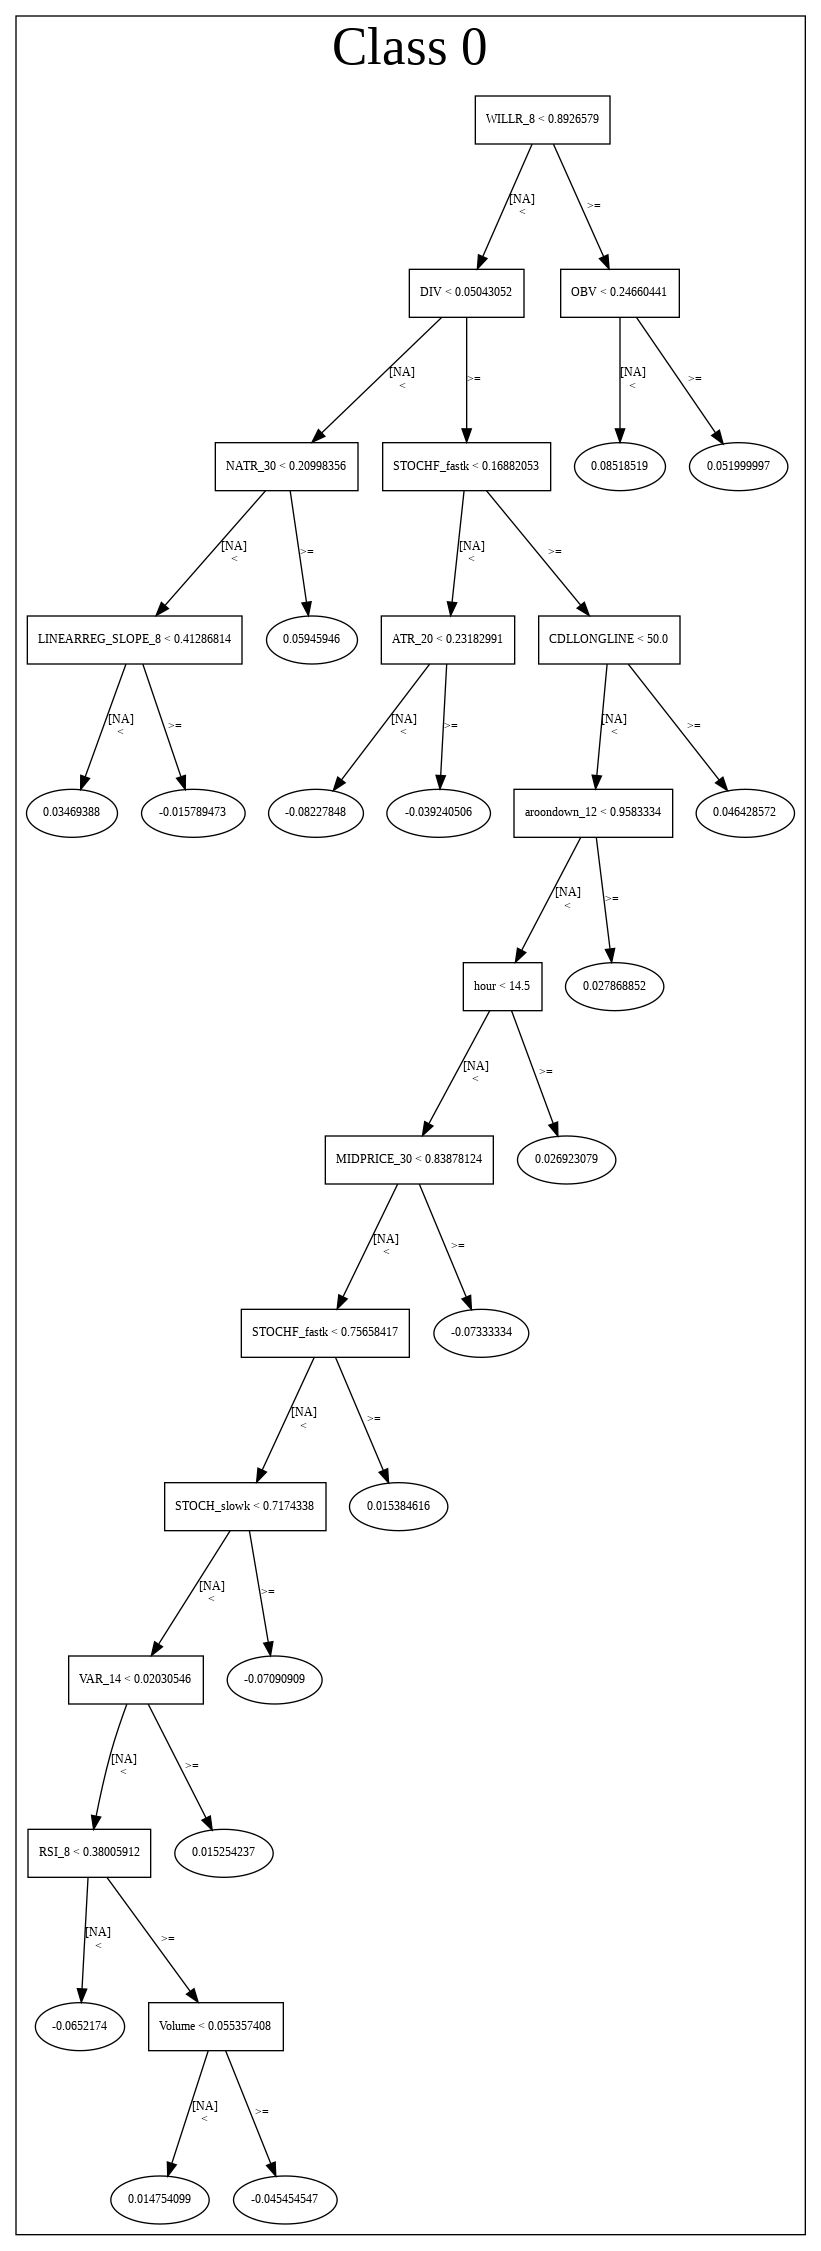

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_192321_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_192321_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLBELTHOLD',
 'WILLR_8',
 'STOCHF_fastk',
 'ROC_12',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'aroondown_24',
 'CDLLONGLEGGEDDOJI',
 'MINUS_DI_24',
 'MINUS_DI_20',
 'MFI_14',
 'VAR_8',
 'LINEARREG_ANGLE_8',
 'BBANDS_upperband_24_5_5',
 'MFI_12',
 'CCI_8',
 'aroondown_20',
 'ROCP_24',
 'ROC_24',
 'DX_30',
 'aroondown_30',
 'AROONOSC_30',
 'CDLSHORTLINE',
 'PLUS_DI_14',
 'CCI_14',
 'BBANDS_upperband_24_5_4',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_24_6_4',
 'MACD',
 'RSI_14',
 'STOCHF_fastd',
 'AROONOSC_8',
 'STOCH_slowk',
 'MEDPRICE',
 'MFI_20',
 'aroonup_30',
 'VAR_12',
 'BBANDS_lowerband_20_2_3',
 'DX_8',
 'MACDFIX_signal_8',
 'BBANDS_lowerband_20_2_2',
 'WILLR_20',
 'WILLR_24',
 'MACDFIX_signal_14',
 'BBANDS_lowerband_20_3_3',
 'MOM_30',
 'MACDFIX_signal_24',
 'BBANDS_upperband_20_6_5',
 'MA_20_2',
 'DX_24',
 'WMA_20',
 'PLUS_DI_30',
 'BBANDS_upperband_20_6_4',
 'aroondown_12',
 'ADXR_8',
 'MACDEXT_signal',
 'MA_24_5',
 'MINUS_DM_30',
 'AROONOSC_14',
 'BETA_14',
 '

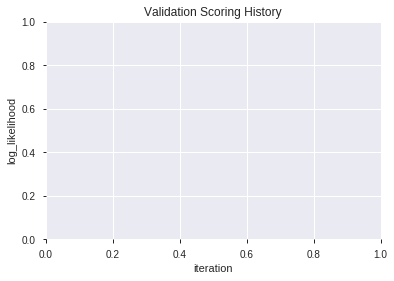

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_192429_model_7  0.785046  0.549420              0.296157  0.430804  0.185592
1               XGBoost_3_AutoML_20190827_192429  0.775104  0.556584              0.312657  0.434911  0.189147
2               XGBoost_2_AutoML_20190827_192429  0.764745  0.571173              0.276525  0.440618  0.194144
3  XGBoost_grid_1_AutoML_20190827_192429_model_2  0.764745  0.568467              0.306600  0.439852  0.193470
4               XGBoost_1_AutoML_20190827_192429  0.764160  0.565788              0.307268  0.439185  0.192884
5  XGBoost_grid_1_AutoML_20190827_192429_model_6  0.763576  0.565315              0.287469  0.438865  0.192603
6  XGBoost_grid_1_AutoML_20190827_192429_model_3  0.758312  0.572248              0.287302  0.441440  0.194870
7  XGBoost_grid_1_AutoML_20190827_192429_model_5  0.749958  0.584798              0.302339  0.445983  0.198901
8  XGBoost_grid_1_AutoML_20190827_192429_model_4  0.749624  0.581533              0.295656  0.445134  0.198145
9  XGBoost_grid_1_AutoML_20190827_192429_model_1  0.748622  0.580155              0.315121  0.445261  0.198257

variable  relative_importance  scaled_importance  percentage
0                         BOP          1119.872070           1.000000    0.109778
1                      TRANGE           800.536011           0.714846    0.078474
2                STOCHF_fastk           521.953186           0.466083    0.051166
3                     WILLR_8           263.063354           0.234905    0.025787
4                      VAR_12           223.968369           0.199995    0.021955
..                        ...                  ...                ...         ...
96         LINEARREG_SLOPE_12            17.738243           0.015840    0.001739
97   BBANDS_middleband_20_6_4            14.105801           0.012596    0.001383
98                AROONOSC_24            13.728722           0.012259    0.001346
99                    MA_20_2            12.149295           0.010849    0.001191
100                   ROCP_14             5.681541           0.005073    0.000557

[101 rows x 4 columns]

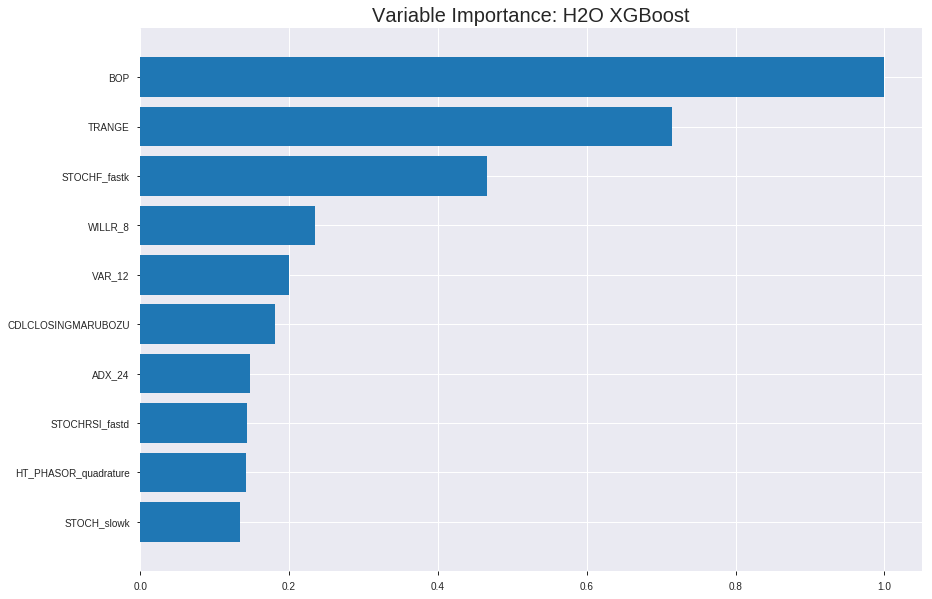

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_192429_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1012484924116385
RMSE: 0.3181956825785644
LogLoss: 0.35947587946841586
Mean Per-Class Error: 0.07994457303763491
AUC: 0.9753925389571423
pr_auc: 0.9725894910550998
Gini: 0.9507850779142846
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49809305866559345: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      755  57   0.0702   (57.0/812.0)
1      67   680  0.0897   (67.0/747.0)
Total  822  737  0.0795   (124.0/1559.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498093     0.916442  197
max f2                       0.372959     0.940138  246
max f0point5                 0.564154     0.929883  169
max accuracy                 0.50385      0.920462  194
max precision                0.951478     1         0
max recall                   0.233041     1         313
max specificity              0.951478     1         0
max absolute_mcc             0.50385      0.840754  194
max min_per_class_accuracy   0.488081     0.914324  201
max mean_per_class_accuracy  0.498093     0.920055  197

Gains/Lift Table: Avg response rate: 47.92 %, avg score: 47.91 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010263                    0.920155           2.08701    2.08701            1                0.931681  1                           0.931681            0.021419        0.021419                   108.701   108.701
    2        0.020526                    0.903494           2.08701    2.08701            1                0.912111  1                           0.921896            0.021419        0.042838                   108.701   108.701
    3        0.0301475                   0.887118           2.08701    2.08701            1                0.894466  1                           0.913142            0.0200803       0.0629183                  108.701   108.701
    4        0.0404105                   0.878597           2.08701    2.08701            1                0.881513  1                           0.905109            0.021419        0.0843373                  108.701   108.701
    5        0.0500321                   0.871573           2.08701    2.08701            1                0.875423  1                           0.8994              0.0200803       0.104418                   108.701   108.701
    6        0.100064                    0.830078           2.08701    2.08701            1                0.849421  1                           0.874411            0.104418        0.208835                   108.701   108.701
    7        0.150096                    0.787402           2.08701    2.08701            1                0.807082  1                           0.851968            0.104418        0.313253                   108.701   108.701
    8        0.200128                    0.74909            2.08701    2.08701            1                0.77072   1                           0.831656            0.104418        0.417671                   108.701   108.701
    9        0.300192                    0.669601           2.00674    2.06026            0.961538         0.710676  0.987179                    0.791329            0.200803        0.618474                   100.674   106.026
    10       0.400257                    0.578548           1.87296    2.01343            0.897436         0.628717  0.964744                    0.750676            0.187416        0.80589                    87.2962   101.343
    11       0.500321                    0.466206           1.27094    1.86493            0.608974         0.521964  0.89359                     0.704934            0.127175        0.933066                   27.0938   86.4935
    12       0.599743                    0.361896           0.511655   1.64059            0.245161         0.407828  0.786096                    0.655681            0.0508701       0.983936                   -48.8345  64.0594
    13       0.699808                    0.27614            0.133783   1.42514            0.0641026        0.317715  0.68286                     0.607356            0.0133869       0.997323                   -86.6217  42.5138
    14       0.799872                    0.21258            0.0267566  1.2502             0.0128205        0.244354  0.599038                    0.561944            0.00267738      1                          -97.3243  25.02
    15       0.899936                    0.150916           0          1.11119            0                0.184156  0.532431                    0.519938            0               1                          -100      11.119
    16       1                           0.0436044          0          1                  0                0.111448  0.479153                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19585929201401928
RMSE: 0.4425599304207502
LogLoss: 0.5752950919248758
Mean Per-Class Error: 0.28963414634146334
AUC: 0.7660467479674796
pr_auc: 0.6993957707969103
Gini: 0.5320934959349592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32149311900138855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      118  128  0.5203   (128.0/246.0)
1      21   179  0.105    (21.0/200.0)
Total  139  307  0.3341   (149.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.321493     0.706114  275
max f2                       0.193959     0.824129  336
max f0point5                 0.513867     0.673868  177
max accuracy                 0.513867     0.706278  177
max precision                0.910938     1         0
max recall                   0.0739572    1         398
max specificity              0.910938     1         0
max absolute_mcc             0.452078     0.418757  210
max min_per_class_accuracy   0.475971     0.703252  195
max mean_per_class_accuracy  0.452078     0.710366  210

Gains/Lift Table: Avg response rate: 44.84 %, avg score: 46.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.888155           2.23      2.23               1                0.898116  1                           0.898116            0.025           0.025                      123       123
    2        0.0201794                   0.86704            1.115     1.73444            0.5              0.879835  0.777778                    0.889991            0.01            0.035                      11.5      73.4444
    3        0.0313901                   0.856409           1.784     1.75214            0.8              0.861235  0.785714                    0.879721            0.02            0.055                      78.4      75.2143
    4        0.0403587                   0.838741           2.23      1.85833            1                0.848337  0.833333                    0.872747            0.02            0.075                      123       85.8333
    5        0.0515695                   0.823924           1.338     1.74522            0.6              0.829864  0.782609                    0.863424            0.015           0.09                       33.8      74.5217
    6        0.100897                    0.776413           1.72318   1.73444            0.772727         0.799233  0.777778                    0.832042            0.085           0.175                      72.3182   73.4444
    7        0.150224                    0.729767           1.82455   1.76403            0.818182         0.755179  0.791045                    0.806803            0.09            0.265                      82.4545   76.403
    8        0.201794                    0.69123            1.74522   1.75922            0.782609         0.710612  0.788889                    0.782221            0.09            0.355                      74.5217   75.9222
    9        0.300448                    0.610014           1.31773   1.61425            0.590909         0.652435  0.723881                    0.739605            0.13            0.485                      31.7727   61.4254
    10       0.401345                    0.54173            1.18933   1.50743            0.533333         0.576717  0.675978                    0.698656            0.12            0.605                      18.9333   50.743
    11       0.5                         0.461335           1.26705   1.46               0.568182         0.497339  0.654709                    0.658934            0.125           0.73                       26.7045   46
    12       0.600897                    0.3978             0.693778  1.33134            0.311111         0.430004  0.597015                    0.620494            0.07            0.8                        -30.6222  33.1343
    13       0.699552                    0.316004           1.01364   1.28654            0.454545         0.359561  0.576923                    0.583696            0.1             0.9                        1.36364   28.6538
    14       0.800448                    0.233061           0.495556  1.18683            0.222222         0.273824  0.532213                    0.544636            0.05            0.95                       -50.4444  18.6835
    15       0.899103                    0.163462           0.304091  1.08998            0.136364         0.192354  0.488778                    0.505982            0.03            0.98                       -69.5909  8.99751
    16       1                           0.0666948          0.198222  1                  0.0888889        0.130994  0.44843                     0.468147            0.02    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 19:24:47  11.387 sec  0                  0.5              0.693147            0.5             0                  1                0.520847                         0.5                0.693147              0.5               0                    1                  0.55157
    2019-08-27 19:24:47  11.586 sec  5                  0.469364         0.633365            0.863521        0.843761           2.08701          0.213598                         0.479143           0.652089              0.772033          0.709782             2.23               0.266816
    2019-08-27 19:24:47  11.679 sec  10                 0.444658         0.586615            0.891129        0.87759            2.08701          0.192431                         0.466814           0.628                 0.771413          0.705591             1.784              0.29148
    2019-08-27 19:24:47  11.772 sec  15                 0.425769         0.551295            0.90728         0.895017           2.08701          0.180244                         0.457684           0.609837              0.777154          0.720243             2.23               0.311659
    2019-08-27 19:24:47  11.870 sec  20                 0.410058         0.521796            0.915305        0.905618           2.08701          0.164208                         0.450906           0.595919              0.776047          0.72826              2.23               0.327354
    2019-08-27 19:24:47  11.967 sec  25                 0.395152         0.494091            0.92684         0.917131           2.08701          0.149455                         0.44435            0.582586              0.785376          0.738387             2.23               0.300448
    2019-08-27 19:24:48  12.065 sec  30                 0.382525         0.470967            0.936424        0.92709            2.08701          0.140475                         0.441597           0.576253              0.784858          0.732082             2.23               0.302691
    2019-08-27 19:24:48  12.171 sec  35                 0.370896         0.449961            0.94474         0.936632           2.08701          0.128287                         0.440693           0.574039              0.780854          0.72716              2.23               0.313901
    2019-08-27 19:24:48  12.268 sec  40                 0.360708         0.431696            0.95144         0.944309           2.08701          0.119307                         0.440676           0.57303               0.776006          0.718943             2.23               0.304933
    2019-08-27 19:24:48  12.360 sec  45                 0.351108         0.414724            0.956775        0.950797           2.08701          0.112893                         0.439445           0.570202              0.776474          0.721035             2.23               0.307175
    2019-08-27 19:24:48  12.670 sec  50                 0.341621         0.39826             0.961806        0.957321           2.08701          0.10263                          0.439559           0.569433              0.774238          0.720408             2.23               0.309417
    2019-08-27 19:24:48  12.767 sec  55                 0.333162         0.384111            0.967311        0.963903           2.08701          0.0949326                        0.440425           0.570903              0.771575          0.7

Variable Importances: 


variable                  relative_importance    scaled_importance     percentage
------------------------  ---------------------  --------------------  ---------------------
BOP                       1119.8720703125        1.0                   0.10977793243304783
TRANGE                    800.5360107421875      0.7148459471078675    0.07847431008164557
STOCHF_fastk              521.9531860351562      0.4660828677417639    0.05116561356315653
WILLR_8                   263.0633544921875      0.23490482660111323   0.025787366182813826
VAR_12                    223.96836853027344     0.19999460158674653   0.021954993859964182
---                       ---                    ---                   ---
LINEARREG_SLOPE_12        17.738243103027344     0.015839526293460904  0.0017388304472150359
BBANDS_middleband_20_6_4  14.10580062866211      0.012595903588099925  0.0013827522530276183
AROONOSC_24               13.728721618652344     0.012259187439884404  0.0013457882504596987
MA_20_2                   12.14929485321045      0.010848823874873665  0.0011909614543139174
ROCP_14                   5.681541442871094      0.005073384356559282  0.0005569456451012467


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7354260089686099)

('F1', 0.6837606837606838)

('auc', 0.785045948203843)

('logloss', 0.5494196377970582)

('mean_per_class_error', 0.2756892230576442)

('rmse', 0.4308043753136916)

('mse', 0.18559240978942004)

xgboost prediction progress: |████████████████████████████████████████████| 100%


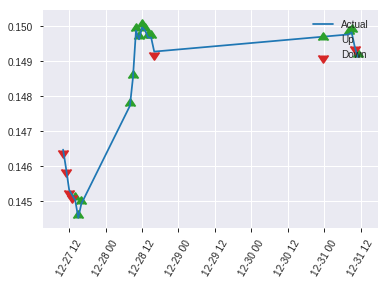


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.18559240978942004
RMSE: 0.4308043753136916
LogLoss: 0.5494196377970582
Mean Per-Class Error: 0.2756892230576442
AUC: 0.785045948203843
pr_auc: 0.7004819494050651
Gini: 0.570091896407686
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30151262879371643: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      69   64   0.4812   (64.0/133.0)
1      10   80   0.1111   (10.0/90.0)
Total  79   144  0.3318   (74.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.301513     0.683761  143
max f2                       0.263078     0.807393  153
max f0point5                 0.58788      0.675676  69
max accuracy                 0.482079     0.735426  88
max precision                0.87873      1         0
max recall                   0.151088     1         206
max specificity              0.87873      1         0
max absolute_mcc             0.482079     0.449448  88
max min_per_class_accuracy   0.4507       0.7       97
max mean_per_class_accuracy  0.482079     0.724311  88

Gains/Lift Table: Avg response rate: 40.36 %, avg score: 43.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.845798           2.47778   2.47778            1                0.8653    1                           0.8653              0.0333333       0.0333333                  147.778   147.778
    2        0.0224215                   0.833609           2.47778   2.47778            1                0.84238   1                           0.856132            0.0222222       0.0555556                  147.778   147.778
    3        0.0313901                   0.815094           2.47778   2.47778            1                0.823155  1                           0.84671             0.0222222       0.0777778                  147.778   147.778
    4        0.0403587                   0.796894           1.23889   2.20247            0.5              0.805676  0.888889                    0.837591            0.0111111       0.0888889                  23.8889   120.247
    5        0.0538117                   0.777545           1.65185   2.06481            0.666667         0.789438  0.833333                    0.825553            0.0222222       0.111111                   65.1852   106.481
    6        0.103139                    0.738535           1.80202   1.93913            0.727273         0.758347  0.782609                    0.793411            0.0888889       0.2                        80.202    93.913
    7        0.152466                    0.704113           2.02727   1.96765            0.818182         0.721787  0.794118                    0.770238            0.1             0.3                        102.727   96.7647
    8        0.201794                    0.677907           1.80202   1.92716            0.727273         0.693678  0.777778                    0.751523            0.0888889       0.388889                   80.202    92.716
    9        0.300448                    0.598011           1.35152   1.73814            0.545455         0.640125  0.701493                    0.714945            0.133333        0.522222                   35.1515   73.8143
    10       0.399103                    0.479811           1.46414   1.67041            0.590909         0.548671  0.674157                    0.673843            0.144444        0.666667                   46.4141   67.0412
    11       0.502242                    0.420476           0.538647  1.438              0.217391         0.449158  0.580357                    0.627703            0.0555556       0.722222                   -46.1353  43.7996
    12       0.600897                    0.32768            1.01364   1.36833            0.409091         0.380022  0.552239                    0.587039            0.1             0.822222                   1.36364   36.8325
    13       0.699552                    0.253801           1.01364   1.3183             0.409091         0.291485  0.532051                    0.545358            0.1             0.922222                   1.36364   31.8305
    14       0.798206                    0.215369           0.337879  1.19713            0.136364         0.235261  0.483146                    0.507031            0.0333333       0.955556                   -66.2121  19.7129
    15       0.896861                    0.161887           0.337879  1.10261            0.136364         0.192176  0.445                       0.472397            0.0333333       0.988889                   -66.2121  10.2611
    16       1                           0.0674904          0.107729  1                  0.0434783        0.121963  0.403587                    0.436254           

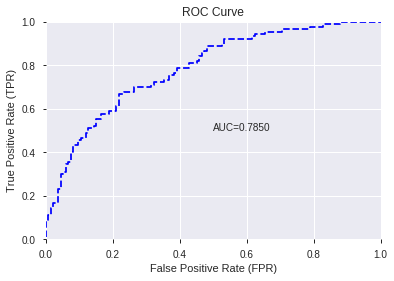

This function is available for GLM models only


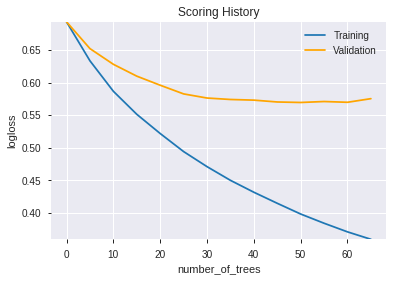

--2019-08-27 19:24:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

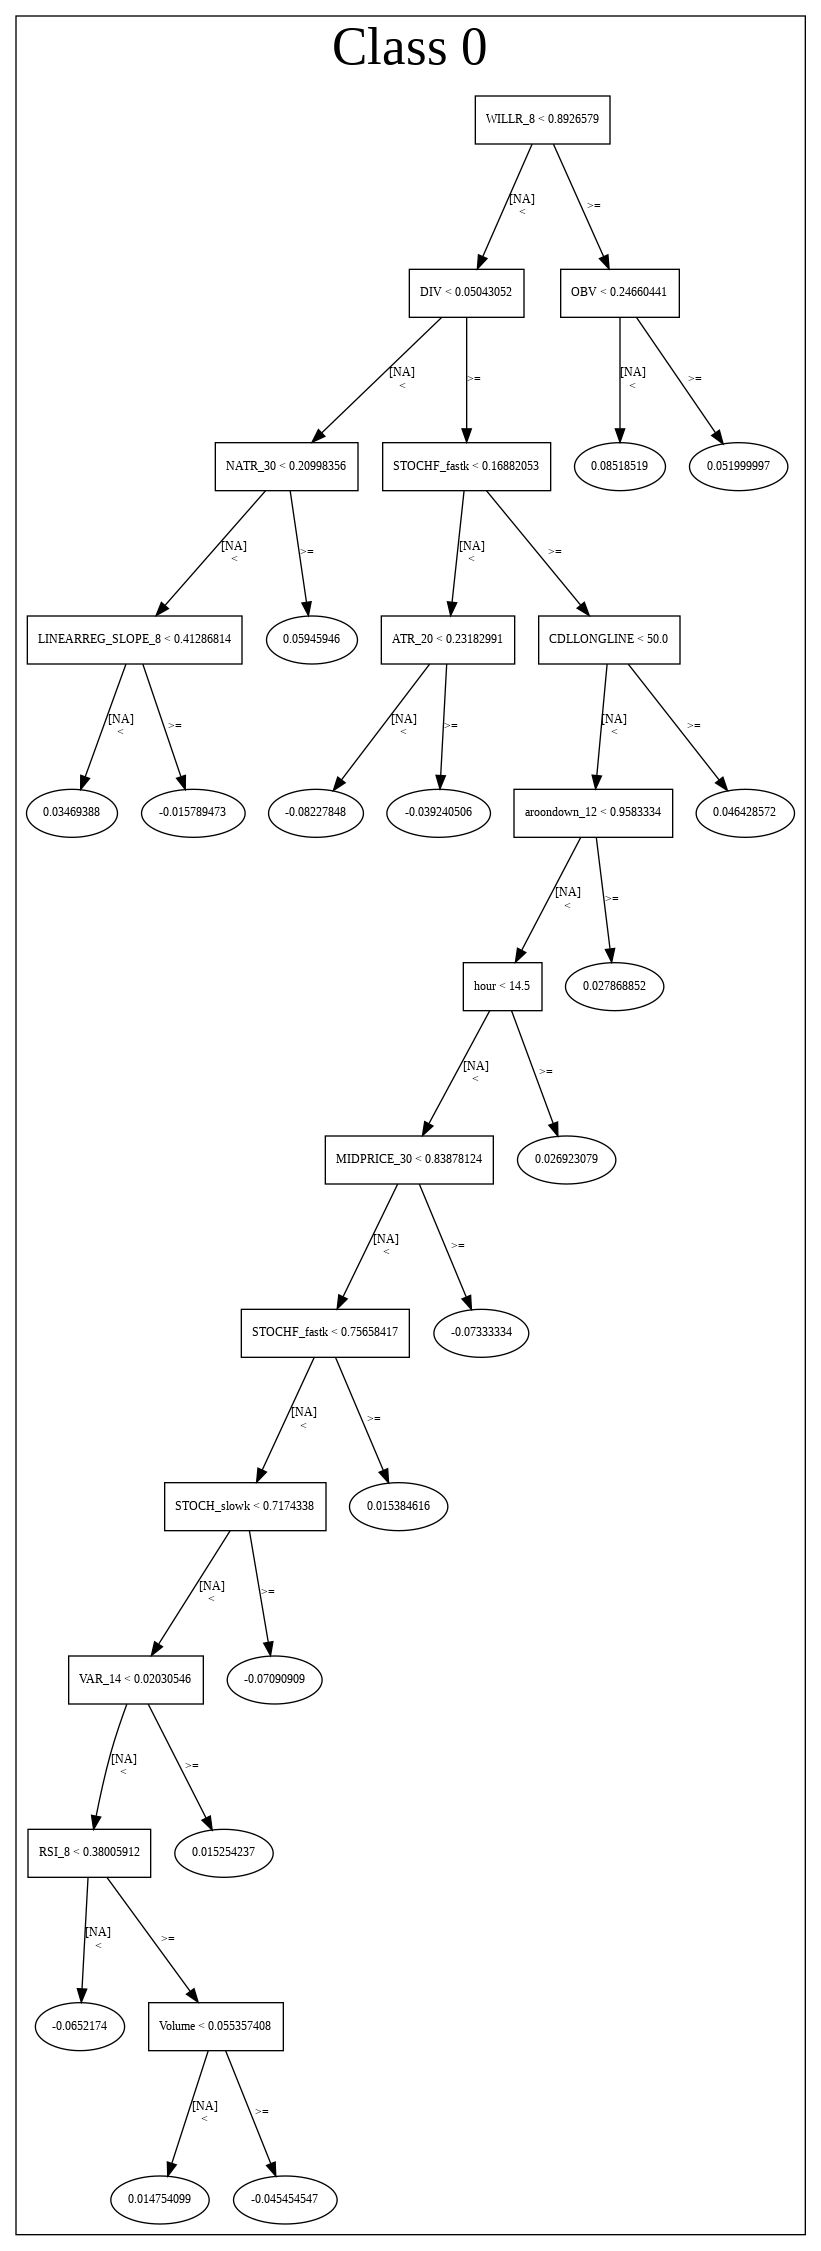

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_192429_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_192429_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_af9a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'WILLR_8',
 'VAR_12',
 'CDLCLOSINGMARUBOZU',
 'ADX_24',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'WILLR_14',
 'CCI_8',
 'ROCP_8',
 'MFI_14',
 'DX_24',
 'MINUS_DM_30',
 'MINUS_DM_8',
 'STOCH_slowd',
 'DX_8',
 'ROCP_30',
 'WILLR_12',
 'PLUS_DM_14',
 'aroonup_14',
 'CDLLONGLINE',
 'ADXR_8',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'ATR_12',
 'MFI_20',
 'ATR_24',
 'MACDEXT_signal',
 'PLUS_DI_30',
 'PLUS_DI_14',
 'DX_30',
 'CCI_14',
 'ATR_8',
 'NATR_30',
 'AROONOSC_30',
 'PLUS_DM_24',
 'NATR_8',
 'ROC_12',
 'ADX_8',
 'AROONOSC_14',
 'BBANDS_upperband_24_5_5',
 'STDDEV_8',
 'ATR_14',
 'ADOSC',
 'ROC_24',
 'MINUS_DI_24',
 'WILLR_20',
 'NATR_14',
 'ROC_14',
 'aroondown_30',
 'WILLR_24',
 'LINEARREG_ANGLE_8',
 'ROCR_8',
 'BBANDS_lowerband_20_2_3',
 'MFI_12',
 'aroondown_12',
 'BETA_14',
 'AROONOSC_8',
 'LINEARREG_ANGLE_12',
 'BBANDS_upperband_20_6_5',
 'ROCP_20',
 'LINEARREG_ANGLE_14',
 'CDLLONGLEGGEDDOJI',
 'MA_24_5',
 'MEDPRICE',
 'BBANDS_

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.731
GLM             0.726
XGBoost         0.735
dtype: float64

DeepLearning    GLM  XGBoost
All          0.722  0.713    0.709
DLF          0.717  0.717    0.731
Fwe          0.700  0.709    0.726
RFE          0.731  0.726    0.735
XGBF         0.717  0.717    0.731





F1


DeepLearning    0.667
GLM             0.674
XGBoost         0.699
dtype: float64

DeepLearning    GLM  XGBoost
All          0.642  0.656    0.699
DLF          0.627  0.654    0.670
Fwe          0.657  0.641    0.675
RFE          0.667  0.674    0.684
XGBF         0.647  0.654    0.670





auc


DeepLearning    0.743
GLM             0.752
XGBoost         0.785
dtype: float64

DeepLearning    GLM  XGBoost
All          0.738  0.742    0.765
DLF          0.735  0.739    0.753
Fwe          0.743  0.727    0.764
RFE          0.736  0.752    0.785
XGBF         0.740  0.739    0.753





logloss


DeepLearning    0.690
GLM             0.611
XGBoost         0.579
dtype: float64

DeepLearning    GLM  XGBoost
All          0.690  0.602    0.570
DLF          0.631  0.600    0.579
Fwe          0.593  0.611    0.564
RFE          0.600  0.595    0.549
XGBF         0.602  0.600    0.579





mean_per_class_error


DeepLearning    0.320
GLM             0.310
XGBoost         0.305
dtype: float64

DeepLearning    GLM  XGBoost
All          0.305  0.293    0.277
DLF          0.305  0.310    0.305
Fwe          0.317  0.304    0.294
RFE          0.281  0.278    0.276
XGBF         0.320  0.310    0.305





rmse


DeepLearning    0.459
GLM             0.454
XGBoost         0.446
dtype: float64

DeepLearning    GLM  XGBoost
All          0.459  0.453    0.441
DLF          0.459  0.451    0.446
Fwe          0.449  0.454    0.438
RFE          0.454  0.447    0.431
XGBF         0.453  0.451    0.446





mse


DeepLearning    0.211
GLM             0.206
XGBoost         0.199
dtype: float64

DeepLearning    GLM  XGBoost
All          0.210  0.205    0.195
DLF          0.211  0.203    0.199
Fwe          0.202  0.206    0.192
RFE          0.206  0.200    0.186
XGBF         0.205  0.203    0.199

{'F1':       DeepLearning    GLM  XGBoost
 All          0.642    NaN      NaN
 DLF          0.627    NaN      NaN
 DLF            NaN  0.654      NaN
 DLF            NaN    NaN    0.670
 All            NaN  0.656      NaN
 All            NaN    NaN    0.699
 XGBF         0.647    NaN      NaN
 XGBF           NaN  0.654      NaN
 XGBF           NaN    NaN    0.670
 Fwe          0.657    NaN      NaN
 Fwe            NaN  0.641      NaN
 Fwe            NaN    NaN    0.675
 RFE          0.667    NaN      NaN
 RFE            NaN  0.674      NaN
 RFE            NaN    NaN    0.684,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.722    NaN      NaN
 DLF          0.717    NaN      NaN
 DLF            NaN  0.717      NaN
 DLF            NaN    NaN    0.731
 All            NaN  0.713      NaN
 All            NaN    NaN    0.709
 XGBF         0.717    NaN      NaN
 XGBF           NaN  0.717      NaN
 XGBF           NaN    NaN    0.731
 Fwe          0.700    NaN      NaN
 Fwe     